<a href="https://colab.research.google.com/github/kikiymini/7506R-1C2024-GRUPO02/blob/main/7506R_1C2024_GRUPO02_N1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Organizaci&oacute;n de Datos</center>

#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1: Propiedades en venta</center>

### <center> Grupo 2</center>

## Integrantes:

*   Aramayo Carolina
*   Utrera Maximo Damian
*   Villalba Ana Daniela
*   Fiorilo Roy


# Importación de librerias

In [1132]:
import pandas as pd
import numpy as np
import sklearn as sk

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from folium.plugins import MarkerCluster
from mpl_toolkits.mplot3d import Axes3D

from shapely import wkt
from shapely.geometry import MultiPolygon, Polygon, Point

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder

# Lectura de archivo

### Desde google drive

In [1133]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/7506R-1C2024-GRUPO02"
file_path = drive_path + '/Dataset/properati_argentina_2021.csv'
barrios_file = drive_path + '/Dataset/barrios.csv'
df = pd.read_csv(file_path)
using_drive = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Desde maquina local

In [1134]:
# Si se esta trabajando en local, descomentar esta celta y comentar la de arriba
# file_path = './dataset/properati_argentina_2021.csv'
# barrios_file = './dataset/barrios.csv'
# df = pd.read_csv(file_path)
# using_drive = False

In [1135]:
df.head()

id  start_date    end_date  created_on    latitud  \
0  XZq2dFGxBiboHY3Bo/tqlw==  2021-09-09  2022-01-27  2021-09-09 -38.957632   
1  8afoK+yMH/rnnlYiktwgNA==  2021-09-09  2021-10-23  2021-09-09 -34.888878   
2  iVaG5rBB47dd1Ya4BMXREA==  2021-09-09  2022-03-09  2021-09-09 -32.488717   
3  QE1QVMWKAHWkd0qT0FtPWA==  2021-09-09  2022-01-27  2021-09-09 -34.900165   
4  tJ5lSk7IysG/71OGhacNZA==  2021-09-09  2022-01-27  2021-09-09 -38.954528   

    longitud    place_l2 place_l3 place_l4 place_l5  place_l6 operation  \
0 -68.105443     Neuquén      NaN      NaN      NaN       NaN     Venta   
1 -56.092368  Montevideo      NaN      NaN      NaN       NaN     Venta   
2 -58.257499  Entre Ríos      NaN      NaN      NaN       NaN     Venta   
3 -54.808453   Maldonado      NaN      NaN      NaN       NaN     Venta   
4 -68.041862     Neuquén      NaN      NaN      NaN       NaN     Venta   

  property_type  property_rooms  property_bedrooms  property_surface_total  \
0          Casa             6.0                NaN                     NaN   
1          Casa             4.0                3.0                   193.0   
2          Casa             NaN                NaN                   110.0   
3          Casa             NaN                3.0                     NaN   
4            PH             3.0                2.0                     NaN   

   property_surface_covered  property_price property_currency  \
0                     206.0             NaN               NaN   
1                     193.0        390000.0               USD   
2                      45.0         47000.0               USD   
3                     180.0        400000.0               USD   
4                      98.0        102000.0               USD   

       property_title  
0      Casa - Capital  
1       Casa - Malvín  
2      Casa - Uruguay  
3    Casa - El Chorro  
4  PH - Villa Farrell

In [1136]:
df.shape

(460154, 20)

# Análisis Exploratorio y Pre-procesamiento de Datos

En esta sección vamos a filtrar y seleccionar los datos a trabajar a lo largo del proyecto.




#### Filtrado

Se deben filtrar
únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados
en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).

En la etapa de filtrado, vamos a utilizar la funcionalidad de `str.contains()` de pandas. Este código se basa en la documentación oficial de pandas que puedes encontrar en [este enlace](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html).


In [1137]:
df["property_type"].value_counts()

property_type
Departamento       231358
Casa               120768
Lote                28748
PH                  25910
Local comercial     20546
Oficina             16085
Otro                 7713
Cochera              4111
Depósito             4050
Casa de campo         865
Name: count, dtype: int64

In [1138]:
# filtro por tipo de propiedad
# str.contains() se utiliza para buscar patrones de texto dentro de las cadenas en una serie.
# USD: indica el patrón que busco
# case: no distingue entre mayúsculas y minúsculas
# na: no registro valores NaN
filtro = df.property_type.str.contains('Casa|PH|Departamento',case=False,na=False)
ds_propiedades_filtradas = df[filtro]
ds_propiedades_filtradas = ds_propiedades_filtradas[~ds_propiedades_filtradas['property_type'].str.contains('Casa de campo')]

In [1139]:
df["place_l2"].value_counts().head() # Hay muchas ubicaciones

place_l2
Capital Federal             157563
Bs.As. G.B.A. Zona Norte     89693
Santa Fe                     47861
Bs.As. G.B.A. Zona Sur       47754
Bs.As. G.B.A. Zona Oeste     28352
Name: count, dtype: int64

In [1140]:
# filtro propiedades en Capital Federal
filtro = ds_propiedades_filtradas.place_l2.str.contains('Capital Federal',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [1141]:
df["operation"].value_counts()

operation
Venta                337874
Alquiler              98900
Alquiler temporal     23380
Name: count, dtype: int64

In [1142]:
# filtro propiedades en venta
filtro = ds_propiedades_filtradas.operation.str.contains('Venta',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [1143]:
df["property_currency"].value_counts()

property_currency
USD    349104
ARS     88869
UYU      3506
PEN        99
COP        12
Name: count, dtype: int64

In [1144]:
# filtro por moneda DÓLAR
filtro = ds_propiedades_filtradas.property_currency.str.contains('USD',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [1145]:
# DataSet filtrado
ds_propiedades_filtradas.head()

id  start_date    end_date  created_on    latitud  \
25  CyZu6IaZgmQYGk8jmPajCg==  2021-09-09  2021-09-26  2021-09-09        NaN   
42  d3Z0MblSb2IMBoOBMGJEEQ==  2021-09-09  2021-09-26  2021-09-09 -34.637319   
43  rL7qPkQnomsMGu2ViS3sBw==  2021-09-09  2021-09-28  2021-09-09 -34.628647   
49  vuX/ccLAMVml4qWRFcOJUA==  2021-09-09  2022-01-05  2021-09-09 -34.610027   
51  ZTtSCeqZ3HUgf5jjwEzRcw==  2021-09-09  2022-03-09  2021-09-09 -34.631621   

     longitud         place_l2 place_l3 place_l4 place_l5  place_l6 operation  \
25        NaN  Capital Federal      NaN      NaN      NaN       NaN     Venta   
42 -58.361124  Capital Federal     Boca      NaN      NaN       NaN     Venta   
43 -58.361871  Capital Federal     Boca      NaN      NaN       NaN     Venta   
49 -58.401934  Capital Federal     Once      NaN      NaN       NaN     Venta   
51 -58.416825  Capital Federal    Boedo      NaN      NaN       NaN     Venta   

   property_type  property_rooms  property_bedrooms  property_surface_total  \
25          Casa             4.0                3.0                   171.0   
42  Departamento             3.0                2.0                    58.0   
43  Departamento             4.0                3.0                    70.0   
49  Departamento             4.0                2.0                     NaN   
51            PH             4.0                2.0                     NaN   

    property_surface_covered  property_price property_currency  \
25                     133.0        210000.0               USD   
42                      55.0         82900.0               USD   
43                      70.0         99000.0               USD   
49                     104.0        146000.0               USD   
51                      73.0        250000.0               USD   

                                 property_title  
25  VENTA CASA LLAVE EN MANO - COSTA ESMERALDA   
42       VENTA TRES AMBIENTES LA BOCA PISO ALTO  
43   Departamento - 4 Ambientes - Catalinas Sur  
49          Venta departamento 4 ambientes Once  
51                                   PH - Boedo

In [1146]:
ds_propiedades_filtradas.shape

(94249, 20)

#### Sets de entrenamiento y test

Se debe separar un conjunto de entrenamiento (80%) y un conjunto de test (20%).

En esta sección se utiliza el método `train_test_split()` de Scikit-learn para dividir el conjunto de datos en conjuntos de entrenamiento y prueba. Este método es útil para evaluar el rendimiento de un modelo de aprendizaje automático.

El método `train_test_split()` se puede encontrar en la documentación oficial de Scikit-learn:

- [train_test_split() en Scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html)
- [Documentación de train_test_split() en Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split)


In [1147]:
# Dividir el dataset en conjuntos de entrenamiento y prueba
prop_train, prop_test = train_test_split(ds_propiedades_filtradas, train_size=0.8)
print("Propiedades para entrenar:", len(prop_train))
print("Propiedades para testear:", len(prop_test))

Propiedades para entrenar: 75399
Propiedades para testear: 18850


## Exploración Inicial

### Medidas de resumen de las variables cuantitativas del Dataset

In [1148]:
# Creo resumen con describe
prop_train_resumen = prop_train.describe()
# Agrego moda a la tabla resumen
prop_train_resumen.loc['mode'] = prop_train.mode().iloc[0]
prop_train_resumen


latitud      longitud  place_l6  property_rooms  \
count  72465.000000  72465.000000       0.0    74561.000000   
mean     -34.591585    -58.449628       NaN        2.821971   
std        0.178101      0.289317       NaN        1.422237   
min      -53.788624    -71.439510       NaN        1.000000   
25%      -34.615999    -58.466510       NaN        2.000000   
50%      -34.595818    -58.438882       NaN        3.000000   
75%      -34.577490    -58.408832       NaN        4.000000   
max      -24.219827    -54.133330       NaN       36.000000   
mode     -34.541250    -58.472966       NaN        3.000000   

       property_bedrooms  property_surface_total  property_surface_covered  \
count       66582.000000            71597.000000              72709.000000   
mean            2.015365              110.416107                 88.488454   
std             1.141426             1049.928211               1053.303405   
min            -1.000000               10.000000                  1.000000   
25%             1.000000               45.000000                 40.000000   
50%             2.000000               65.000000                 58.000000   
75%             3.000000              105.000000                 88.000000   
max            70.000000           137000.000000             217000.000000   
mode            1.000000               50.000000                 40.000000   

       property_price  
count    7.539900e+04  
mean     2.257913e+05  
std      3.171087e+05  
min      5.000000e+03  
25%      9.500000e+04  
50%      1.430000e+05  
75%      2.351740e+05  
max      2.140000e+07  
mode     1.100000e+05

En esta tabla resumen se pueden apreciar (en orden):

* El recuento de las entradas validas por atributo.
* El mean de cada atributo.
* La desviacion estandar.
* El valor minimo de cada atributo.
* El percentil 25.
* El percentil 50.
* El percentil 75.
* El valor maximo de cada atributo.
* La moda de cada atributo.

Tambien se pueden ver algunos valores atipicos como el hecho que hay alguna propiedad con 36 ambientes y 32 habitaciones, o -1 habitaciones, o tambien el minimo de las longitudes que pareciera estar fuera de CABA. Estos seran abarcados en su correspondiente seccion (valores atipicos).

### Cantidad de valores posibles para cada variable cualitativo

In [1149]:
# Mostrar la cantidad de valores posibles para cada variable cualitativa
variables_cualitativas = [
    'property_type',
    'operation',
    'property_currency',
    'start_date',
    'end_date',
    'created_on',
    'place_l2',
    'place_l3',
    'place_l4',
    'place_l5',
    'place_l6',
    ]
prop_train[variables_cualitativas].nunique()

property_type          3
operation              1
property_currency      1
start_date           365
end_date             601
created_on           365
place_l2               1
place_l3              57
place_l4               4
place_l5               0
place_l6               0
dtype: int64

**Notar que las columnas place l5 y l6 son completamente nulas, retomaremos eso mas adelante**

### Frecuencia de los valores posibles de variables cualitativas

En un grafico de barras se veran las frecuencias de los valores posibles para los atributos cualitativos mas importantes y donde hay mas de 1 alternativa, es decir no se tomara por ejemplo *place_l2* porque se sabe que por el filtro el 100% de los valores sera 'Capital Federal', asi mismo para *operation* que sera 'Venta' y *property_currency* que sera 'USD'.

* place_l3 (los 15 mas frecuentes)
* place_l4
* property_type

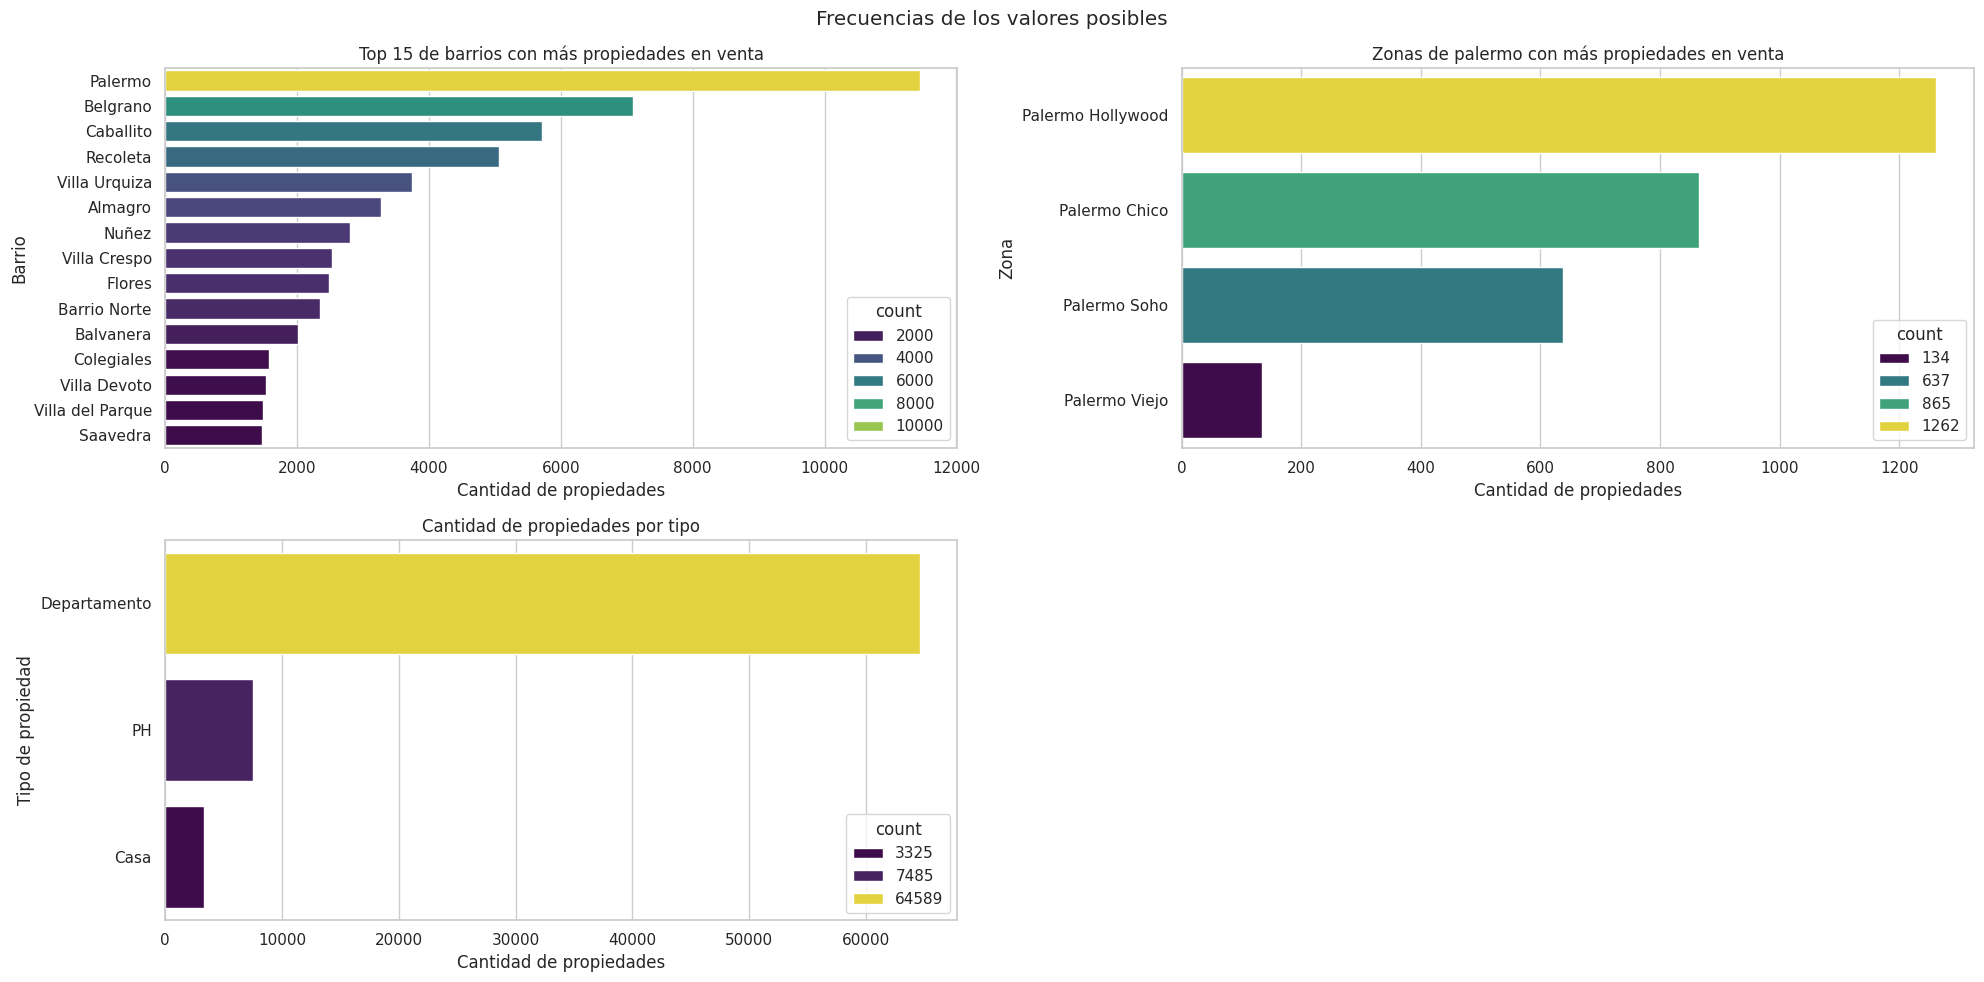

In [1150]:
plt.figure(figsize=(20, 10)) # 10x10 inches
plt.suptitle('Frecuencias de los valores posibles')

# bar plot por place_l3
plt.subplot(2, 2, 1) # 2 filas, 2 columnas, 1 posicion
frecuencias_place_3 = prop_train["place_l3"].value_counts().head(15)
sns.barplot(x=frecuencias_place_3.values, y=frecuencias_place_3.index, hue=frecuencias_place_3, palette='viridis')
plt.title('Top 15 de barrios con más propiedades en venta')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Barrio')

# bar plot por place_l4
plt.subplot(2, 2, 2) # 2 filas, 2 columnas, 2 posicion
frecuencias_place_4 = prop_train["place_l4"].value_counts()
sns.barplot(x=frecuencias_place_4.values, y=frecuencias_place_4.index, hue=frecuencias_place_4, palette='viridis')
# Ya que los 4 valores posibles pertenecen a Palermo
plt.title('Zonas de palermo con más propiedades en venta')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Zona')

# bar plot por property_type
plt.subplot(2, 2, 3) # 2 filas, 2 columnas, 3 posicion
frecuencias_property_type = prop_train["property_type"].value_counts()
sns.barplot(x=frecuencias_property_type.values, y=frecuencias_property_type.index, hue=frecuencias_property_type, palette='viridis')
plt.title('Cantidad de propiedades por tipo')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Tipo de propiedad')

plt.tight_layout()
plt.show()

*Anotacion: todos los place_l4 que no son NaN son zonas de palermo.*

### Variables irrelevantes para el analisis

Las variables que se pueden considerar irrelevantes para el analisis que se les dara son:

* **ID**: no aporta informacion para analizar, sin embargo puede ser util para propositos de manejo de datos.
* **Place_l2**: siempre son capital federal debido al primer filtro
* **Place_l5/l6**: no tienen ningun valor en ningun registro lo que los hace innecesarios.
* **Operation**: debido a el pre-procesamiento de los datos todos los registros tendran una operacion de venta, es decir que este atributo pasa a ser redundante.
* **Property_currency**: similarmente como pasa con *operation* pasa con este otro atributo, es un atributo redundante ya que todos seran USD.
* **Property_title**: no aporta informacion relevante al analisis.
* **Latitud/Longitud**: como ya se tiene el barrio de la propiedad en place_l2 esta informacion puede o no ser relevante dependiendo si se quiere ver la ubicacion exacta o si se quiere validar el barrio.
* **Variables de fechas (start/end/created)**: estas variables podrian ser utiles si se hace un analisis por ejemplo para ver cuales son las fechas donde mas ventas empiezan/terminan/se crean, de lo contrario no es relevante.

#### En sintesis

En base a lo anterior dicho se toma la decision de dejar de contar con los atributos:

* place_l2
* place_l5/l6 (se abordara en la seccion de datos faltantes)
* operation
* property_currency
* property title

In [1151]:
# Nuevo filtro para eliminar dichas columnas
columnas_a_eliminar = ['place_l2', 'operation', 'property_currency', 'property_title']
prop_train.drop(columns = columnas_a_eliminar,inplace=True)
prop_test.drop(columns = columnas_a_eliminar,inplace=True)

### Analisis grafico de distribucion de variables mas relevantes

* distribucion de precios
* distribucion de publicaciones por mes
* distribucion de habitaciones y dormitorios

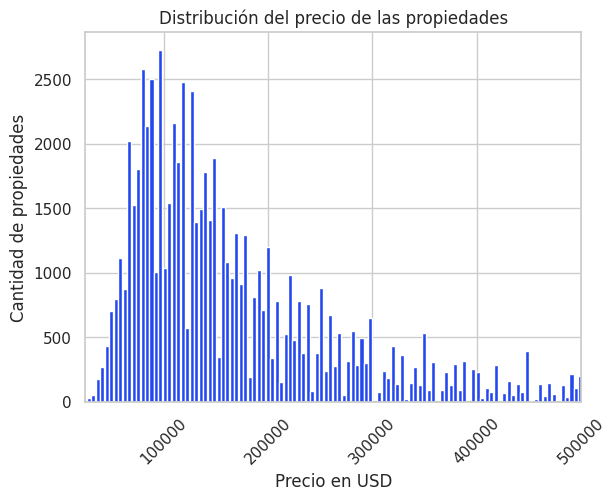

In [1152]:
# plot de distribucion de property_price

plt.hist(data=prop_train,x="property_price",bins=5000, color="#2348F0",rwidth=0.9)
plt.xlim(25000,500000)
plt.xlabel("Precio en USD")
plt.ylabel("Cantidad de propiedades")
plt.title("Distribución del precio de las propiedades")
plt.xticks(rotation=45)

plt.show()

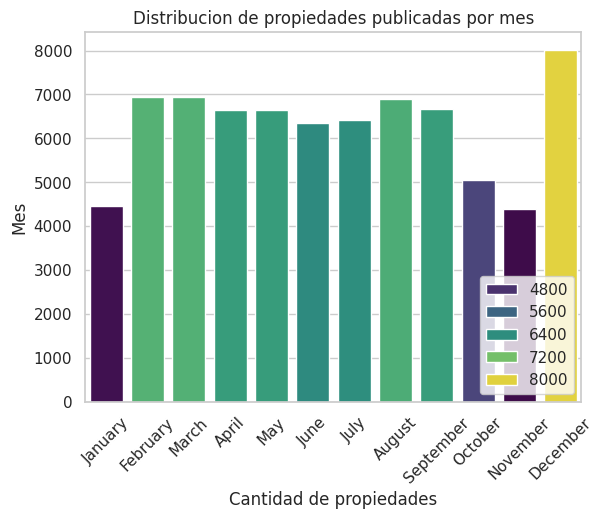

In [1153]:
# bar plot distribucion de ventas por mes

prop_train["created_on"] = pd.to_datetime(prop_train["created_on"])
meses = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
frecuencias_mes = prop_train["created_on"].dt.month_name().value_counts().reindex(meses)
sns.barplot(x=frecuencias_mes.index, y=frecuencias_mes.values, hue=frecuencias_mes, palette='viridis')
plt.legend(loc='lower right')
plt.title('Distribucion de propiedades publicadas por mes')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Mes')
plt.xticks(rotation=45)

plt.show()

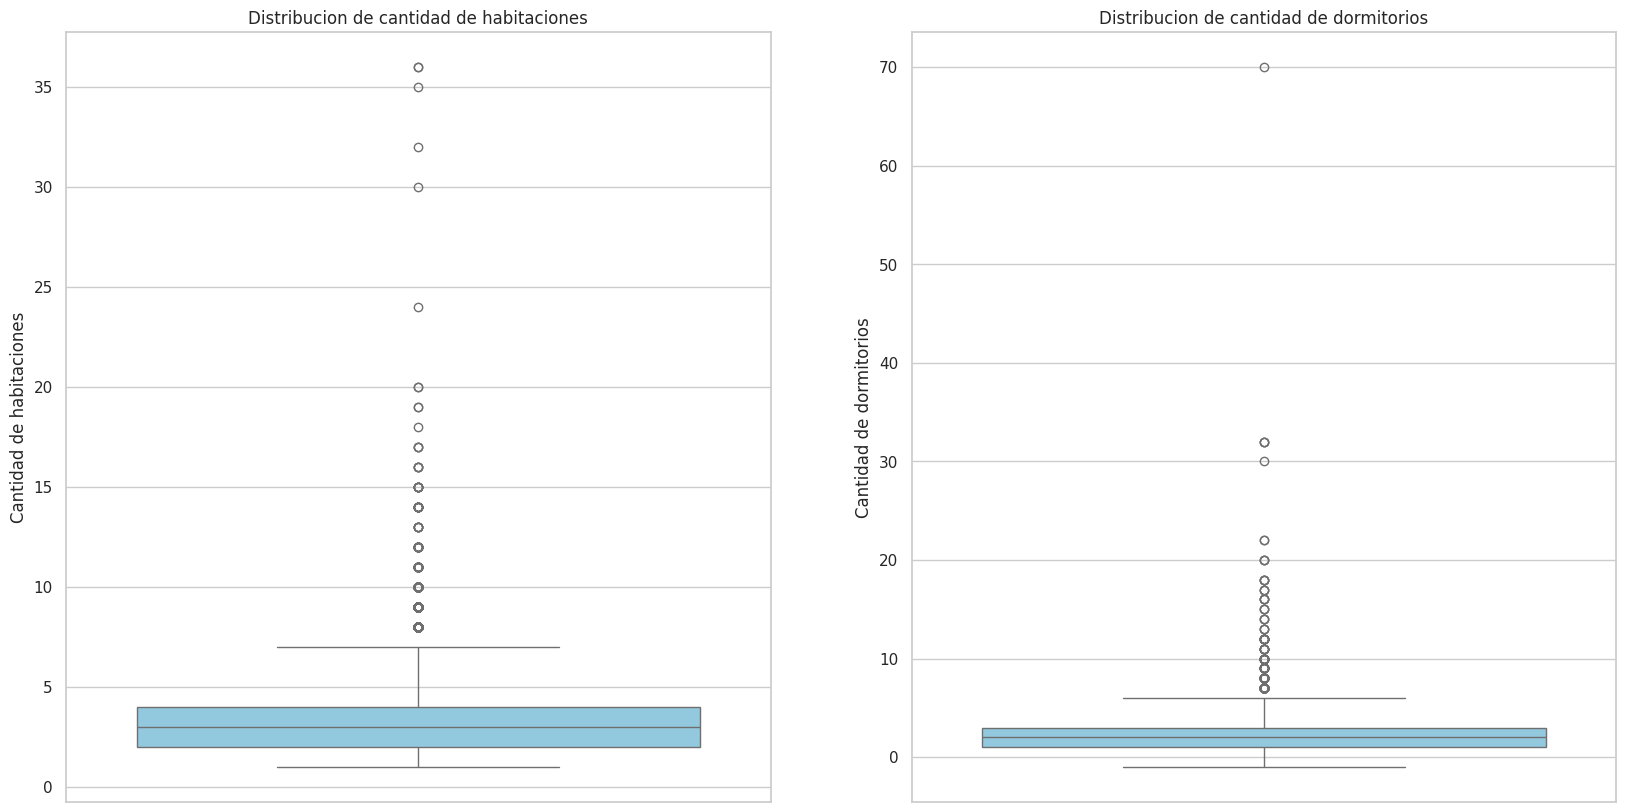

In [1154]:
# Boxplot de property_rooms y property_bedrooms
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, 1 posicion
sns.boxplot(data=prop_train, y='property_rooms', color='skyblue')
plt.title('Distribucion de cantidad de habitaciones')
plt.ylabel('Cantidad de habitaciones')

plt.subplot(1, 2, 2) # 1 fila, 2 columnas, 2 posicion
sns.boxplot(data=prop_train, y='property_bedrooms', color='skyblue')
plt.title('Distribucion de cantidad de dormitorios')
plt.ylabel('Cantidad de dormitorios')

plt.show()

### Analisis de correlaciones existentes entre variables

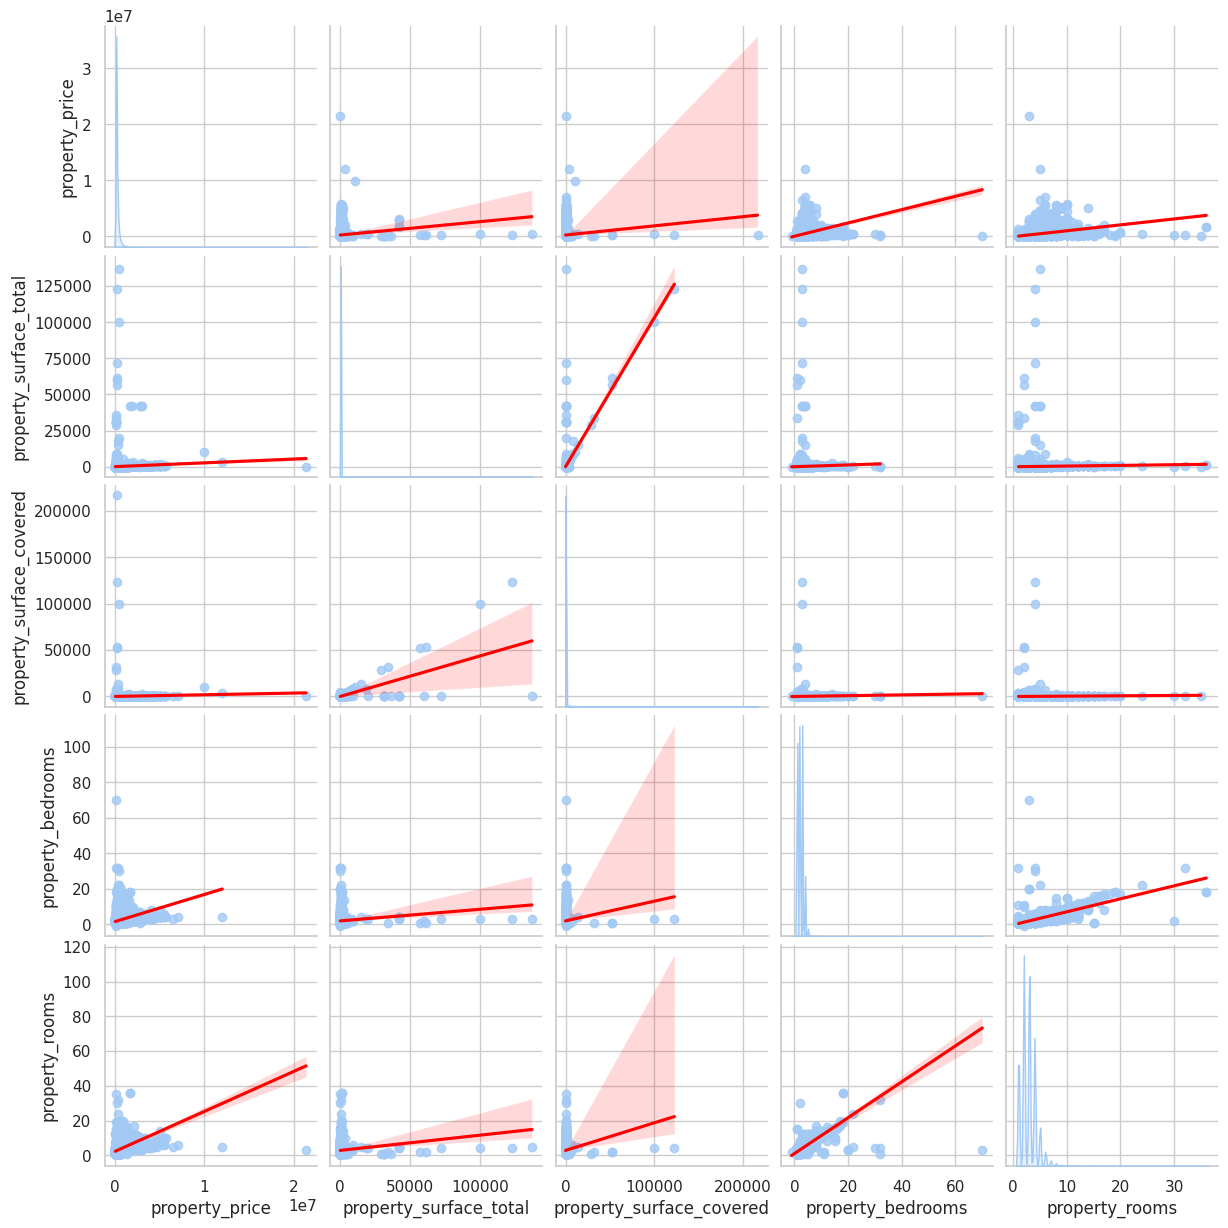

In [1155]:
# pairplot con price, surface_total, surface_covered, bedrooms, rooms
sns.pairplot(prop_train[['property_price', 'property_surface_total', 'property_surface_covered', 'property_bedrooms', 'property_rooms']], diag_kind='kde', kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

Observando este grafico de relaciones se pueden ver que algunas de estas variables tienen claramente una relacion y otras no tanto.

* La relacion entre la **superficie total** y **superficie cubierta** es lineal y acendente, es decir da la impresion que una dependiera de la otra, y si se piensa logicamente esto tiene sentido (si hay mas espacio se cubre mas espacio) aunque no siempre es necesariamente el caso (puede haber una casa pequeña en un terreno grande)
* La relacion entre el **precio** y la cantidad de **habitaciones** y **dormitorios**, en esta se puede notar que a mas habitaciones y/o dormitorios mas aumenta el maximo precio pero no deja de haber precios mas bajos, sin embargo, pasada una cierta cantidad (aproximadamente ~15) el precio deja de aumentar y mas bien se queda constante (entre los valores hasta ~250,000 USD)
* La relacion entre **habitaciones** y **dormitorios** tambien es lineal y acendente, lo cual puede deberse a que cuando una casa tiene muchas habitaciones esta probablemente tenga tambien muchos dormitorios.

*Extra: hay ciertos valores outliers que pueden afectar a la correlacion entre variables por ejemplo una propiedad con mas de 60 habitaciones, estos seran analizados en la seccion de valores atipicos*

Para hacer un analisis mas profundo de estos datos se analiza la *covarianza* y *correlacion* entre las variables usadas en la figura anterior:

In [1156]:
# covarianza y correlacion entre property_surface_total y property_surface_covered
covariance = prop_train['property_surface_total'].cov(prop_train['property_surface_covered'])
correlation = prop_train['property_surface_total'].corr(prop_train['property_surface_covered'])
print(f'Surface Total vs Surface Covered\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_rooms
covariance = prop_train['property_price'].cov(prop_train['property_rooms'])
correlation = prop_train['property_price'].corr(prop_train['property_rooms'])
print(f'Price vs Rooms\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_bedrooms
covariance = prop_train['property_price'].cov(prop_train['property_bedrooms'])
correlation = prop_train['property_price'].corr(prop_train['property_bedrooms'])
print(f'Price vs Bedrooms\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_surface_total
covariance = prop_train['property_price'].cov(prop_train['property_surface_total'])
correlation = prop_train['property_price'].corr(prop_train['property_surface_total'])
print(f'Price vs Surface Total\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_surface_covered
covariance = prop_train['property_price'].cov(prop_train['property_surface_covered'])
correlation = prop_train['property_price'].corr(prop_train['property_surface_covered'])
print(f'Price vs Surface Covered\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre property_rooms y property_bedrooms
covariance = prop_train['property_rooms'].cov(prop_train['property_bedrooms'])
correlation = prop_train['property_rooms'].corr(prop_train['property_bedrooms'])
print(f'Rooms vs Bedrooms\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

Surface Total vs Surface Covered
Covariance: 500687.65 & Correlation: 0.67

Price vs Rooms
Covariance: 213887.40 & Correlation: 0.49

Price vs Bedrooms
Covariance: 154956.42 & Correlation: 0.43

Price vs Surface Total
Covariance: 26377939.63 & Correlation: 0.08

Price vs Surface Covered
Covariance: 18142605.24 & Correlation: 0.05

Rooms vs Bedrooms
Covariance: 1.31 & Correlation: 0.87



Esto nos dice que en efecto lo previamente observado era el caso. Tambien ahora gracias a este analisis se ve que las relaciones mas debiles son las dadas entre el precio y las superficies totales/cubiertas.

## Visualización de los datos

In [1157]:
# Crear una copia del DataFrame original prop_train
visu_prop_train = prop_train.copy()

# Aplicar el filtro por la columna 'property_rooms' < 6 en la copia
visu_prop_train = visu_prop_train[visu_prop_train['property_rooms'] < 6]

# Filtrar propiedades con precios entre 20,000 y 500,000
visu_prop_train = visu_prop_train[(visu_prop_train['property_price'] > 20000) &
                             (visu_prop_train['property_price'] < 500000)]

# Crear una tabla pivote para calcular el precio promedio por barrio y cantidad de habitaciones
df_visu = visu_prop_train.pivot_table(values='property_price',
                                      index='place_l3',
                                      columns='property_rooms',
                                      aggfunc='mean')

df_visu

#Modificamos un rango para que se vea mejor la visualizacion

property_rooms                  1.0            2.0            3.0  \
place_l3                                                            
Abasto                 68355.813953   93877.949153  120568.268293   
Agronomía              71985.896552  104498.038462  173752.631579   
Almagro                76487.372800   97594.369524  141217.253385   
Balvanera              65863.720670   77829.762324  118941.779743   
Barracas               89479.242857  108103.021368  156219.752187   
Barrio Norte           94201.185676  113878.359177  192345.761745   
Belgrano              103886.341463  144325.025303  214634.669773   
Boca                   65073.657895   68429.569892   93739.314607   
Boedo                  68854.436508   92142.456869  135074.616766   
Caballito              85378.574928  110983.150977  164211.404749   
Catalinas              47000.000000            NaN  128000.000000   
Centro / Microcentro   60314.285714   79734.782609  111500.000000   
Chacarita              83039.511278  109867.716763  179068.777778   
Coghlan                87183.238372  124596.524390  201194.695187   
Colegiales             88514.337165  128362.645374  195018.676087   
Congreso               65471.923077   82169.500000  118056.817460   
Constitución           60567.480000   67924.323529   95325.806452   
Flores                 71149.256637   90162.751914  131807.459103   
Floresta               66966.017699   86566.487273  129396.503676   
Las Cañitas           110000.000000  234800.000000            NaN   
Liniers                65242.186047   88451.832335  139379.439189   
Mataderos              64117.136364   91757.928571  132469.458537   
Monserrat              76054.334532   85334.718182  117552.358079   
Monte Castro           79083.250000   95661.966942  149281.504202   
Nuñez                 104548.283019  140269.366845  213181.241587   
Once                   52700.000000   74519.444444  119211.881188   
Palermo               105002.008913  148612.991599  237936.286408   
Parque Avellaneda      72783.333333   83048.000000  109982.075472   
Parque Centenario      82812.500000   98967.166667  151170.588235   
Parque Chacabuco       77374.758929   95148.678218  144399.693141   
Parque Chas            76105.513158  106997.345679  180112.630137   
Parque Patricios       65954.838710   89119.213675  108526.918919   
Paternal               78391.975904   91113.340278  127461.284404   
Pompeya                44945.454545   57441.147059   95051.562500   
Puerto Madero         253358.235955  332867.524116  396927.444444   
Recoleta               98074.208392  126906.395536  228793.784937   
Retiro                 95504.831579  101697.935484  180887.142857   
Saavedra               93005.496970  118479.201389  187437.343243   
San Cristobal          63929.268085   77757.904059  112143.971698   
San Nicolás            60011.085714   79803.258675  117080.323810   
San Telmo              79400.097403  105699.525680  138714.806780   
Tribunales             60746.000000   90136.842105  112044.350000   
Velez Sarsfield        69014.814815   93857.800000  142218.867925   
Versalles              78586.363636  104478.281250  150678.666667   
Villa Crespo           82727.424474  105422.843293  153877.987805   
Villa Devoto           92043.464912  113100.186047  178499.899628   
Villa General Mitre    69660.400000   87435.550000  131649.557522   
Villa Lugano           66007.058824   83980.701754   90175.860262   
Villa Luro             72029.577465   94641.675000  135317.759259   
Villa Ortuzar          77512.761468   99280.327684  185591.322034   
Villa Pueyrredón       79171.208696  109674.844660  161711.494297   
Villa Real             81500.000000  101883.333333  140417.073171   
Villa Riachuelo                 NaN   89600.000000   78380.000000   
Villa Santa Rita       77582.433333   94497.141026  142929.245455   
Villa Soldati                   NaN   67000.000000   94800.000000   
Villa Urquiza          91927.084098  124079.944030  190624.957597  

Text(70.93749999999999, 0.5, 'Zonas de Capital Federal')

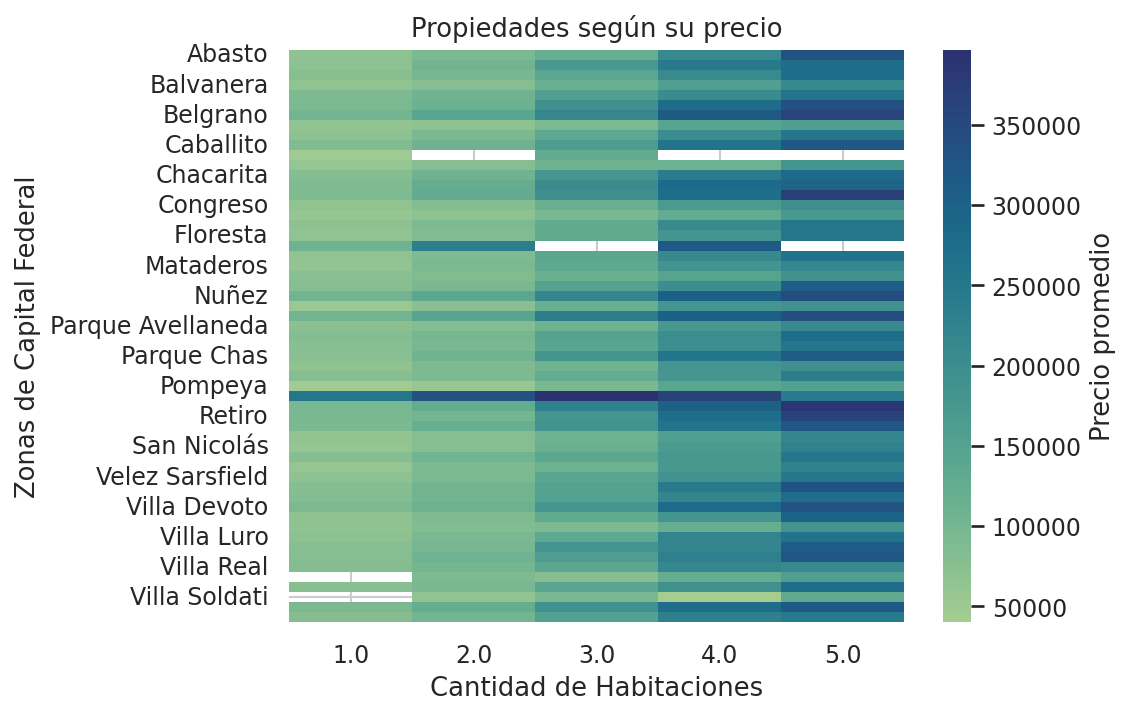

In [1158]:
# Nueva figura con un dpi de 155 para mejorar la calidad de la visualización
plt.figure(dpi=155)

# Establecer el título de la visualización
plt.title("Propiedades según su precio")

# Crear un heatmap utilizando Seaborn con los datos de df_visu
sns.heatmap(df_visu, square=False, cmap='crest', fmt=".0f", cbar_kws={'label': 'Precio promedio'})

# Establecer etiquetas para los ejes x e y
plt.xlabel("Cantidad de Habitaciones")
plt.ylabel("Zonas de Capital Federal")

# Heatmap que muestra el precio promedio por propiedad tomando en cuenta la cantidad de habitaciones y su ubicación

La visualización presentada es un mapa de calor (heatmap) que muestra el precio promedio de las propiedades en función de la cantidad de habitaciones y su ubicación en diferentes zonas de la Ciudad Autónoma de Buenos Aires (CABA). Al observar el heatmap, es posible identificar patrones en los precios según la ubicación y el tamaño de la propiedad. Por ejemplo, puede haber áreas donde las propiedades con más habitaciones tienden a tener precios más altos, mientras que en otras zonas los precios son más uniformes independientemente del tamaño de la propiedad.La visualización proporciona una manera efectiva de entender cómo se relacionan el precio promedio de las propiedades, la cantidad de habitaciones y la ubicación en diferentes áreas de la Ciudad Autónoma de Buenos Aires. Ayuda a los interesados a tomar decisiones informadas sobre la compra o inversión en propiedades en la ciudad.

<ipython-input-1159-ee8e753002fe>:6: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



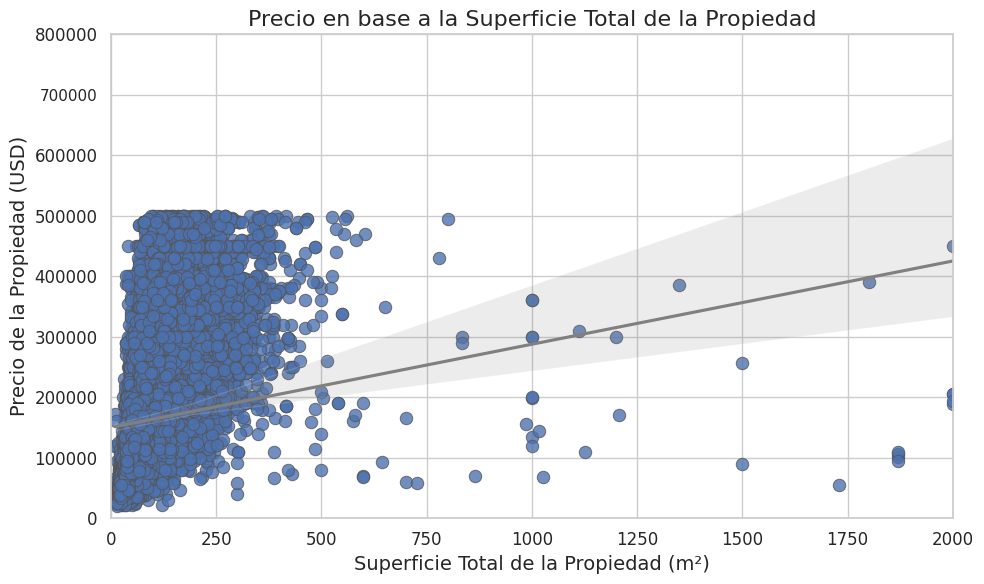

In [1159]:
# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Crear el scatter plot utilizando Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visu_prop_train[visu_prop_train['property_surface_total'] < 20000],
                x='property_surface_total', y='property_price', palette='pastel', s=80, alpha=0.8)

# Agregar una línea de regresión
sns.regplot(data=visu_prop_train[visu_prop_train['property_surface_total'] < 20000],
            x='property_surface_total', y='property_price', scatter=False, color='gray')

# Ajustar título y etiquetas
plt.title('Precio en base a la Superficie Total de la Propiedad', fontsize=16)
plt.xlabel('Superficie Total de la Propiedad (m²)', fontsize=14)
plt.ylabel('Precio de la Propiedad (USD)', fontsize=14)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ajustar el rango de los ejes
plt.xlim(0, 2000)  # Establecer el rango x hasta 20,000
plt.ylim(0, 800000)
# Añadir sombreado alrededor de las burbujas
plt.gca().collections[0].set_edgecolor("#555555")

plt.tight_layout()
plt.show()

Esta visualización muestra un diagrama de dispersión (scatter plot) que relaciona el precio de la propiedad con su superficie total, con el agregado de una línea de regresión para visualizar la tendencia general de los datos.La línea de regresión trazada en el gráfico muestra la tendencia general de los datos. Permite ver si hay una relación lineal entre el precio y la superficie total de la propiedad. En este caso, la pendiente de la línea de regresión indica la tasa de cambio en el precio para cada unidad adicional de superficie.Cada punto en el diagrama de dispersión representa una propiedad individual, y su posición relativa en el gráfico indica su precio y superficie total. Esto facilita la identificación de propiedades que pueden estar por encima o por debajo de la tendencia general.

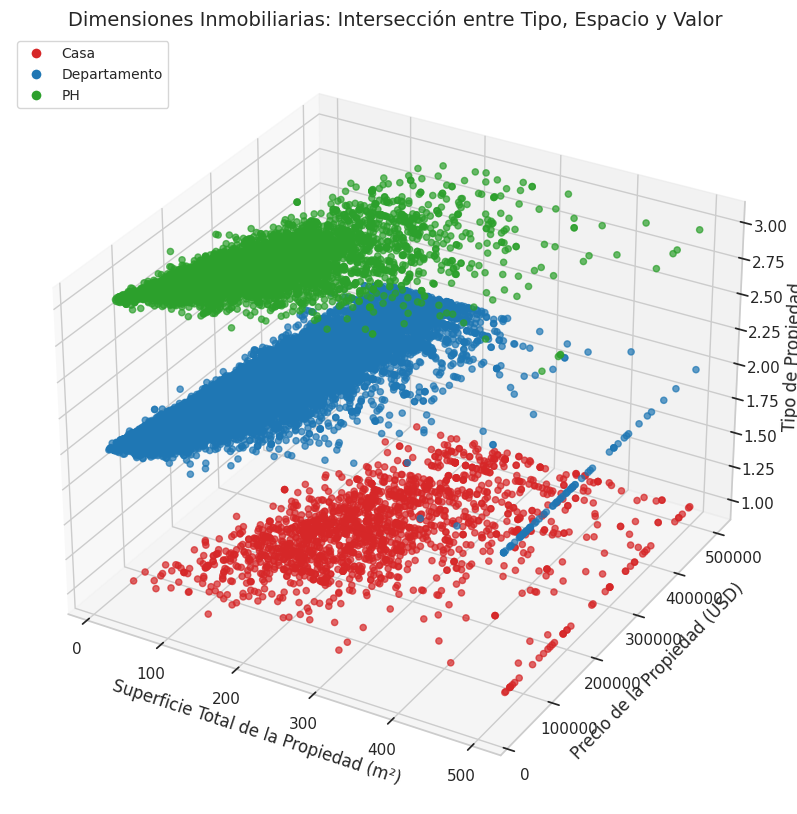

In [1160]:
# Crear una figura y un conjunto de ejes tridimensionales
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Mapa de colores para los tipos de propiedad
color_mapping = {'Casa': 'tab:red', 'Departamento': 'tab:blue', 'PH': 'tab:green'}

# Asignar un valor numérico a cada tipo de propiedad
property_type_mapping = {'Casa': 1, 'Departamento': 2, 'PH': 3}
property_type_numeric = [property_type_mapping[prop_type] for prop_type in visu_prop_train['property_type']]

# Extraer las variables del dataframe
property_surface_total = visu_prop_train['property_surface_total'].clip(0, 500)
property_price = visu_prop_train['property_price']

# Graficar los puntos tridimensionales
scatter = ax.scatter(property_surface_total, property_price, property_type_numeric, c=[color_mapping[prop_type] for prop_type in visu_prop_train['property_type']], alpha=0.7)

# Etiquetas de los ejes
ax.set_xlabel('Superficie Total de la Propiedad (m²)', fontsize=12)
ax.set_ylabel('Precio de la Propiedad (USD)', fontsize=12)
ax.set_zlabel('Tipo de Propiedad', fontsize=12)

# Leyenda para los colores
legend_labels = ['Casa', 'Departamento', 'PH']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[prop_type], markersize=8, label=prop_type) for prop_type in legend_labels]
ax.legend(handles=legend_handles, labels=legend_labels, loc='upper left', fontsize=10)

# Añadir una rejilla de fondo
ax.grid(True)

# Título del gráfico
plt.title('Dimensiones Inmobiliarias: Intersección entre Tipo, Espacio y Valor', fontsize=14)

# Mostrar el gráfico
plt.show()

Este gráfico tridimensional permite visualizar la distribución de las propiedades en función de su tipo, tamaño y precio. Se pueden identificar patrones de agrupamiento o tendencias en el espacio tridimensional, lo que puede ser útil para comprender mejor el mercado inmobiliario y tomar decisiones informadas. Además, podría usarse para ajustar un modelo de regresión tridimensional para predecir el precio de una propiedad en función de su tipo y tamaño.

In [1161]:
# Calcular el precio promedio por barrio
precio_promedio_por_barrio = visu_prop_train.groupby('place_l3')['property_price'].mean().reset_index()

# Crear el gráfico de burbujas agrupadas
fig = px.scatter(precio_promedio_por_barrio,
                 x='place_l3', y='property_price',
                 size='property_price',
                 color='place_l3',
                 hover_name='place_l3',
                 size_max=50,
                 title='Precio promedio por barrio',
                 labels={'place_l3': 'Barrio', 'property_price': 'Precio promedio'})
fig.show()

Esta visualización muestra un gráfico de burbujas agrupadas que representa el precio promedio de las propiedades en cada barrio.El gráfico de burbujas agrupadas proporciona una representación visual del precio promedio de las propiedades en cada barrio de interés. Cada burbuja representa un barrio, y el tamaño de la burbuja indica el precio promedio de las propiedades en ese barrio. Los colores de las burbujas pueden indicar diferentes barrios para facilitar la identificación visual, las burbujas más grandes representan barrios con precios promedio más altos, mientras que las burbujas más pequeñas representan barrios con precios promedio más bajos.El gráfico de burbujas agrupadas es interactivo, lo que permite a los usuarios explorar los datos con mayor detalle al pasar el cursor sobre las burbujas para ver información adicional, como el nombre del barrio y el precio promedio.

In [1162]:
# Filtramos los Nan de latitud ya que es impresindible contar con este dato para asignarlo al mapa
visu_prop_train = visu_prop_train.dropna(subset=['latitud'])

def generar_mapa_con_registros_por_barrio(df):
    """
    Función para generar un mapa con los registros por barrio.

    Parámetros:
    - visu_prop_train: DataFrame que contiene los datos de las propiedades filtradas.

    Devuelve:
    - mapa: Objeto del mapa de Folium.
    """
    # Coordenadas del centro de la Ciudad Autónoma de Buenos Aires
    latitud_caba = -34.6037
    longitud_caba = -58.3816

    # Crear el mapa centrado en CABA
    mapa = folium.Map(location=[latitud_caba, longitud_caba], zoom_start=12)

    # Agregar un grupo de marcadores
    marker_cluster = MarkerCluster().add_to(mapa)

    # Contar la cantidad de registros por barrio
    registros_por_barrio = visu_prop_train['place_l3'].value_counts()

    # Agregar marcadores en el mapa para cada barrio
    for barrio, cantidad in registros_por_barrio.items():
        latitud = visu_prop_train[visu_prop_train['place_l3'] == barrio]['latitud'].iloc[0]
        longitud = visu_prop_train[visu_prop_train['place_l3'] == barrio]['longitud'].iloc[0]

        folium.Marker(location=[latitud, longitud],
                      tooltip=f"{barrio}: {cantidad} Propiedad en Venta").add_to(marker_cluster)

    return mapa

# Generar el mapa con los registros por barrio
mapa = generar_mapa_con_registros_por_barrio(visu_prop_train)

# Mostrar el mapa
mapa

La visualización proporciona un mapa interactivo que muestra la ubicación de las propiedades en venta en la Ciudad Autónoma de Buenos Aires (CABA), agrupadas por barrio.Cada marcador en el mapa representa una propiedad, y su ubicación específica está determinada por las coordenadas de latitud y longitud proporcionadas en los datos.Los grupos de marcadores en el mapa indican la concentración de propiedades en cada barrio, lo que puede proporcionar información sobre la popularidad y la demanda de viviendas en diferentes áreas de CABA.

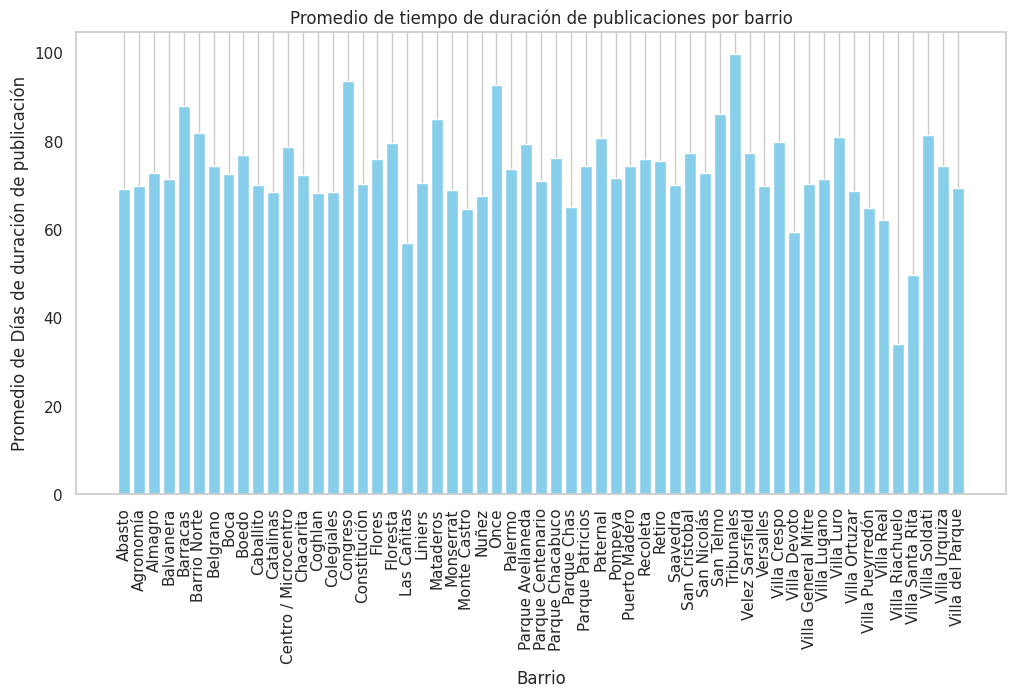

In [1163]:
# Convertir las fechas a tipo datetime si no están en ese formato
visu_prop_train['start_date'] = pd.to_datetime(visu_prop_train['start_date'], errors='coerce')
visu_prop_train['end_date'] = pd.to_datetime(visu_prop_train['end_date'], errors='coerce')

# Calcular la duración de cada publicación
visu_prop_train['duracion_publicacion'] = (visu_prop_train['end_date'] - visu_prop_train['start_date']).dt.days

# Agrupar por barrio y calcular el promedio de duración de las publicaciones
promedio_duracion_por_barrio = visu_prop_train.groupby('place_l3')['duracion_publicacion'].mean().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(promedio_duracion_por_barrio['place_l3'], promedio_duracion_por_barrio['duracion_publicacion'], color='skyblue')
plt.title('Promedio de tiempo de duración de publicaciones por barrio')
plt.xlabel('Barrio')
plt.ylabel('Promedio de Días de duración de publicación')
plt.xticks(rotation=90)
plt.grid(axis='y')

plt.show()

Esta visualización presenta un gráfico de barras que muestra el promedio de tiempo de duración de las publicaciones por barrio en la Ciudad Autónoma de Buenos Aires (CABA). Cada barra en el gráfico representa un barrio específico, y su altura indica el promedio de días que las publicaciones permanecen activas en ese barrio.La visualización permite comparar fácilmente la duración promedio de las publicaciones entre diferentes barrios de la ciudad. Las barras más altas indican que las publicaciones en ese barrio tienden a permanecer activas por más tiempo, mientras que las barras más cortas indican una duración promedio más corta de las publicaciones.Los barrios con barras más altas pueden indicar áreas de la ciudad donde la demanda de propiedades es más alta o donde las propiedades tienden a permanecer en el mercado por períodos más prolongados. Esto puede ser útil para comprender las dinámicas del mercado inmobiliario en diferentes áreas de la ciudad.

## Datos Faltantes
En esta sección se va a realizar el análsis de la presencia de datos faltantes

### Análisis de datos faltantes a nivel columna

#### Análisis previo

In [1164]:
ds_train = prop_train
ds_test = prop_test

In [1165]:
ds_train.columns

Index(['id', 'start_date', 'end_date', 'created_on', 'latitud', 'longitud',
       'place_l3', 'place_l4', 'place_l5', 'place_l6', 'property_type',
       'property_rooms', 'property_bedrooms', 'property_surface_total',
       'property_surface_covered', 'property_price'],
      dtype='object')

Para iniciar, vamos a analizar la cantidad de datos faltantes por columna y su porcentaje

In [1166]:
def obtener_filas(ds):
  return ds.shape[0]

def obtener_columnas(ds):
  return ds.shape[1]

In [1167]:
filas = obtener_filas(ds_train)
columnas = obtener_columnas(ds_train)
print("El dataset de entrenamiento tiene {} filas y {} columnas".format(filas,columnas))

El dataset de entrenamiento tiene 75399 filas y 16 columnas


Obtengo el porcentaje de cada columna que contiene datos nulos

In [1168]:
def obtener_promedio_nulos(ds):
  return ds.isna().sum() / obtener_filas(ds) * 100

promedio_datos_nulos = obtener_promedio_nulos(ds_train)
promedio_datos_nulos

id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.891298
longitud                      3.891298
place_l3                      0.450934
place_l4                     96.156448
place_l5                    100.000000
place_l6                    100.000000
property_type                 0.000000
property_rooms                1.111421
property_bedrooms            11.693789
property_surface_total        5.042507
property_surface_covered      3.567687
property_price                0.000000
dtype: float64

Muestro la cantidad de datos nulos por columna

In [1169]:
def obtener_cantidad_nulos_ds(ds):
  return ds.isna().sum()

cant_datos_nulos = obtener_cantidad_nulos_ds(ds_train)
cant_datos_nulos

id                              0
start_date                      0
end_date                        0
created_on                      0
latitud                      2934
longitud                     2934
place_l3                      340
place_l4                    72501
place_l5                    75399
place_l6                    75399
property_type                   0
property_rooms                838
property_bedrooms            8817
property_surface_total       3802
property_surface_covered     2690
property_price                  0
dtype: int64

Grafico esta relación

<ipython-input-1170-f848825aef01>:21: UserWarning:

FixedFormatter should only be used together with FixedLocator



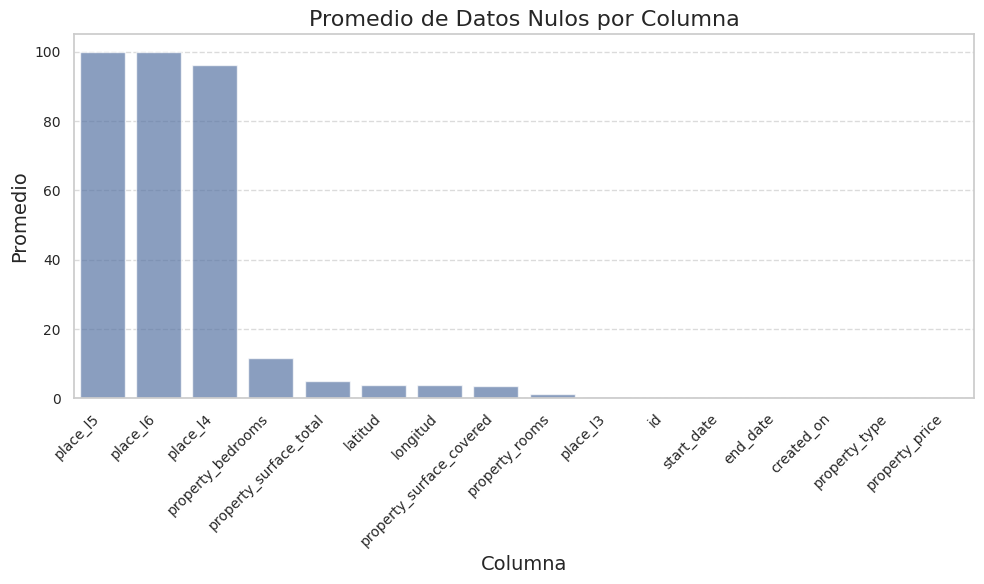

In [1170]:
ds_porcentaje = promedio_datos_nulos

# Ordenar los valores en orden descendente
ds_porcentaje = ds_porcentaje.sort_values(ascending = False)

# Establecer el estilo del gráfico
sns.set_style("whitegrid")

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Graficar el gráfico de barras
bar_plot = sns.barplot(x=ds_porcentaje.index, y=ds_porcentaje.values, alpha=0.7)

# Agregar título y etiquetas
bar_plot.set_title("Promedio de Datos Nulos por Columna", fontsize=16)
bar_plot.set_xlabel("Columna", fontsize=14)
bar_plot.set_ylabel("Promedio", fontsize=14)

# Rotar etiquetas del eje x para una mejor legibilidad
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Agregar líneas de la cuadrícula y ajustar el tamaño de la fuente
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Entonces los datos que debo analizar son:

In [1171]:
def obtener_cantidad_nulos(ds):
  promedio_datos_nulos = obtener_promedio_nulos(ds)
  promedio_datos_nulos.sort_values(ascending = False,inplace=True)
  filtro = promedio_datos_nulos!=0
  return promedio_datos_nulos[filtro] if not promedio_datos_nulos[filtro].empty else 'No existen valores NaN'

obtener_cantidad_nulos(ds_train)

place_l5                    100.000000
place_l6                    100.000000
place_l4                     96.156448
property_bedrooms            11.693789
property_surface_total        5.042507
latitud                       3.891298
longitud                      3.891298
property_surface_covered      3.567687
property_rooms                1.111421
place_l3                      0.450934
dtype: float64

In [1172]:
obtener_cantidad_nulos(ds_test)

place_l5                    100.000000
place_l6                    100.000000
place_l4                     96.047745
property_bedrooms            11.511936
property_surface_total        5.527851
latitud                       4.222812
longitud                      4.222812
property_surface_covered      3.522546
property_rooms                1.092838
place_l3                      0.408488
dtype: float64

#### Elimino places (place_l6, place_l5, place_l4)

Al ver el gráfico y el análisis previo de nulos. Puedo eliminar las columnas ```place_l6```, ```place_l5``` y ```place_l4```, pues tienen en su totalidad de datos nulos. El ```place_l4``` tiene casi su totalidad de nulos.

Consideramos que las columnas ```place_l6```, ```place_l5``` son datos faltantes de tipo MCAR

In [1173]:
columnas = ['place_l6','place_l5','place_l4']
ds_train.drop(columns=columnas, inplace=True)
ds_test.drop(columns=columnas, inplace=True)

In [1174]:
ds_train.head()

id  start_date    end_date created_on  \
366154  Ab/aN6T8Mna0dAIe9hPIpA==  2021-04-10  2021-06-05 2021-04-10   
408027  MzDpszQ1Zx3SGERGycYoSw==  2021-03-05  2021-03-09 2021-03-05   
142290  Axqbmsbzc9JHXG5S0xW0fg==  2021-03-10  2021-05-06 2021-03-10   
31141   ds5G1c/HVhlxBxwWAGvn3Q==  2021-03-29  2021-04-15 2021-03-29   
219179  DuRHdE5YZY2gPv3gNbtB3Q==  2021-10-23  2021-11-03 2021-10-23   

          latitud   longitud       place_l3 property_type  property_rooms  \
366154 -34.558977 -58.458816       Belgrano  Departamento             3.0   
408027 -34.551437 -58.454158          Nuñez  Departamento             2.0   
142290 -34.638146 -58.509707     Villa Luro  Departamento             3.0   
31141  -34.585703 -58.418339        Palermo  Departamento             4.0   
219179 -34.568861 -58.505879  Villa Urquiza            PH             5.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
366154                2.0                    78.0                      71.0   
408027                1.0                    38.0                      38.0   
142290                2.0                    54.0                      54.0   
31141                 3.0                     NaN                     100.0   
219179                4.0                   273.0                     137.0   

        property_price  
366154        152000.0  
408027        116000.0  
142290         82000.0  
31141         260000.0  
219179        235000.0

In [1175]:
ds_test.head()

id  start_date    end_date  created_on  \
363703  QH5COmsU7tPldvqLfhA/lg==  2021-01-16  2021-03-23  2021-01-16   
86137   OYgPnciYR/al4BGPMKimwg==  2021-03-26  2021-04-15  2021-03-26   
52481   5XABqvBL1PNNFMvWPyzRXQ==  2021-12-05  2021-12-18  2021-12-05   
432086  AOcemJ6TzfhlMVR/uD73PQ==  2021-12-16  2022-02-09  2021-12-16   
53911   EKOrFj/uBc7xxtxAgnqbRg==  2021-09-22  2021-09-26  2021-09-22   

          latitud   longitud          place_l3 property_type  property_rooms  \
363703 -34.639975 -58.438678  Parque Chacabuco  Departamento             2.0   
86137  -34.603768 -58.433634         Caballito  Departamento             3.0   
52481  -34.625908 -58.417775             Boedo  Departamento             4.0   
432086 -34.612766 -58.496000  Villa del Parque  Departamento             2.0   
53911  -34.615833 -58.371799         San Telmo  Departamento             4.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
363703                1.0                    48.0                      42.0   
86137                 2.0                    73.0                      73.0   
52481                 3.0                    79.0                      71.0   
432086                1.0                    42.0                      42.0   
53911                 3.0                    97.0                      72.0   

        property_price  
363703         95000.0  
86137         137000.0  
52481         138900.0  
432086         92900.0  
53911         129900.0

In [1176]:
nulos_preimputacion = obtener_cantidad_nulos(ds_train)

In [1177]:
obtener_cantidad_nulos(ds_test)

property_bedrooms           11.511936
property_surface_total       5.527851
latitud                      4.222812
longitud                     4.222812
property_surface_covered     3.522546
property_rooms               1.092838
place_l3                     0.408488
dtype: float64

#### Generar funciones para análisis

In [1178]:
# establezco si son o no nulos
def generar_ds_nulo(columnas):
  return ds_train[columnas].isna()

def filtrar_nulo(columna,ds):
  return ds[columna]==True

def filtrar_no_nulo(columna,ds):
  return ds[columna]==False

def aplicar_filtro(ds,filtro,columna,nulidad):
  ds.loc[filtro,columna] = nulidad
  return ds

In [1179]:
def contar_ds(ds,columna):
  return ds[columna].value_counts()

def imprimir_cantidades(nulos,no_nulos,columna):
  print("Cantidad de datos NULOS en {}: {}".format(columna,nulos))
  print("Cantidad de datos NO NULOS en {}: {}".format(columna,no_nulos))

In [1180]:
def generar_grafico(ds, columna):
  # Ajustar el tamaño de la figura
  plt.figure(figsize=(10, 6))

  # Agrupar por 'longitud' y obtener el tamaño de cada grupo, luego trazar el gráfico de barras horizontales
  ds.groupby(columna).size().plot(kind='barh', color=sns.color_palette('Dark2'))

  # Ocultar los ejes superior y derecho
  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)

  titulo = 'Tamaño de Grupo por ' + columna
  # Configurar el tamaño de la letra del título y las etiquetas
  plt.title(titulo, fontsize=16)
  plt.xlabel('Cantidad', fontsize=14)
  plt.ylabel(columna, fontsize=14)

  # Mostrar el gráfico
  plt.show()

#### Latitud y longitud
Vamos a anlizar los nulos de estas dos variables

In [1181]:
latatitud_longitud = generar_ds_nulo(['latitud','longitud'])
# filtros latitud
v_filtro_latitud = filtrar_nulo('latitud',latatitud_longitud)
f_filtro_latitud = filtrar_no_nulo('latitud',latatitud_longitud)
# filtros longitud
v_filtro_longitud = filtrar_nulo('longitud',latatitud_longitud)
f_filtro_longitud = filtrar_no_nulo('longitud',latatitud_longitud)
# aplico los filtros
latatitud_longitud = aplicar_filtro(latatitud_longitud,v_filtro_latitud,'latitud','nulo')
latatitud_longitud = aplicar_filtro(latatitud_longitud,f_filtro_latitud,'latitud','no nulo')

latatitud_longitud = aplicar_filtro(latatitud_longitud,v_filtro_longitud,'longitud','nulo')
latatitud_longitud = aplicar_filtro(latatitud_longitud,f_filtro_longitud,'longitud','no nulo')

latatitud_longitud.head()



latitud longitud
366154  no nulo  no nulo
408027  no nulo  no nulo
142290  no nulo  no nulo
31141   no nulo  no nulo
219179  no nulo  no nulo

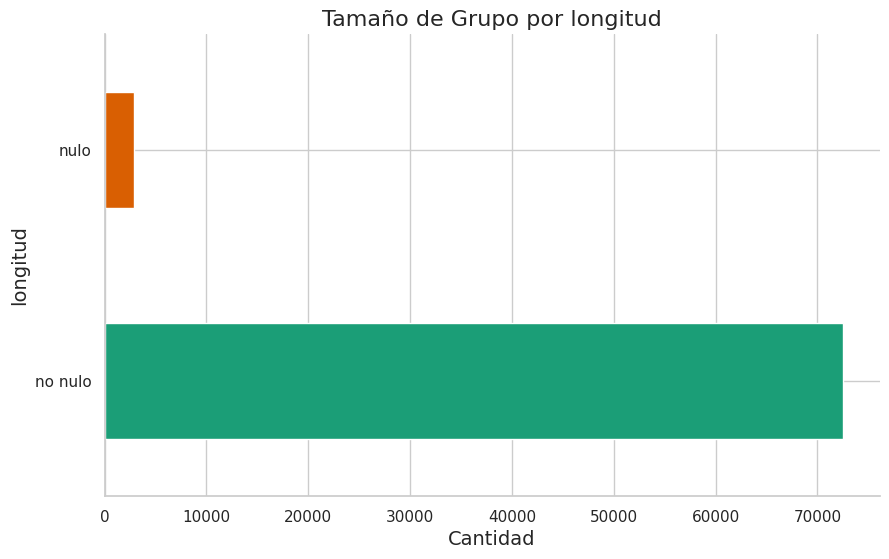

In [1182]:
generar_grafico(latatitud_longitud,'longitud')

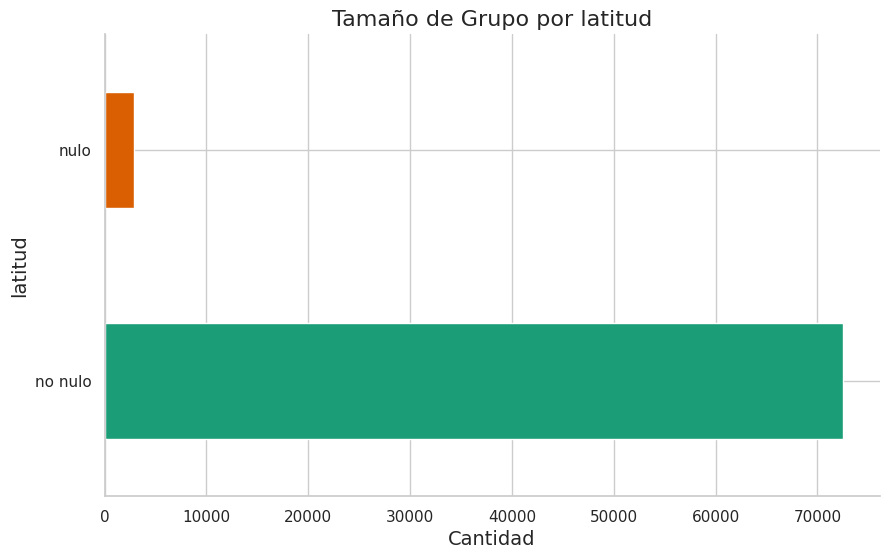

In [1183]:
generar_grafico(latatitud_longitud,'latitud')

In [1184]:
imprimir_cantidades(latatitud_longitud.value_counts()[1], latatitud_longitud.value_counts()[0], 'longitud')

Cantidad de datos NULOS en longitud: 2934
Cantidad de datos NO NULOS en longitud: 72465


In [1185]:
imprimir_cantidades(latatitud_longitud.value_counts()[1], latatitud_longitud.value_counts()[0], 'latitud')

Cantidad de datos NULOS en latitud: 2934
Cantidad de datos NO NULOS en latitud: 72465


#### Superficie total y Superficie cubierta (property_surface_total, property_surface_covered)

In [1186]:
# establezco si son o no nulos
sup_total_cubierta = generar_ds_nulo(['property_surface_total','property_surface_covered'])
# creo filtro si son o no nulos
v_filtro_total =  filtrar_nulo('property_surface_total',sup_total_cubierta)
f_filtro_total =  filtrar_no_nulo('property_surface_total',sup_total_cubierta)

v_filtro_cubierto =  filtrar_nulo('property_surface_covered',sup_total_cubierta)
f_filtro_cubierto =  filtrar_no_nulo('property_surface_covered',sup_total_cubierta)
# establezco los nulos y no nulos
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,v_filtro_total,'property_surface_total','nulo')
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,f_filtro_total,'property_surface_total','no nulo')

# establezco los nulos y no nulos
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,v_filtro_cubierto,'property_surface_covered','nulo')
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,f_filtro_cubierto,'property_surface_covered','no nulo')

sup_total_cubierta.head()

property_surface_total property_surface_covered
366154                no nulo                  no nulo
408027                no nulo                  no nulo
142290                no nulo                  no nulo
31141                    nulo                  no nulo
219179                no nulo                  no nulo

In [1187]:
imprimir_cantidades(sup_total_cubierta.value_counts()[1], sup_total_cubierta.value_counts()[0], 'property_surface_total')

Cantidad de datos NULOS en property_surface_total: 3802
Cantidad de datos NO NULOS en property_surface_total: 68907


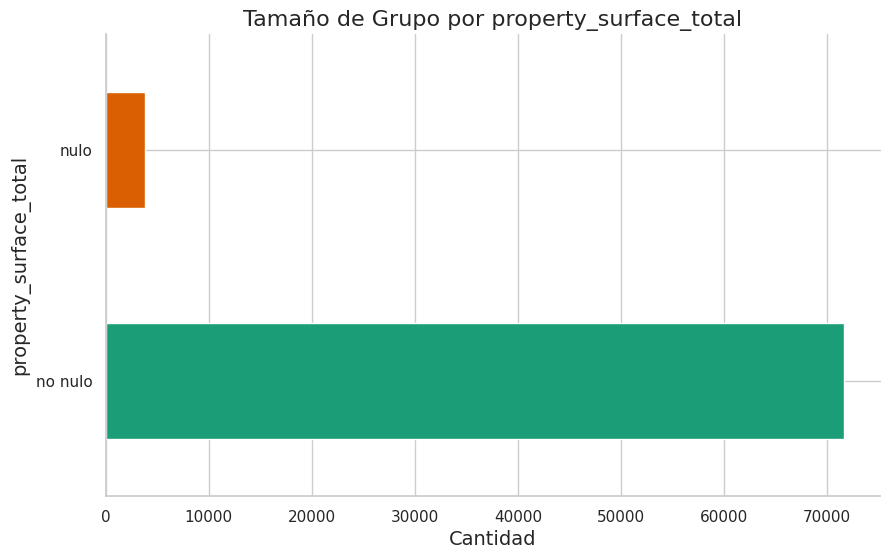

In [1188]:
generar_grafico(sup_total_cubierta,'property_surface_total')

In [1189]:
imprimir_cantidades(sup_total_cubierta.value_counts()[1], sup_total_cubierta.value_counts()[0], 'property_surface_covered')

Cantidad de datos NULOS en property_surface_covered: 3802
Cantidad de datos NO NULOS en property_surface_covered: 68907


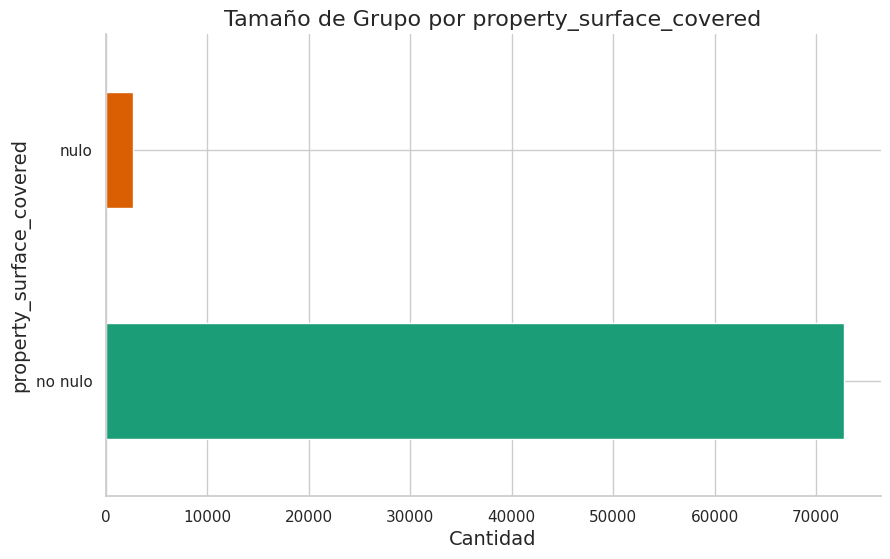

In [1190]:
generar_grafico(sup_total_cubierta,'property_surface_covered')

#### Habitaciones y dormitorios (property_rooms, property_bedrooms)

In [1191]:
# establezco si son o no nulos
habitaciones_dormis = generar_ds_nulo(['property_rooms','property_bedrooms'])
# creo filtro si son o no nulos
v_filtro_hab = filtrar_nulo('property_rooms',habitaciones_dormis)
f_filtro_hab =  filtrar_no_nulo('property_rooms',habitaciones_dormis)

v_filtro_dormis =  filtrar_nulo('property_bedrooms',habitaciones_dormis)
f_filtro_dormis =  filtrar_no_nulo('property_bedrooms',habitaciones_dormis)

# establezco los nulos y no nulos
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,v_filtro_hab,'property_rooms','nulo')
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,f_filtro_hab,'property_rooms','no nulo')

# establezco los nulos y no nulos
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,v_filtro_dormis,'property_bedrooms','nulo')
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,f_filtro_dormis,'property_bedrooms','no nulo')

habitaciones_dormis.head()

property_rooms property_bedrooms
366154        no nulo           no nulo
408027        no nulo           no nulo
142290        no nulo           no nulo
31141         no nulo           no nulo
219179        no nulo           no nulo

In [1192]:
imprimir_cantidades(habitaciones_dormis.value_counts()[1], habitaciones_dormis.value_counts()[0], 'property_rooms')

Cantidad de datos NULOS en property_rooms: 8484
Cantidad de datos NO NULOS en property_rooms: 66077


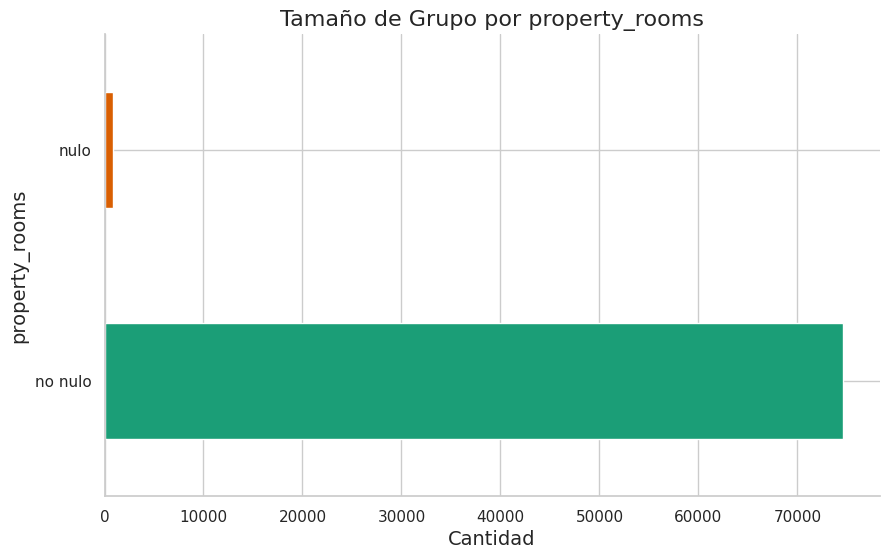

In [1193]:
generar_grafico(habitaciones_dormis,'property_rooms')

In [1194]:
imprimir_cantidades(habitaciones_dormis.value_counts()[1], habitaciones_dormis.value_counts()[0], 'property_bedrooms')

Cantidad de datos NULOS en property_bedrooms: 8484
Cantidad de datos NO NULOS en property_bedrooms: 66077


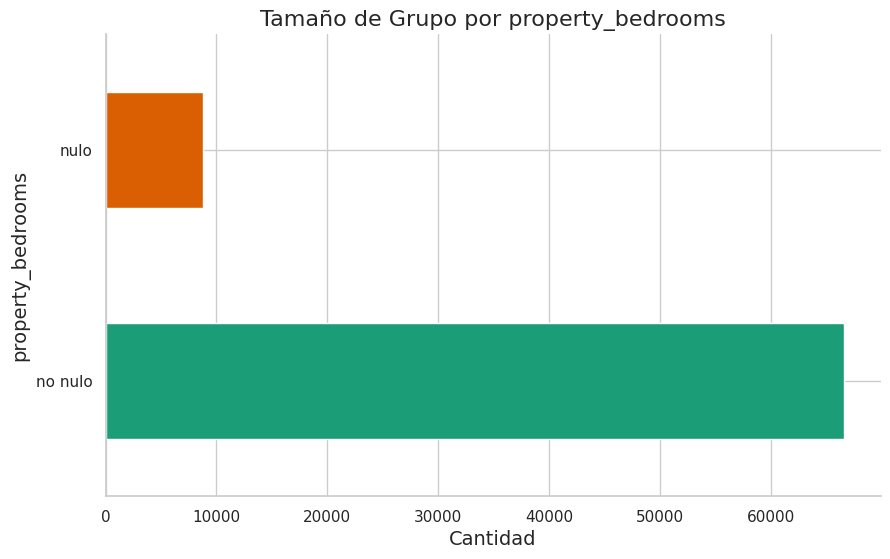

In [1195]:
generar_grafico(habitaciones_dormis,'property_bedrooms')

#### Barrio (place_l3)

In [1196]:
# establezco si son o no nulos
barrio = generar_ds_nulo('place_l3')
# creo filtro si son o no nulos
v_filtro_barrio =  barrio == True
f_filtro_barrio =  barrio == False
# establezco los nulos y no nulos
barrio.loc[v_filtro_barrio] = 'nulo'
barrio.loc[f_filtro_barrio] = 'no nulo'

barrio.head()

366154    no nulo
408027    no nulo
142290    no nulo
31141     no nulo
219179    no nulo
Name: place_l3, dtype: object

In [1197]:
imprimir_cantidades(barrio.value_counts()[1], barrio.value_counts()[0], 'place_l3')

Cantidad de datos NULOS en place_l3: 340
Cantidad de datos NO NULOS en place_l3: 75059


<Axes: title={'center': 'Gráfico de barras: Cantidad de nulos en la variable place_l3'}, xlabel='tipo de dato', ylabel='cantidad de filas'>

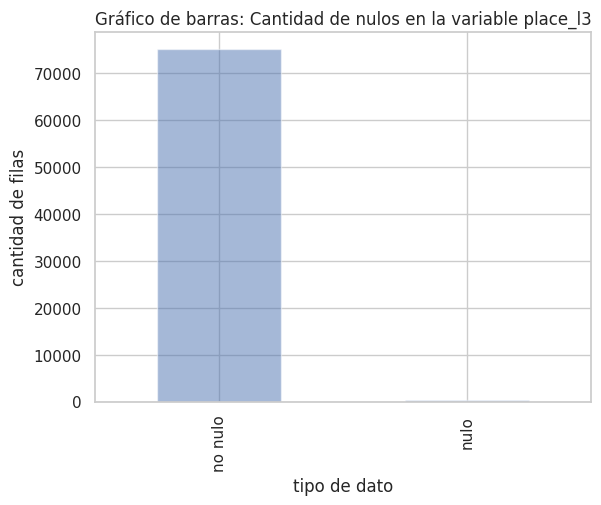

In [1198]:
barrio.value_counts().plot.bar(alpha=0.5,title="Gráfico de barras: Cantidad de nulos en la variable place_l3", xlabel="tipo de dato" , ylabel="cantidad de filas")

#### Precio

In [1199]:
precio = generar_ds_nulo('property_price')
# creo filtro si son o no nulos
v_filtro_precio =  precio == True
f_filtro_precio =  precio == False
# establezco los nulos y no nulos
precio.loc[v_filtro_precio] = 'nulo'
precio.loc[f_filtro_precio] = 'no nulo'

precio.head()

366154    no nulo
408027    no nulo
142290    no nulo
31141     no nulo
219179    no nulo
Name: property_price, dtype: object

In [1200]:
print("Cantidad de datos NO NULOS en property_price: {}".format(precio.value_counts()))

Cantidad de datos NO NULOS en property_price: property_price
no nulo    75399
Name: count, dtype: int64


<Axes: title={'center': 'Gráfico de barras: Cantidad de nulos en la variable property_price'}, xlabel='tipo de dato', ylabel='cantidad de filas'>

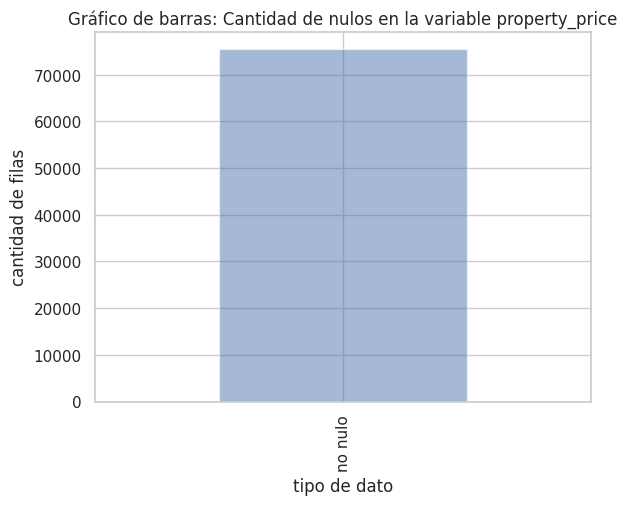

In [1201]:
precio.value_counts().plot.bar(alpha=0.5,title="Gráfico de barras: Cantidad de nulos en la variable property_price", xlabel="tipo de dato" , ylabel="cantidad de filas")

### Análisis de datos faltantes a nivel fila

Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de datos
faltantes de cada registro. Realizar un gráfico que permita conocer la proporción de
faltantes por fila en el dataset.


In [1202]:
# Calcular la cantidad de filas nulas
cantidad_filas_nulas = ds_train.isna().sum(axis=1)
filtro = cantidad_filas_nulas > 0
cantidad_filas_nulas = cantidad_filas_nulas[filtro]
print("La cantidad de filas que tienen al menos un dato nulo es: ",len(cantidad_filas_nulas))

La cantidad de filas que tienen al menos un dato nulo es:  17051


<Axes: title={'center': 'Gráfico de barras: Cantidad de filas nulas en ds_train'}, xlabel='cantidad de nulos', ylabel='cantidad de filas'>

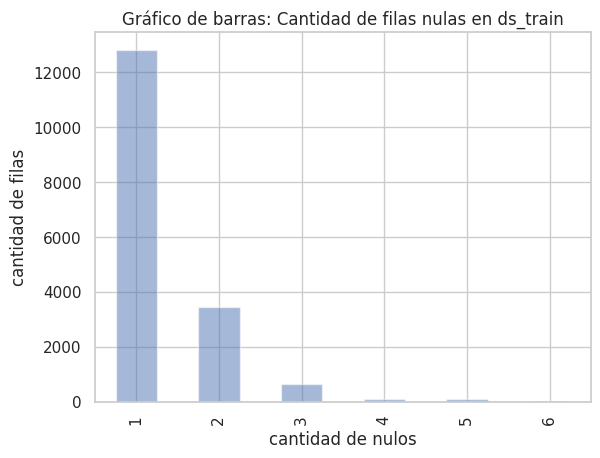

In [1203]:
cantidad_filas_nulas.value_counts().plot.bar(alpha=0.5,title="Gráfico de barras: Cantidad de filas nulas en ds_train", xlabel="cantidad de nulos" , ylabel="cantidad de filas")

### Revisión de datos faltantes o mal ingresados

Revisar los datos faltantes o mal ingresados y tomar una decisión sobre estos: reemplazo de
valores, eliminación de registros incompletos, etc.

Recordemos los datos nulos que tenemos en ds_train

In [1204]:
obtener_cantidad_nulos(ds_train)

property_bedrooms           11.693789
property_surface_total       5.042507
latitud                      3.891298
longitud                     3.891298
property_surface_covered     3.567687
property_rooms               1.111421
place_l3                     0.450934
dtype: float64

Veremos unas de las estrategias para para trabajar con datos faltantes. Procederemos a imputar datos

#### Imputación Cold Deck
Vamos a trabajar con los datos ```latitud``` y ```longitud``` para completar la variable ```place_l3```.
Para ello vamos a utilizar el csv ```barrios.csv``` provisto por [GCBA](https://data.buenosaires.gob.ar/dataset/barrios/resource/juqdkmgo-191-resource) que nos da la localización y límites geográficos de los barrios de la Ciudad.

Antes de imputar vamos a hacer una copia para analizar la imputación en el siguiente punto.

In [1205]:
ds_pre_imputacion = ds_train.copy()

Para ello vamos a usar Geopandas correspondiente a la documentación wkt

In [1206]:
ds_barrios = pd.read_csv(barrios_file, header=0,sep=';')
def completar_barrios(ds):
  for index, propiedad in ds.iterrows():
    if isinstance(propiedad["place_l3"], str):
      continue

    for index,barrio in ds_barrios.iterrows():
      barrio_aux = barrio['BARRIO']
      if barrio_aux == '' or barrio_aux is None:
        continue
      coordenada = Point(propiedad['longitud'],propiedad['latitud'])
      # uso wkt Para deserializar una cadena y obtener un nuevo objeto geométrico del tipo apropiado
      # uso covers para ver si está cubierta la coordenada de ds_barrios por lo que tiene mi ds
      if wkt.loads(barrio['WKT']).covers(coordenada):
        ds.loc[index,'place_l3'] = barrio_aux

  return

completar_barrios(ds_train)
completar_barrios(ds_test)

Visualizamos el dataset para ver si podemos ver algún nulo rápido.

In [1207]:
# Ordenar el DataFrame por 'place_l3'
ds_train_sorted = ds_train.sort_values(by='place_l3')

# Extraer la columna 'place_l3'
place_l3_column = ds_train_sorted['place_l3']

# Elimino la columna 'place_l3' del DataFrame
ds_train_sorted.drop(columns=['place_l3'], inplace=True)

# Inserto la columna 'place_l3' en la primera posición
ds_train_sorted.insert(0, 'place_l3', place_l3_column)

# Ahora ds_train_sorted tiene 'place_l3' como la primera columna
# para visualizarlo mejor
ds_train_sorted

place_l3                        id  start_date    end_date created_on  \
4       ALMAGRO                       NaN         NaN         NaN        NaT   
124254   Abasto  5Q6nXiafJSPEG7kxYwpOvA==  2021-11-26  2021-12-04 2021-11-26   
262661   Abasto  AXFwDG3r91XDQZIh706tuA==  2021-11-20  2021-12-16 2021-11-20   
307707   Abasto  ZWrWXU2AAbHYhcI5Msd6iA==  2021-01-28  2022-03-29 2021-01-28   
87712    Abasto  5X/L9RBJ3wk7cbiQNcVNbA==  2021-11-11  2022-01-27 2021-11-11   
...         ...                       ...         ...         ...        ...   
353890      NaN  Ny+JYCM/wTJo9XNSgIv6rw==  2021-11-04  2022-02-19 2021-11-04   
458696      NaN  UxrImoZVU0nEah53uM/NSg==  2021-01-05  2021-03-01 2021-01-05   
45532       NaN  XdZsZLmbXUPzQFsMs6J4dA==  2021-05-02  2021-06-05 2021-05-02   
358077      NaN  wmC/iDXdmQtR4vYq4kzdvQ==  2021-06-29  2021-08-24 2021-06-29   
39238       NaN  3BcwF2I3NzKXZRjhFa46Vw==  2021-07-30  9999-12-31 2021-07-30   

          latitud   longitud property_type  property_rooms  property_bedrooms  \
4             NaN        NaN           NaN             NaN                NaN   
124254 -34.603787 -58.414353  Departamento             3.0                2.0   
262661 -34.606479 -58.412082  Departamento             2.0                1.0   
307707 -34.603043 -58.415155  Departamento             1.0                NaN   
87712  -34.583950 -58.446388  Departamento             1.0                1.0   
...           ...        ...           ...             ...                ...   
353890        NaN        NaN  Departamento             1.0                NaN   
458696        NaN        NaN          Casa             NaN                2.0   
45532  -31.369084 -64.584422          Casa             3.0                2.0   
358077        NaN        NaN  Departamento             2.0                1.0   
39238         NaN        NaN  Departamento             4.0                3.0   

        property_surface_total  property_surface_covered  property_price  
4                          NaN                       NaN             NaN  
124254                    49.0                      46.0         87000.0  
262661                    38.0                      38.0         52000.0  
307707                    44.0                      41.0         90300.0  
87712                     27.0                      25.0         53000.0  
...                        ...                       ...             ...  
353890                    34.0                      34.0        115000.0  
458696                    60.0                      60.0         75000.0  
45532                    300.0                      70.0         58000.0  
358077                    35.0                      28.0         68000.0  
39238                     73.0                      73.0        148000.0  

[75417 rows x 13 columns]

Vemos que hay datos NaN en el barrio

In [1208]:
ds_train['place_l3'].isna().value_counts()

place_l3
False    75077
True       340
Name: count, dtype: int64

Estos datos en NaN pueden ser datos mal ingresados. Se ingresó mal la coordenada de la propiedad y se la clasificó como Capital Federal. Lo mismo puede suceder de que no tengan latitud ni longitud. Procedo a eliminar dichos datos

In [1209]:
columnas_a_eliminar = ['latitud','longitud','place_l3']
ds_train = ds_train.dropna(subset=columnas_a_eliminar)
ds_test =  ds_test.dropna(subset=columnas_a_eliminar)

Verifico mis datos_nulos en mi dataset

In [1210]:
obtener_cantidad_nulos(ds_train)

property_bedrooms           11.599297
property_surface_total       4.944439
property_surface_covered     3.535696
property_rooms               0.965916
dtype: float64

#### Análisis de property's
Ahora vamos a seguir con el análisis de las siguientes variables:
*     property_bedrooms
*     property_rooms
*     property_surface_total
*     property_surface_covered

Podemos identificar que estas variables son tipos de datos faltantes MAR.

##### Análisis de ceros

Para empezar verifico si alguno de estos datos es negativo. Pues valores negativos para alguno de estos atributos no tiene sentido.

In [1211]:
columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered']
(ds_train[columnas_con_numeros] <= 0).any().to_frame("Menor o igual que 0 ?")

Menor o igual que 0 ?
property_bedrooms                          True
property_rooms                            False
property_surface_total                    False
property_surface_covered                  False

Vemos que existen valores menores o iguales que 0 en el atributo ```property_bedrooms```. Procedo a ver cuantos registros cumplen con esta condición.

In [1212]:
filtro = ds_propiedades_filtradas['property_bedrooms'] < 1
ds_propiedades_filtradas[filtro]

id  start_date    end_date  created_on  \
406880  3WI+zCCMeb9TR5kOBm7rhg==  2021-01-07  2021-03-18  2021-01-07   

          latitud   longitud         place_l2       place_l3 place_l4  \
406880 -34.577595 -58.495185  Capital Federal  Villa Urquiza      NaN   

       place_l5  place_l6 operation property_type  property_rooms  \
406880      NaN       NaN     Venta  Departamento             2.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
406880               -1.0                    61.0                      43.0   

        property_price property_currency  \
406880        125000.0               USD   

                                           property_title  
406880  Jardines de Roosevelt - Hermoso 3 ambientes co...

Como hay un registro, procederemos a asignarlo nulo.

In [1213]:
ds_train.loc[ds_train['property_bedrooms'] < 1,'property_bedrooms'] = np.nan

Se verifica si hay valores menores o iguales que cero.

In [1214]:
columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered']
(ds_train[columnas_con_numeros] <= 0).any().to_frame("Menor o igual que 0 ?")

Menor o igual que 0 ?
property_bedrooms                         False
property_rooms                            False
property_surface_total                    False
property_surface_covered                  False

Se realiza el mismo análisis con ds_test

In [1215]:
columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered']
(ds_test[columnas_con_numeros] <= 0).any().to_frame("Menor o igual que 0 ?")

Menor o igual que 0 ?
property_bedrooms                         False
property_rooms                            False
property_surface_total                    False
property_surface_covered                  False

##### Análisis de duplicados

Verificamos si hay datos duplicados en estas columnas

In [1216]:
ds_train[ds_train.duplicated(keep=False)]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [1217]:
ds_test[ds_test.duplicated(keep=False)]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

Procederemos a eliminar filas duplicadas

In [1218]:
size_antes = len(ds_train)
ds_train_filtrado = ds_train.drop_duplicates()
size_despues = len(ds_train_filtrado)
print(f"Se eliminaron: {size_antes-size_despues} filas duplicadas de ds_train")

Se eliminaron: 0 filas duplicadas de ds_train


In [1219]:
ds_train_filtrado.reset_index(drop=True, inplace=True)

In [1220]:
size_antes = len(ds_test)
ds_test_filtrado = ds_test.drop_duplicates()
size_despues = len(ds_test_filtrado)
print(f"Se eliminaron: {size_antes-size_despues} filas duplicadas de ds_test")

Se eliminaron: 0 filas duplicadas de ds_test


In [1221]:
ds_test_filtrado.reset_index(drop=True, inplace=True)

##### Completacion de las columnas de forma multivariada

Como las variables faltantes son datos de tipo MAR (Missing At Random), elijiremos el proceso de imputación de datos MICE (Multivariate Imputation by Chained Equations)

In [1222]:
# la variable columnas_con_numeros tiene las columnas a analizar
lr = LinearRegression()
imp = IterativeImputer(
    estimator=lr,
    missing_values = np.nan,
    max_iter = 20,
    verbose = 0,
    random_state = 0,
    min_value = 1
)


def rellenar_variables(ds,columnas):
  df_eliminar_nans_op3_completo = ds[columnas].copy()
  ds[columnas] = imp.fit_transform(df_eliminar_nans_op3_completo)

rellenar_variables(ds_train,columnas_con_numeros)
rellenar_variables(ds_test,columnas_con_numeros)

ds_train[columnas_con_numeros] = ds_train[columnas_con_numeros].round()
ds_test[columnas_con_numeros] = ds_test[columnas_con_numeros].round()


<ipython-input-1222-2db52bbdb419>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-1222-2db52bbdb419>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-1222-2db52bbdb419>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-1

In [1223]:
obtener_promedio_nulos(ds_train)

id                          0.0
start_date                  0.0
end_date                    0.0
created_on                  0.0
latitud                     0.0
longitud                    0.0
place_l3                    0.0
property_type               0.0
property_rooms              0.0
property_bedrooms           0.0
property_surface_total      0.0
property_surface_covered    0.0
property_price              0.0
dtype: float64

In [1224]:
obtener_cantidad_nulos(ds_train)

'No existen valores NaN'

### Comparación de distribuciones
En caso de realizar imputaciones comparar las distribuciones de cada atributo reparado con
la distribución anterior a la imputación de los datos faltantes.

Para ello veamos nuestro ```ds_pre_imputacion```

In [1225]:
ds_pre_imputacion.head()

id  start_date    end_date created_on  \
366154  Ab/aN6T8Mna0dAIe9hPIpA==  2021-04-10  2021-06-05 2021-04-10   
408027  MzDpszQ1Zx3SGERGycYoSw==  2021-03-05  2021-03-09 2021-03-05   
142290  Axqbmsbzc9JHXG5S0xW0fg==  2021-03-10  2021-05-06 2021-03-10   
31141   ds5G1c/HVhlxBxwWAGvn3Q==  2021-03-29  2021-04-15 2021-03-29   
219179  DuRHdE5YZY2gPv3gNbtB3Q==  2021-10-23  2021-11-03 2021-10-23   

          latitud   longitud       place_l3 property_type  property_rooms  \
366154 -34.558977 -58.458816       Belgrano  Departamento             3.0   
408027 -34.551437 -58.454158          Nuñez  Departamento             2.0   
142290 -34.638146 -58.509707     Villa Luro  Departamento             3.0   
31141  -34.585703 -58.418339        Palermo  Departamento             4.0   
219179 -34.568861 -58.505879  Villa Urquiza            PH             5.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
366154                2.0                    78.0                      71.0   
408027                1.0                    38.0                      38.0   
142290                2.0                    54.0                      54.0   
31141                 3.0                     NaN                     100.0   
219179                4.0                   273.0                     137.0   

        property_price  
366154        152000.0  
408027        116000.0  
142290         82000.0  
31141         260000.0  
219179        235000.0

Recordemos que datos imputamos

In [1226]:
nulos_preimputacion

property_bedrooms           11.693789
property_surface_total       5.042507
latitud                      3.891298
longitud                     3.891298
property_surface_covered     3.567687
property_rooms               1.111421
place_l3                     0.450934
dtype: float64

In [1227]:
nulos_preimputacion.index.tolist()

['property_bedrooms',
 'property_surface_total',
 'latitud',
 'longitud',
 'property_surface_covered',
 'property_rooms',
 'place_l3']

Para ver la distribuciones de las variables imputadas vamos a utilizar un gráfico de distribución continua BoxPlot. El cual nos va a ayudar a visualizar la distribución de los datos y la asimetría de los mismos mediante la visualización de cuartiles y promedios de los datos.

#### Funciones de distribución

In [1228]:
def generar_distribucion(variable):
  # Configuración de estilo y colores
  sns.set(style="whitegrid")
  sns.set_palette("pastel")

  # Creo la cuadrícula de subgráficos con una fila y dos columnas
  fig, axes = plt.subplots(1, 2, figsize=(12, 12))

  # Genero boxplot para ds_pre_imputacion en el primer subgráfico
  sns.boxplot(y=variable, data=ds_pre_imputacion, ax=axes[0], width=0.5)
  axes[0].set_title("Boxplot {} pre-imputación".format(variable), fontsize=14)
  axes[0].set_ylabel("Valor", fontsize=12)
  axes[0].set_xlabel("", fontsize=12)

  # Genero boxplot para ds_train en el segundo subgráfico
  sns.boxplot(y=variable, data=ds_train, ax=axes[1], width=0.5)
  axes[1].set_title("Boxplot {} post-imputación".format(variable), fontsize=14)
  axes[1].set_ylabel("Valor", fontsize=12)
  axes[1].set_xlabel("", fontsize=12)

  # Ajusto el diseño
  plt.tight_layout()

  plt.show()

  return

In [1229]:
def generar_distribucion_zoom(variable):
  fig, axes = plt.subplots(1, 2, figsize=(12, 12))

  # Genero boxplot para ds_pre_imputacion en el primer subgráfico
  sns.boxplot(y=variable, data=ds_pre_imputacion, ax=axes[0])
  axes[0].set_title("Boxplot {} pre-imputacion".format(variable))
  axes[0].set_ylim(0, 10)  # Ajustar el rango del eje y

  # Genero boxplot para ds_train en el segundo subgráfico
  sns.boxplot(y=variable, data=ds_train, ax=axes[1])
  axes[1].set_title("Boxplot {} post-imputacion".format(variable))
  axes[1].set_ylim(0, 10)  # Ajustar el rango del eje y

  # Ajustar el diseño
  plt.tight_layout()

  plt.show()
  return

In [1230]:
def obtener_cantidad_variables(ds,columna):
  analisis = ds[columna].value_counts().reset_index()
  analisis.columns = [columna, 'cantidad']
  return analisis

In [1231]:
def comparar_imputacion(pre, post, columna):
    longitud_post = len(post)
    longitud_pre = len(pre)

    for i in range(longitud_post):
        # Verificar si i es mayor que la longitud de pre
        if i >= longitud_pre:
            print("i es mayor que la longitud de pre. Se corta el bucle.")
            break

        registros_imputados = post['cantidad'][i] - pre['cantidad'][i]
        registros_imputados = abs(registros_imputados)  # Tomar el valor absoluto
        print("{} registros se imputaron con el valor de {} {}".format(registros_imputados, post[columna][i], columna))

    return

#### Comparación property_bedrooms

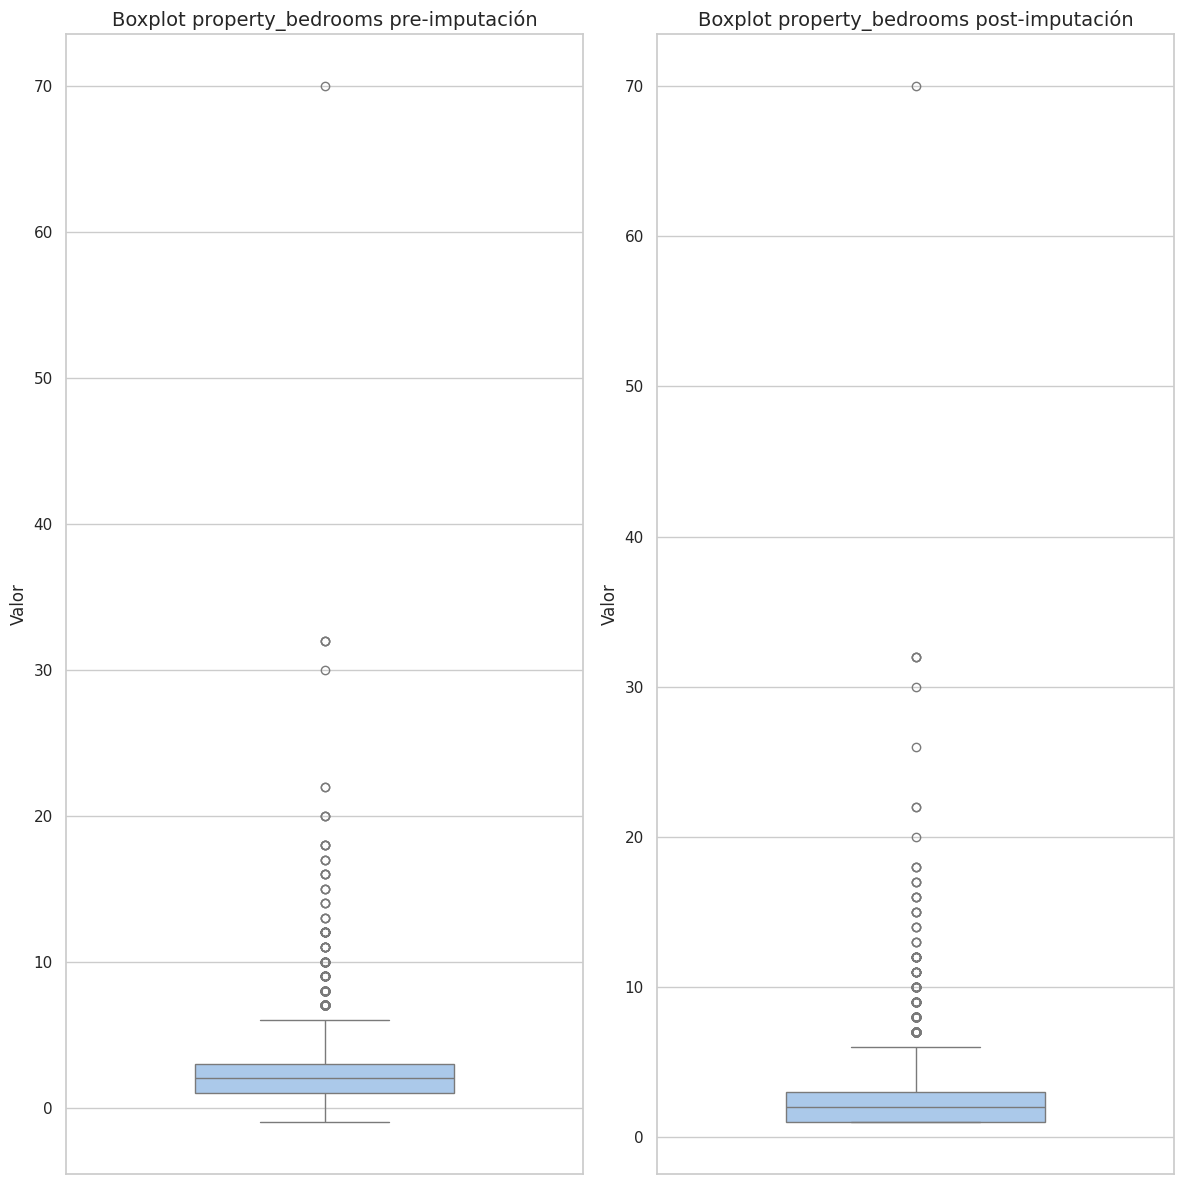

In [1232]:
generar_distribucion("property_bedrooms")

Un poco de zoom

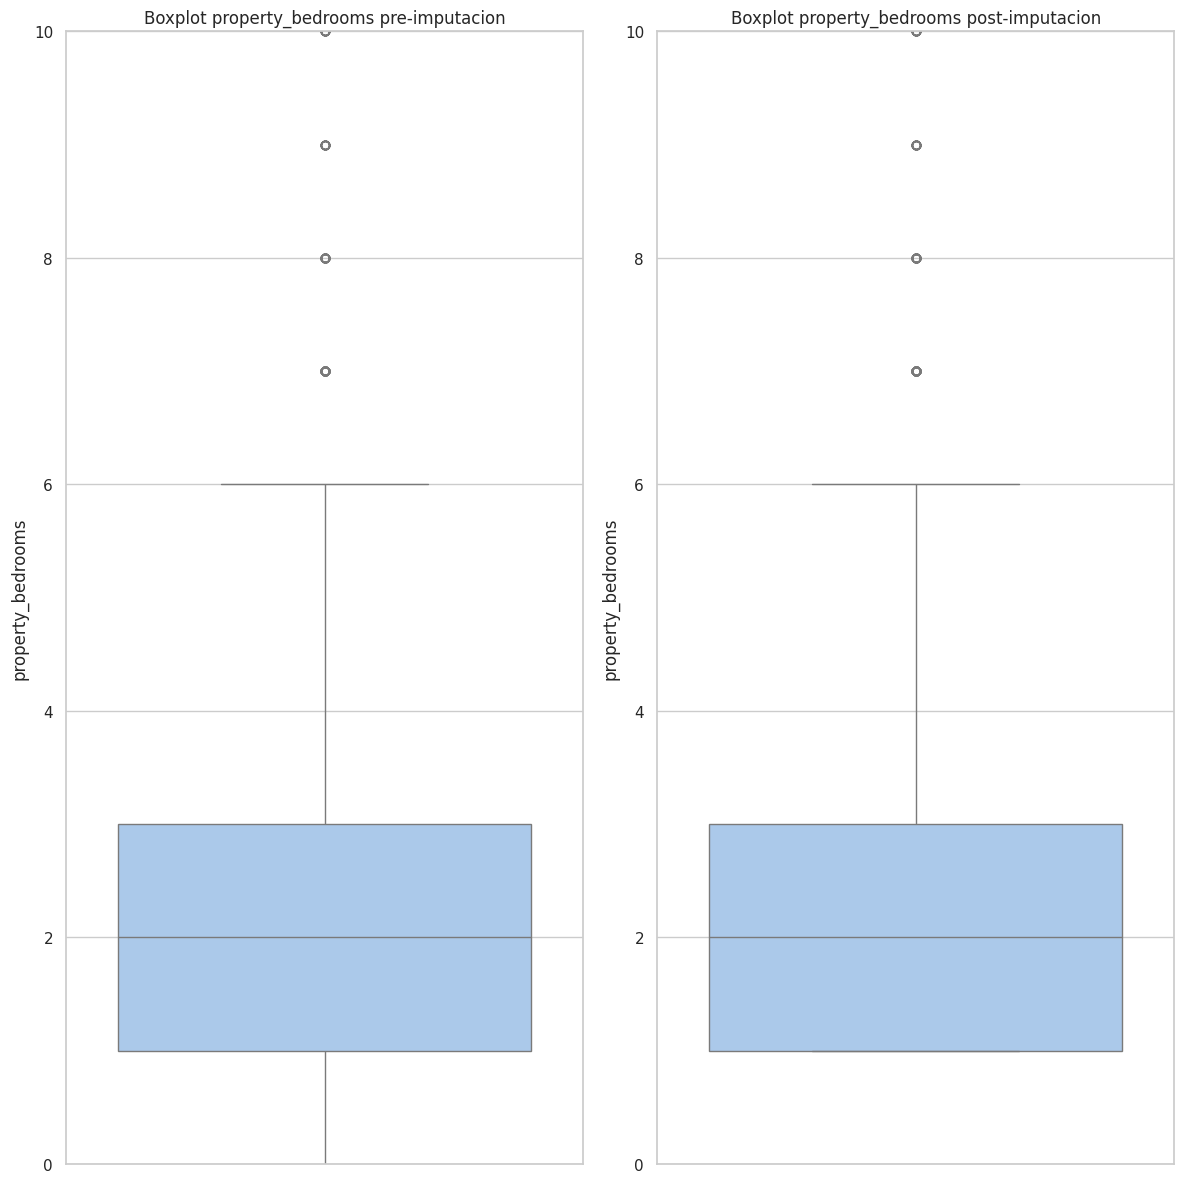

In [1233]:
generar_distribucion_zoom("property_bedrooms")

La comparación de los boxplots revela una gran coherencia en la distribución de la variable entre los conjuntos de datos antes y después de la imputación. Aunque se observa una discrepancia leve entre los valores de aproximadamente 20 y 30, esta diferencia es mínima en comparación con la totalidad de los datos. Esto sugiere que las imputaciones se realizaron de manera consistente y dentro de los límites razonables de la variable, sin introducir valores atípicos o extremos.

Vamos a analizar cada property_bedrooms

In [1234]:
pre_bedrooms = obtener_cantidad_variables(ds_pre_imputacion,'property_bedrooms')
pre_bedrooms.head()

property_bedrooms  cantidad
0                1.0     25532
1                2.0     22006
2                3.0     13986
3                4.0      3901
4                5.0       736

In [1235]:
post_bedrooms = obtener_cantidad_variables(ds_train,'property_bedrooms')
post_bedrooms.head()

property_bedrooms  cantidad
0                1.0     32245
1                2.0     21680
2                3.0     13511
3                4.0      3714
4                5.0       690

Con esto podemos ver la cantidad de imputaciones que se hicieron gracias al método MICE.

In [1236]:
comparar_imputacion(pre_bedrooms,post_bedrooms,'property_bedrooms')

6713 registros se imputaron con el valor de 1.0 property_bedrooms
326 registros se imputaron con el valor de 2.0 property_bedrooms
475 registros se imputaron con el valor de 3.0 property_bedrooms
187 registros se imputaron con el valor de 4.0 property_bedrooms
46 registros se imputaron con el valor de 5.0 property_bedrooms
9 registros se imputaron con el valor de 6.0 property_bedrooms
5 registros se imputaron con el valor de 7.0 property_bedrooms
1 registros se imputaron con el valor de 8.0 property_bedrooms
2 registros se imputaron con el valor de 9.0 property_bedrooms
2 registros se imputaron con el valor de 10.0 property_bedrooms
1 registros se imputaron con el valor de 12.0 property_bedrooms
2 registros se imputaron con el valor de 11.0 property_bedrooms
0 registros se imputaron con el valor de 15.0 property_bedrooms
0 registros se imputaron con el valor de 16.0 property_bedrooms
0 registros se imputaron con el valor de 17.0 property_bedrooms
0 registros se imputaron con el valor d

Podemos concluir que la mayoría de los datos nulos en la variable property_bedrooms fueron llenados con la cantidad de un dormitorio

#### Comparación property_rooms

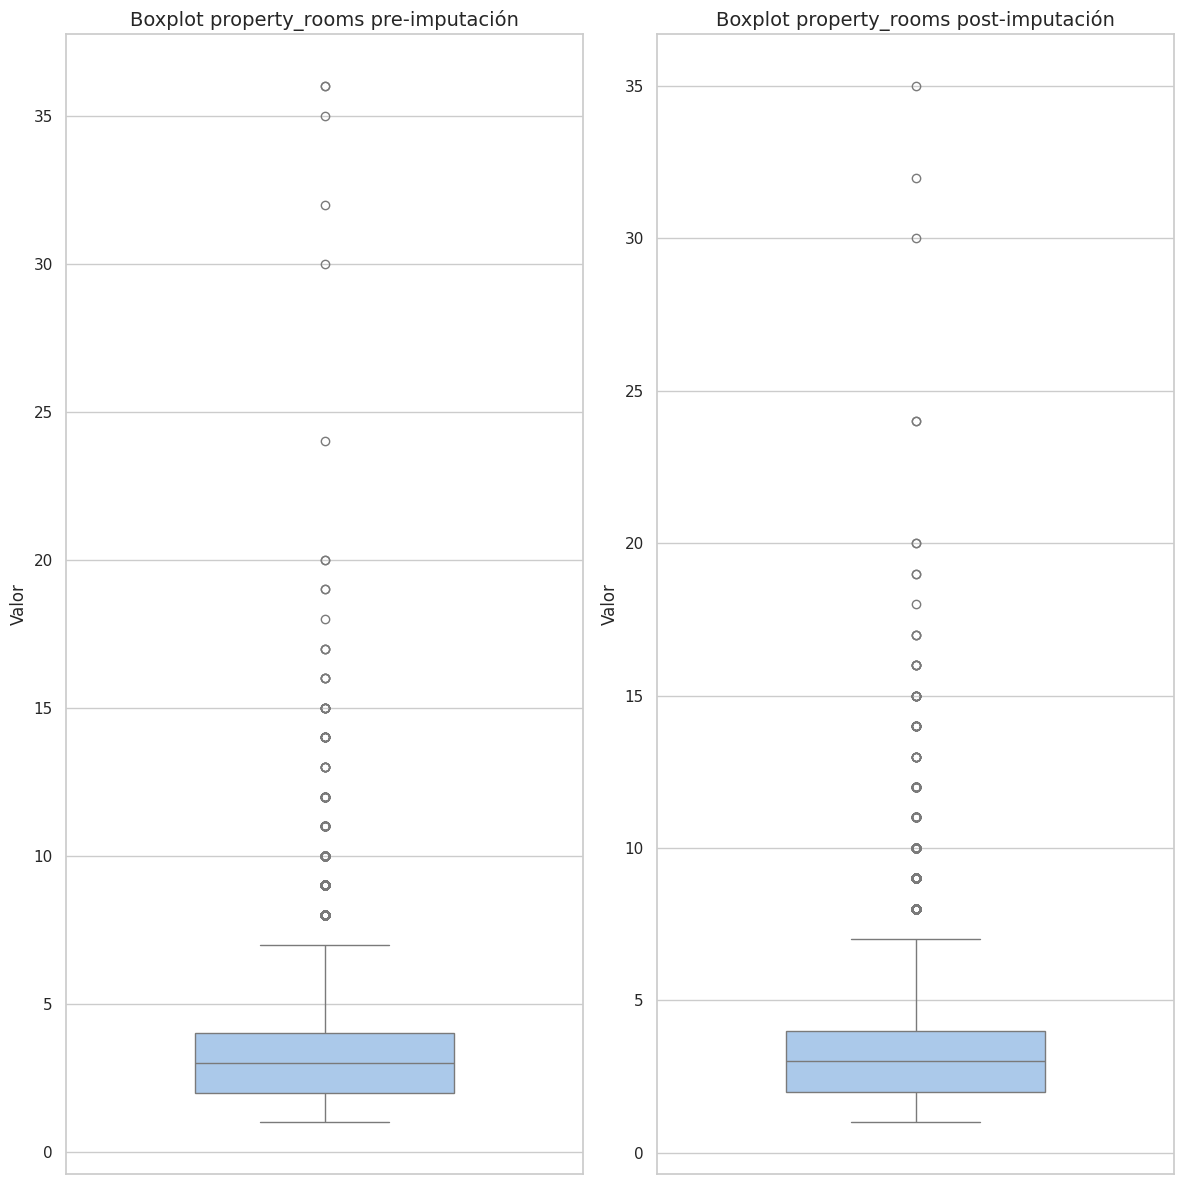

In [1237]:
generar_distribucion("property_rooms")

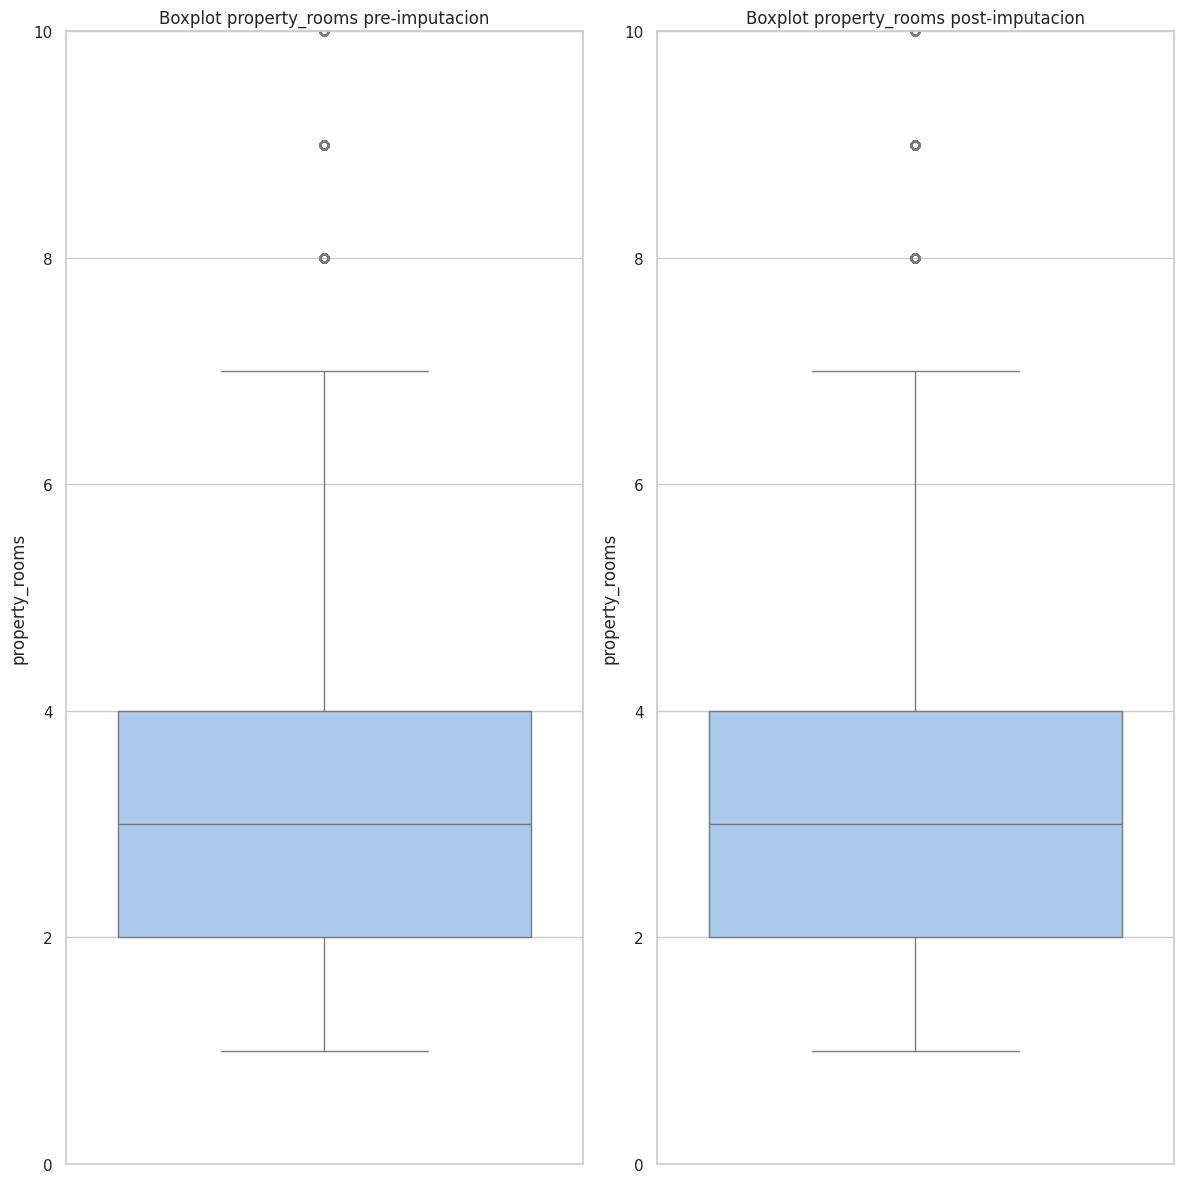

In [1238]:
generar_distribucion_zoom("property_rooms")

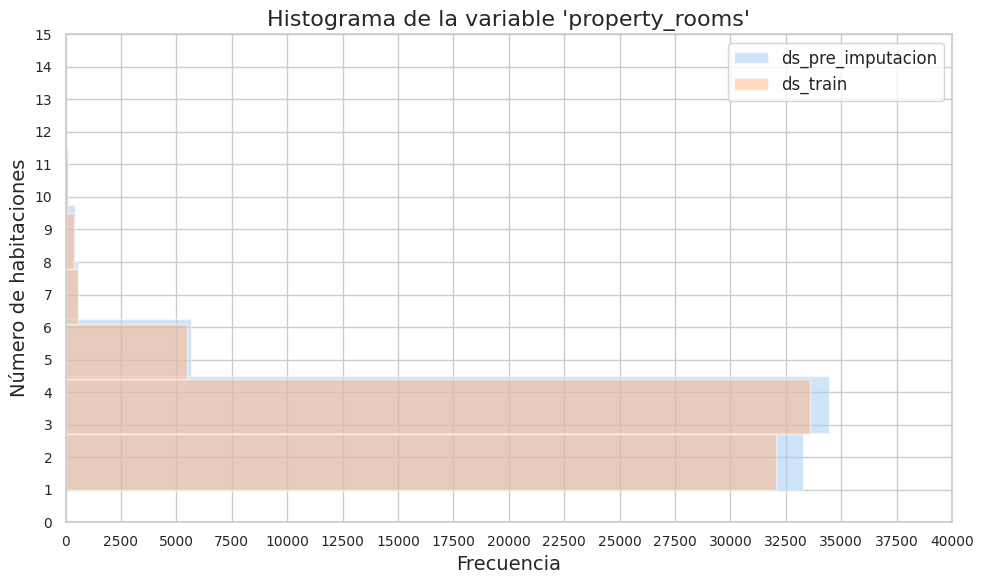

In [1239]:
# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear la figura y los ejes
plt.figure(figsize=(10, 6))

# Histograma para ds_pre_imputacion en el eje y (invertido)
plt.hist(ds_pre_imputacion['property_rooms'], bins=20, alpha=0.5, orientation='horizontal', label='ds_pre_imputacion')

# Histograma para ds_train en el eje y (invertido)
plt.hist(ds_train['property_rooms'], bins=20, alpha=0.5, orientation='horizontal', label='ds_train')

# Ajustes de título y etiquetas
plt.title("Histograma de la variable 'property_rooms'", fontsize=16)
plt.xlabel("Frecuencia", fontsize=14)
plt.ylabel("Número de habitaciones", fontsize=14)

# Ajustes de límites de los ejes (zoom)
plt.ylim(0, 15)
plt.xlim(0, 40000)

# Establecer intervalos del eje x
plt.xticks(np.arange(0, 40001, 2500), fontsize=10)

# Añadir leyenda
plt.legend(fontsize=12)

# Establecer intervalos del eje y
plt.yticks(np.arange(16), fontsize=10)

plt.tight_layout()
plt.show()

<Axes: xlabel='property_rooms'>

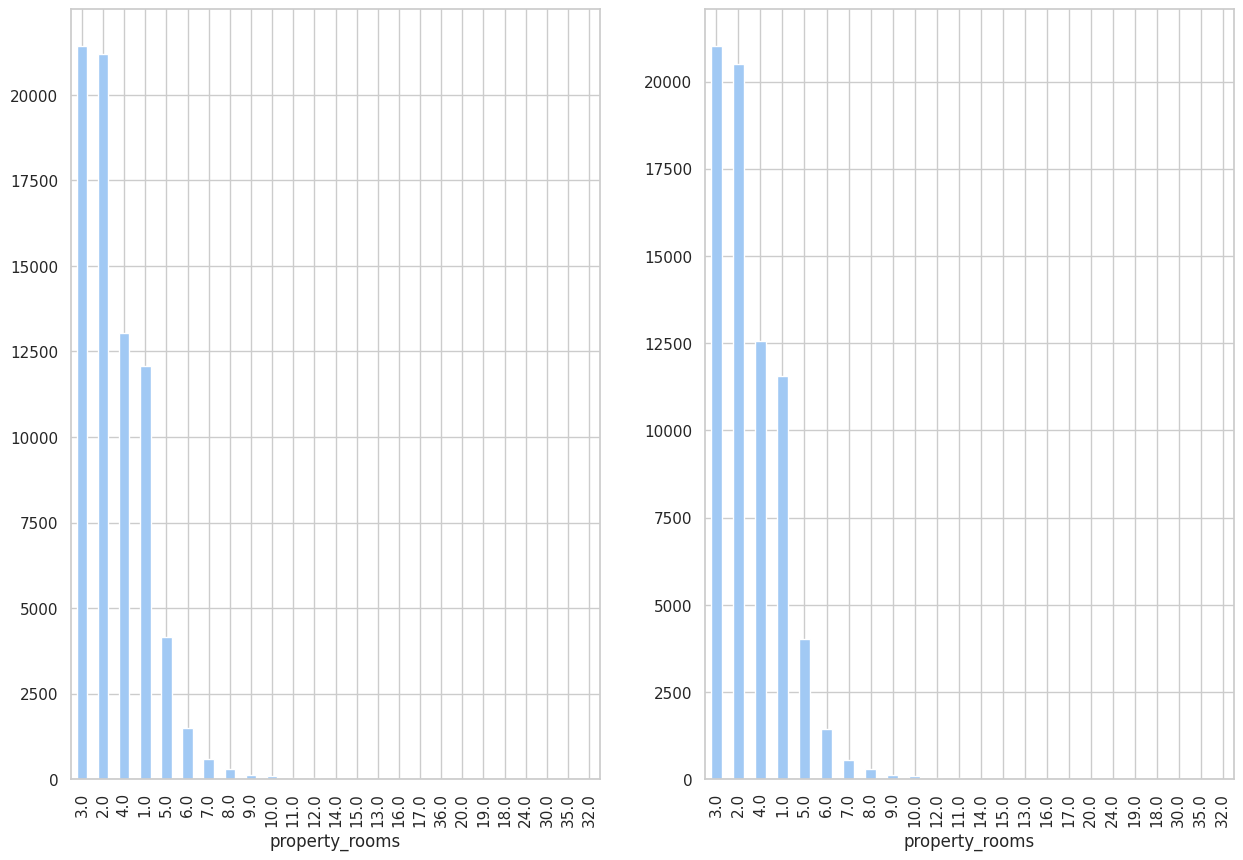

In [1240]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
ds_pre_imputacion["property_rooms"].value_counts().plot.bar(ax=axes[0])
ds_train["property_rooms"].round().value_counts().plot.bar(ax=axes[1])

A través de estos gráficos, se observan sutiles discrepancias al asignar la cantidad de habitaciones a la hora de realizar la imputación.

In [1241]:
pre_rooms = obtener_cantidad_variables(ds_pre_imputacion,'property_rooms')
pre_rooms.head()

property_rooms  cantidad
0             3.0     21428
1             2.0     21182
2             4.0     13029
3             1.0     12087
4             5.0      4156

In [1242]:
post_rooms = obtener_cantidad_variables(ds_train,'property_rooms')
post_rooms.head()

property_rooms  cantidad
0             3.0     21021
1             2.0     20502
2             4.0     12555
3             1.0     11563
4             5.0      4029

In [1243]:
comparar_imputacion(pre_rooms,post_rooms,'property_rooms')

407 registros se imputaron con el valor de 3.0 property_rooms
680 registros se imputaron con el valor de 2.0 property_rooms
474 registros se imputaron con el valor de 4.0 property_rooms
524 registros se imputaron con el valor de 1.0 property_rooms
127 registros se imputaron con el valor de 5.0 property_rooms
70 registros se imputaron con el valor de 6.0 property_rooms
24 registros se imputaron con el valor de 7.0 property_rooms
4 registros se imputaron con el valor de 8.0 property_rooms
2 registros se imputaron con el valor de 9.0 property_rooms
2 registros se imputaron con el valor de 10.0 property_rooms
4 registros se imputaron con el valor de 12.0 property_rooms
7 registros se imputaron con el valor de 11.0 property_rooms
2 registros se imputaron con el valor de 14.0 property_rooms
1 registros se imputaron con el valor de 15.0 property_rooms
2 registros se imputaron con el valor de 13.0 property_rooms
1 registros se imputaron con el valor de 16.0 property_rooms
0 registros se imputa

Podemos inferir que la mayoría de los valores faltantes en la variable "property_rooms" fueron sustituidos por la cantidad de dos habitaciones.

#### Comparación property_surface_total

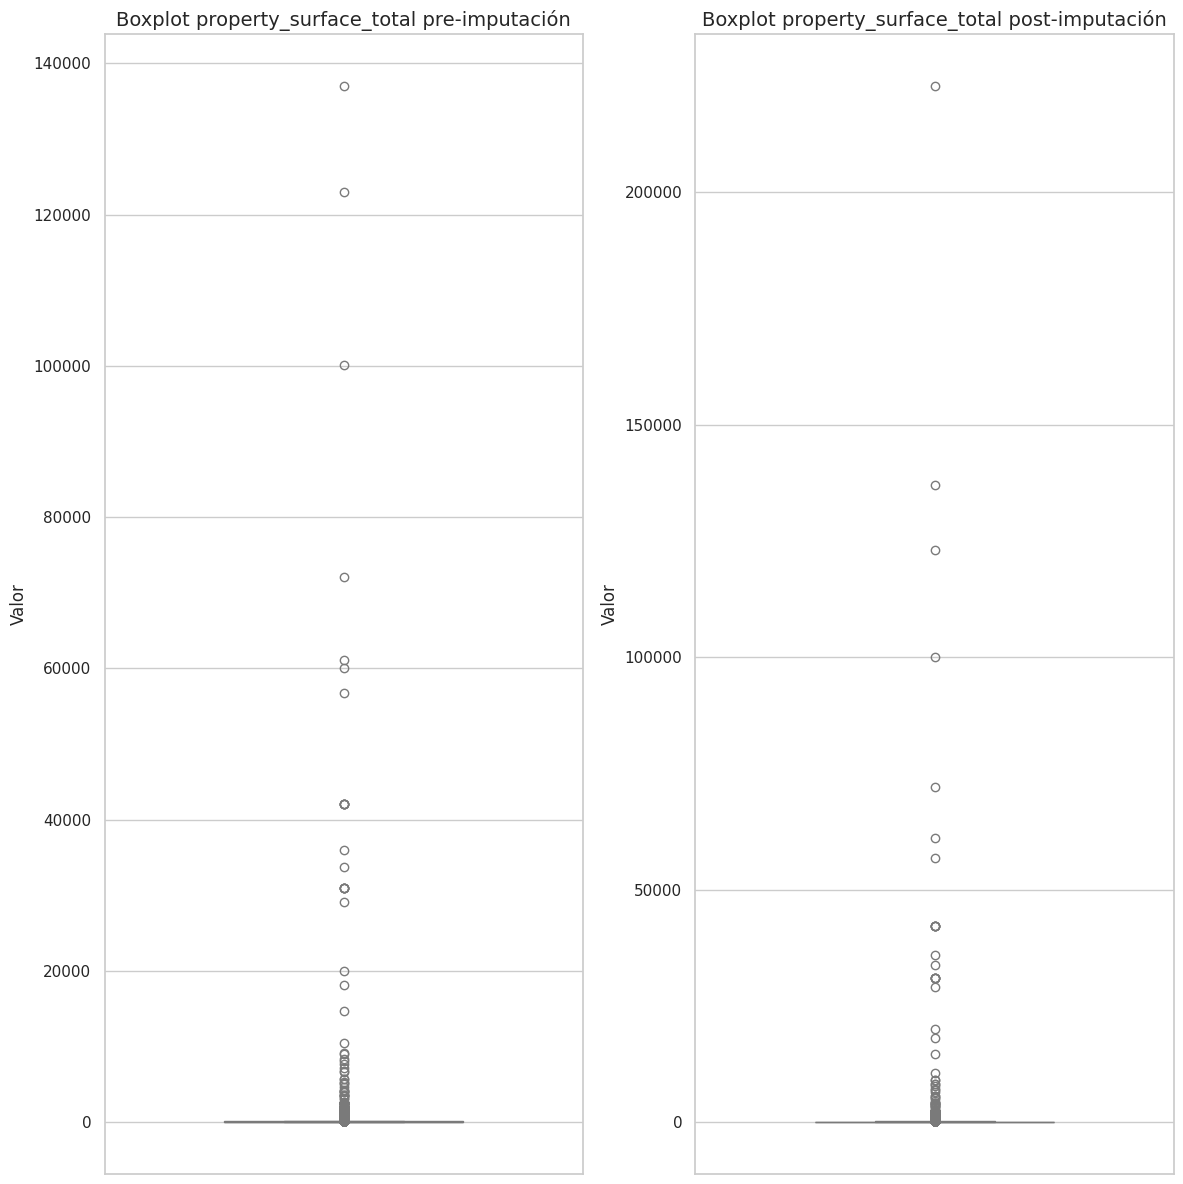

In [1244]:
generar_distribucion("property_surface_total")

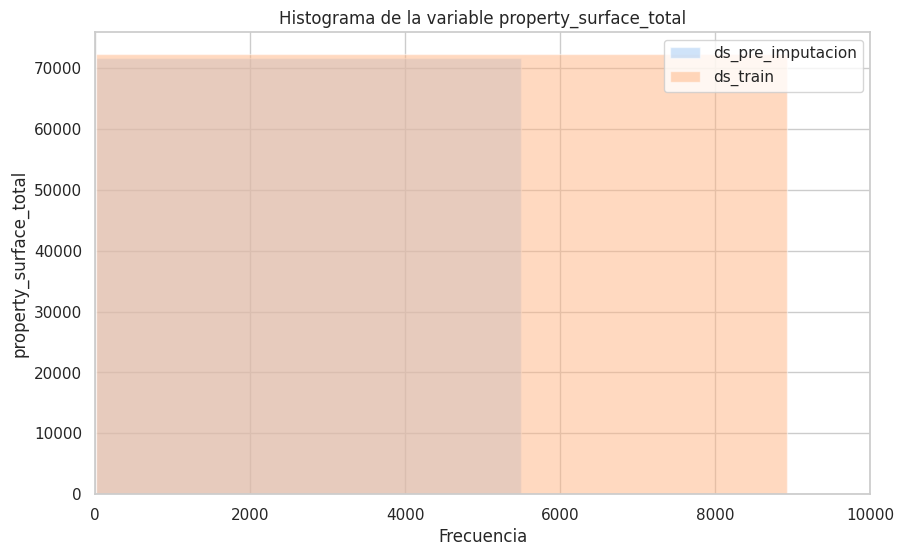

In [1245]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['property_surface_total'], bins=25, alpha=0.5, label='ds_pre_imputacion')

plt.hist(ds_train['property_surface_total'], bins=25, alpha=0.5, label='ds_train')

plt.title("Histograma de la variable property_surface_total")
plt.xlabel("Frecuencia")
plt.ylabel("property_surface_total")

plt.xlim(0, 10000)

plt.legend()

plt.show()

Observamos una notable disparidad en la cantidad de datos faltantes antes de la imputación de la variable "superficie total".

In [1246]:
pre_total = obtener_cantidad_variables(ds_pre_imputacion,'property_surface_total')
pre_total.head()

property_surface_total  cantidad
0                    50.0      1429
1                    40.0      1406
2                    45.0      1247
3                    60.0      1239
4                    42.0      1236

In [1247]:
post_total = obtener_cantidad_variables(ds_train,'property_surface_total')
post_total.head()

property_surface_total  cantidad
0                    50.0      1395
1                    40.0      1386
2                    45.0      1268
3                    60.0      1225
4                    42.0      1211

In [1248]:
comparar_imputacion(pre_total,post_total,'property_surface_total')

34 registros se imputaron con el valor de 50.0 property_surface_total
20 registros se imputaron con el valor de 40.0 property_surface_total
21 registros se imputaron con el valor de 45.0 property_surface_total
14 registros se imputaron con el valor de 60.0 property_surface_total
25 registros se imputaron con el valor de 42.0 property_surface_total
36 registros se imputaron con el valor de 35.0 property_surface_total
33 registros se imputaron con el valor de 38.0 property_surface_total
46 registros se imputaron con el valor de 55.0 property_surface_total
2 registros se imputaron con el valor de 43.0 property_surface_total
1 registros se imputaron con el valor de 44.0 property_surface_total
26 registros se imputaron con el valor de 36.0 property_surface_total
4 registros se imputaron con el valor de 37.0 property_surface_total
15 registros se imputaron con el valor de 48.0 property_surface_total
2 registros se imputaron con el valor de 46.0 property_surface_total
3 registros se imputaron

Podemos concluir que la mayoría de los valores faltantes en la variable "property_surface_total" fueron reemplazados con una superficie total de 49 m²


#### Comparación property_surface_covered

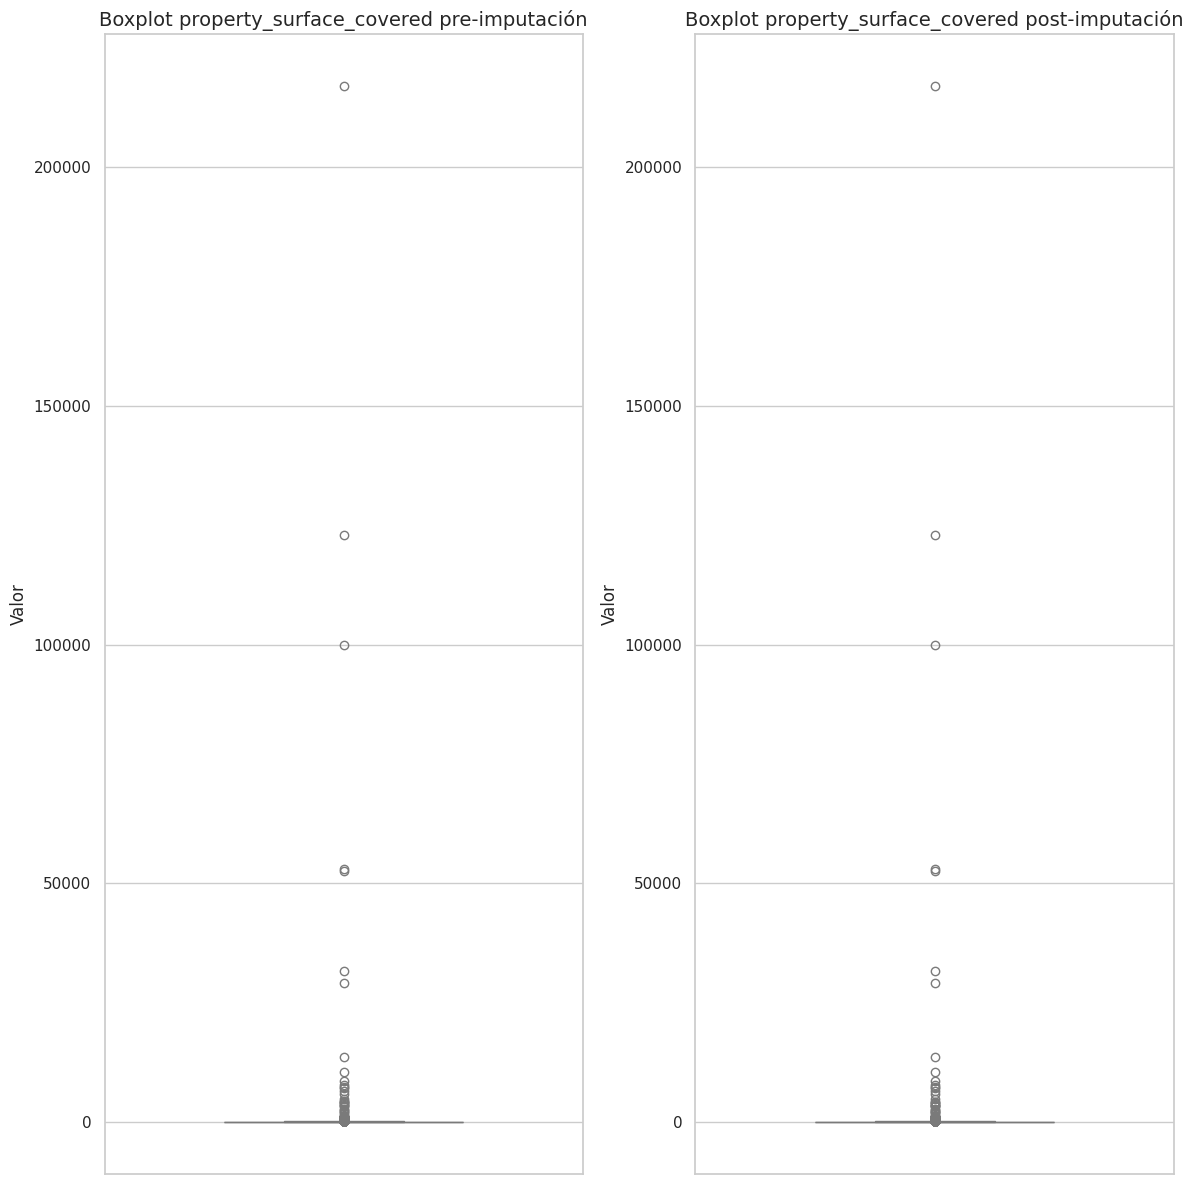

In [1249]:
generar_distribucion("property_surface_covered")

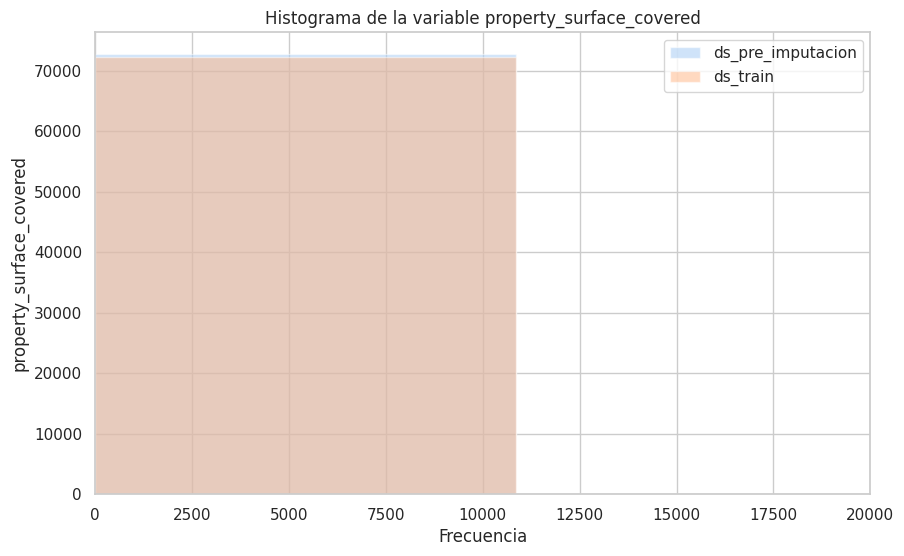

In [1250]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['property_surface_covered'], bins=20, alpha=0.5,  label='ds_pre_imputacion')

plt.hist(ds_train['property_surface_covered'], bins=20, alpha=0.5,  label='ds_train')


plt.title("Histograma de la variable property_surface_covered")
plt.xlabel("Frecuencia")
plt.ylabel("property_surface_covered")


plt.xlim(0,20000)

plt.legend()

plt.show()

Se observa una ligera disparidad en los datos faltantes. Se puede inferir que se imputaron pocos datos para la variable "property_surface_covered", ya que esta variable tenía entre los menos valores nulos.

In [1251]:
pre_cubierto = obtener_cantidad_variables(ds_pre_imputacion,'property_surface_covered')
pre_cubierto.head()

property_surface_covered  cantidad
0                      40.0      1931
1                      38.0      1607
2                      50.0      1588
3                      45.0      1546
4                      35.0      1501

In [1252]:
post_cubierto = obtener_cantidad_variables(ds_train,'property_surface_covered')
post_cubierto.head()

property_surface_covered  cantidad
0                      40.0      1923
1                      38.0      1580
2                      50.0      1558
3                      45.0      1496
4                      35.0      1469

In [1253]:
comparar_imputacion(pre_cubierto,post_cubierto,'property_surface_covered')

8 registros se imputaron con el valor de 40.0 property_surface_covered
27 registros se imputaron con el valor de 38.0 property_surface_covered
30 registros se imputaron con el valor de 50.0 property_surface_covered
50 registros se imputaron con el valor de 45.0 property_surface_covered
32 registros se imputaron con el valor de 35.0 property_surface_covered
29 registros se imputaron con el valor de 42.0 property_surface_covered
6 registros se imputaron con el valor de 60.0 property_surface_covered
8 registros se imputaron con el valor de 37.0 property_surface_covered
28 registros se imputaron con el valor de 36.0 property_surface_covered
30 registros se imputaron con el valor de 32.0 property_surface_covered
11 registros se imputaron con el valor de 30.0 property_surface_covered
5 registros se imputaron con el valor de 33.0 property_surface_covered
11 registros se imputaron con el valor de 34.0 property_surface_covered
14 registros se imputaron con el valor de 43.0 property_surface_cove

Podemos concluir que la mayoría de los valores faltantes en la variable "property_surface_covered" fueron completados con una superficie cubierta de 32 m²

#### Comparación latitud

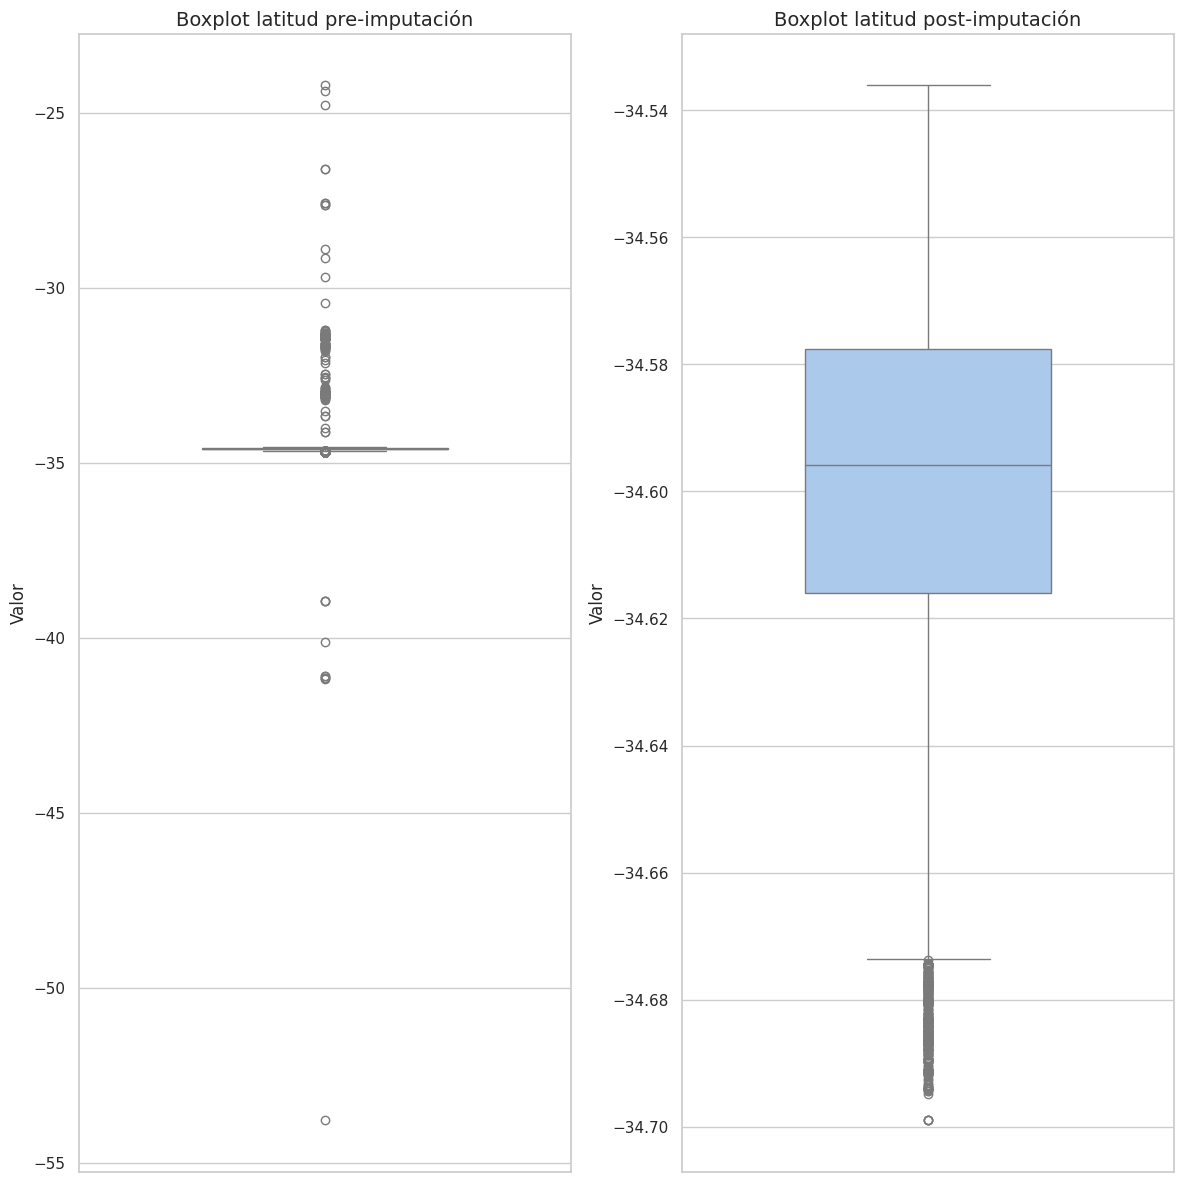

In [1254]:
generar_distribucion("latitud")

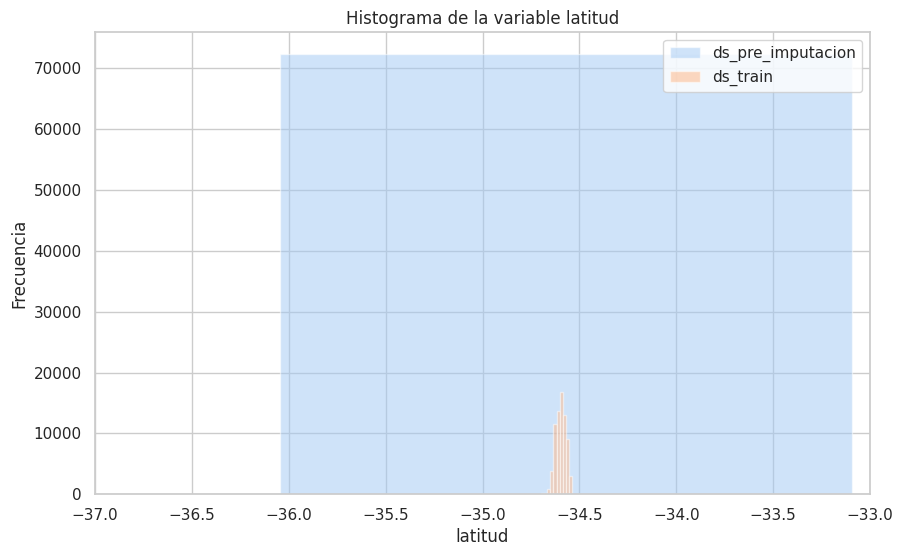

In [1255]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['latitud'], bins=10, alpha=0.5, label='ds_pre_imputacion')

plt.hist(ds_train['latitud'], bins=10, alpha=0.5, label='ds_train')

plt.xlim(-37, -33)

plt.title("Histograma de la variable latitud")
plt.xlabel("latitud")
plt.ylabel("Frecuencia")

plt.legend()

plt.show()

Se puede observar que antes de la imputación, la latitud tenía una frecuencia constante para todos sus valores. Sin embargo, al imputar los datos, la frecuencia varía más, generando una distribución en forma de campana de Gauss. Se destaca que la latitud aproximada con la máxima cantidad de datos nulos completos es alrededor de -34.58.

In [1256]:
pre_latitud = obtener_cantidad_variables(ds_pre_imputacion,'latitud')
pre_latitud

latitud  cantidad
0     -34.541250       116
1     -34.619406       100
2     -34.604538        92
3     -34.541616        83
4     -34.581910        79
...          ...       ...
39334 -34.581718         1
39335 -34.627448         1
39336 -34.577238         1
39337 -34.593135         1
39338 -34.599866         1

[39339 rows x 2 columns]

In [1257]:
post_latitud = obtener_cantidad_variables(ds_train,'latitud')
post_latitud

latitud  cantidad
0     -34.541250       116
1     -34.619406       100
2     -34.604538        92
3     -34.541616        83
4     -34.581910        79
...          ...       ...
39184 -34.637967         1
39185 -34.569482         1
39186 -34.548730         1
39187 -34.597044         1
39188 -34.599866         1

[39189 rows x 2 columns]

Parecieran ser iguales... pero lo hemos imputado

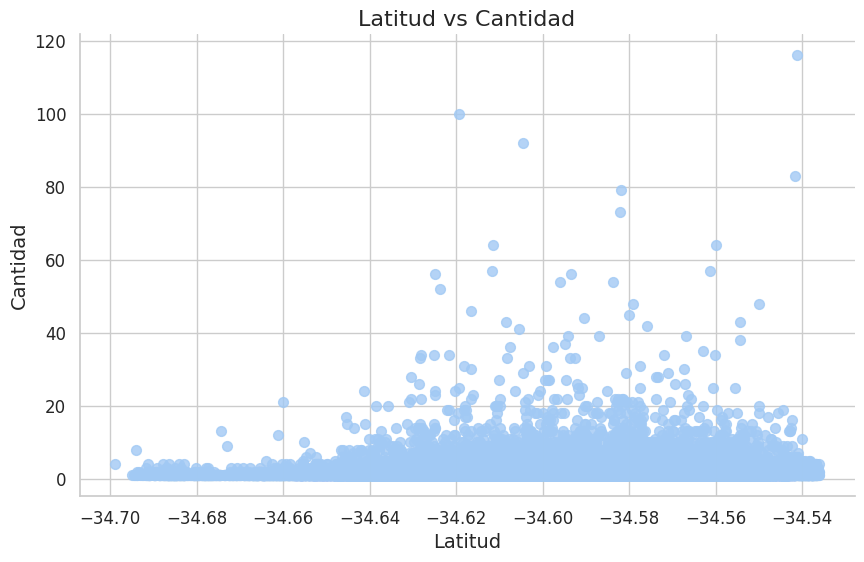

In [1258]:
# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(post_latitud['latitud'], post_latitud['cantidad'], s=50, alpha=0.8)

# Ajustes del título y etiquetas
plt.title("Latitud vs Cantidad", fontsize=16)
plt.xlabel("Latitud", fontsize=14)
plt.ylabel("Cantidad", fontsize=14)

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [1259]:
pre_latitud.equals(post_latitud)

False

In [1260]:
print(len(pre_latitud))
print(len(post_latitud))
print('diferencia: {}'.format(len(pre_latitud)-len(post_latitud)))

39339
39189
diferencia: 150


#### Comparación longitud

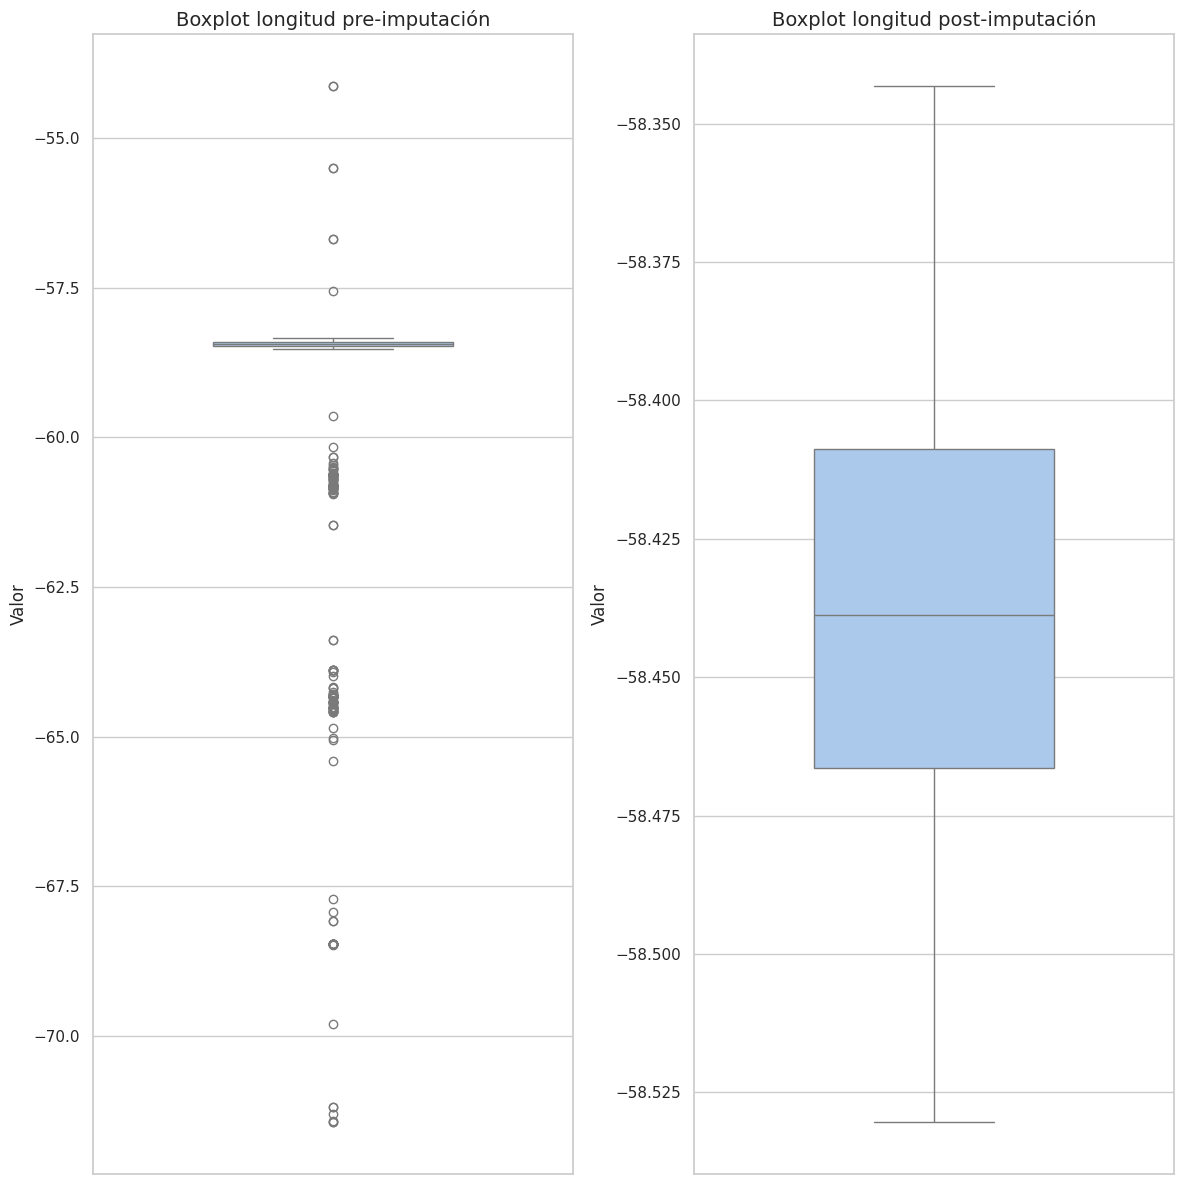

In [1261]:
generar_distribucion("longitud")

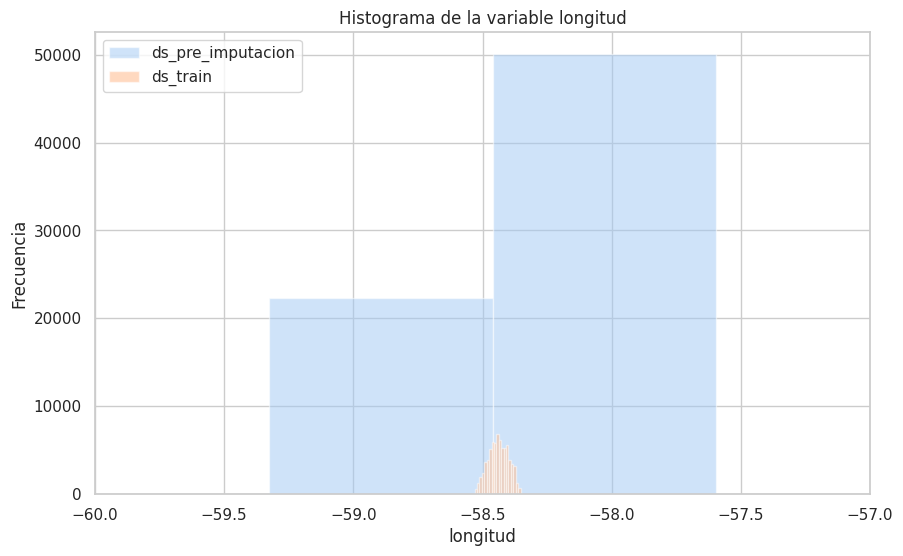

In [1262]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['longitud'], bins=20, alpha=0.5, label='ds_pre_imputacion')

plt.hist(ds_train['longitud'], bins=20, alpha=0.5, label='ds_train')


plt.title("Histograma de la variable longitud")
plt.xlabel("longitud")
plt.ylabel("Frecuencia")

plt.xlim(-60, -57)

plt.legend()

plt.show()

Todos los valores que se mencionarán en el siguiente párrafo se consideran aproximados.

Antes de la imputación, se observa que la latitud tenía una frecuencia medianamente constante. Desde la latitud -59.5 hasta -58.5, la frecuencia es de aproximadamente 18000, luego aumenta en más de 50000 hasta llegar a la latitud -57.5.

Tras la imputación de los datos, se observa una variación en la frecuencia que genera una distribución en forma de campana de Gauss. La latitud aproximada con la máxima cantidad de datos nulos completos es alrededor de -58.400.

In [1263]:
pre_longitud = obtener_cantidad_variables(ds_pre_imputacion,'longitud')
pre_longitud.head()

longitud  cantidad
0 -58.472966       116
1 -58.451999       100
2 -58.424956        92
3 -58.473377        83
4 -58.449381        79

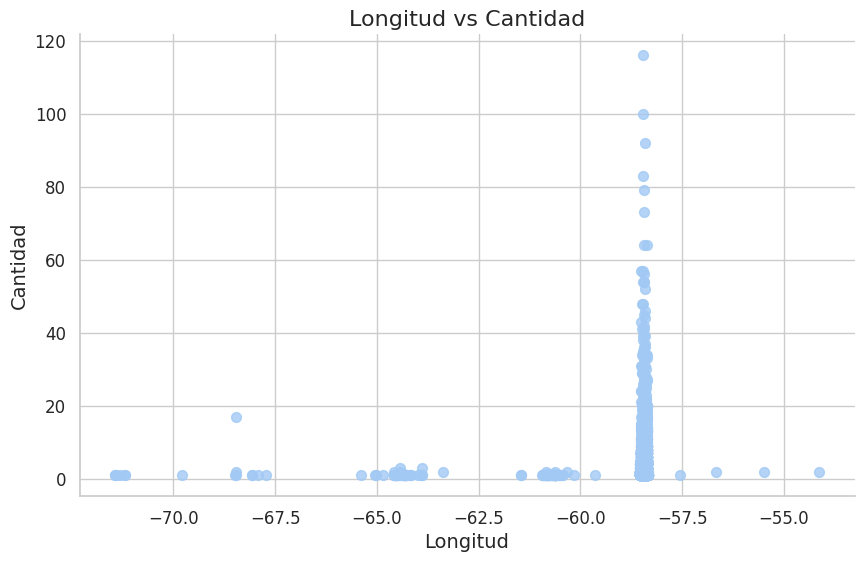

In [1264]:
# @title longitud vs cantidad

# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(pre_longitud['longitud'], pre_longitud['cantidad'], s=50, alpha=0.8)

# Ajustes del título y etiquetas
plt.title("Longitud vs Cantidad", fontsize=16)
plt.xlabel("Longitud", fontsize=14)
plt.ylabel("Cantidad", fontsize=14)

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [1265]:
post_longitud = obtener_cantidad_variables(ds_train,'longitud')
post_longitud.head()

longitud  cantidad
0 -58.472966       116
1 -58.451999       100
2 -58.424956        92
3 -58.473377        83
4 -58.449381        79

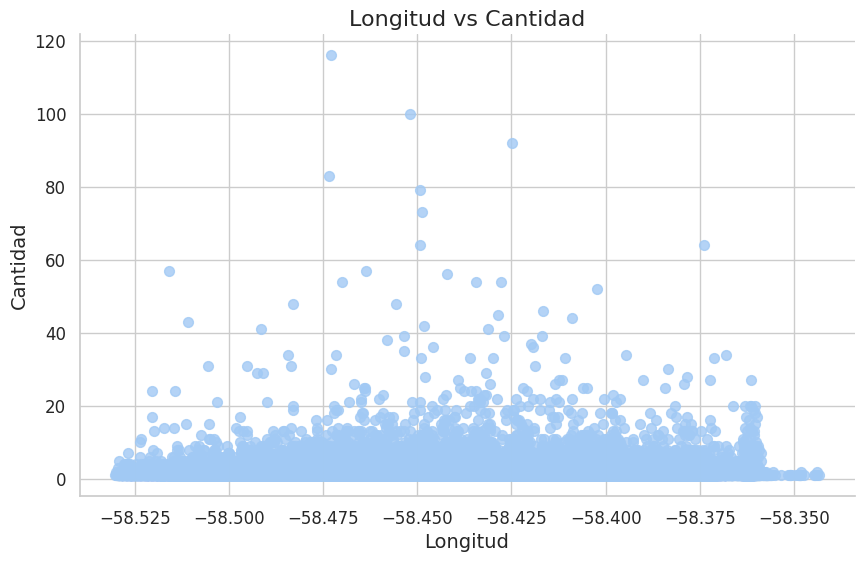

In [1266]:
# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(post_longitud['longitud'], post_longitud['cantidad'], s=50, alpha=0.8)

# Ajustes del título y etiquetas
plt.title("Longitud vs Cantidad", fontsize=16)
plt.xlabel("Longitud", fontsize=14)
plt.ylabel("Cantidad", fontsize=14)

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [1267]:
pre_longitud.equals(post_longitud)

False

In [1268]:
print(len(pre_longitud))
print(len(post_longitud))
print('diferencia: {}'.format(len(pre_longitud)-len(post_longitud)))

39117
38968
diferencia: 149


#### Comparación place_l3

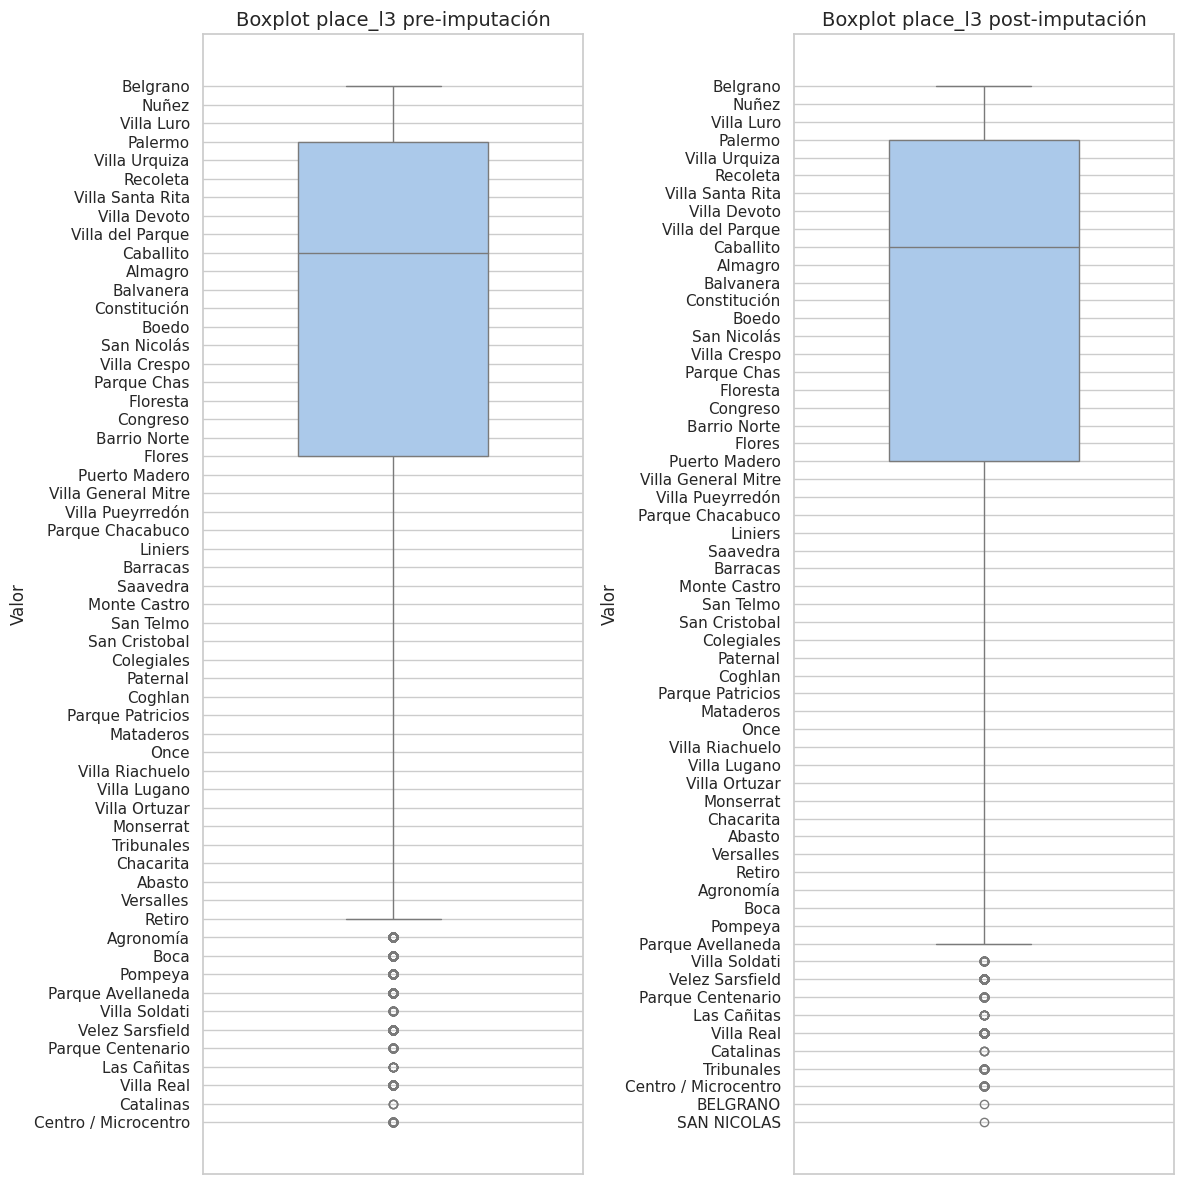

In [1269]:
generar_distribucion("place_l3")

Como los datos nulos en la variable place_l3 era de 0.454913. No se observan grandes cambios en el gráfico.
Podemos notar que la media de Balbanera se mantiene, lo mismo con Villa Devoto y Almagro.

In [1270]:
pre_barrio = obtener_cantidad_variables(ds_pre_imputacion,'place_l3')
pre_barrio.head()

place_l3  cantidad
0        Palermo     11443
1       Belgrano      7101
2      Caballito      5717
3       Recoleta      5056
4  Villa Urquiza      3745

In [1271]:
post_barrio = obtener_cantidad_variables(ds_train,'place_l3')
post_barrio.head()

place_l3  cantidad
0        Palermo     10720
1       Belgrano      6583
2      Caballito      5580
3       Recoleta      4889
4  Villa Urquiza      3623

In [1272]:
comparar_imputacion(pre_barrio,post_barrio,'place_l3')

723 registros se imputaron con el valor de Palermo place_l3
518 registros se imputaron con el valor de Belgrano place_l3
137 registros se imputaron con el valor de Caballito place_l3
167 registros se imputaron con el valor de Recoleta place_l3
122 registros se imputaron con el valor de Villa Urquiza place_l3
126 registros se imputaron con el valor de Almagro place_l3
177 registros se imputaron con el valor de Nuñez place_l3
90 registros se imputaron con el valor de Villa Crespo place_l3
86 registros se imputaron con el valor de Flores place_l3
144 registros se imputaron con el valor de Barrio Norte place_l3
62 registros se imputaron con el valor de Balvanera place_l3
9 registros se imputaron con el valor de Colegiales place_l3
6 registros se imputaron con el valor de Villa Devoto place_l3
8 registros se imputaron con el valor de Villa del Parque place_l3
7 registros se imputaron con el valor de Saavedra place_l3
57 registros se imputaron con el valor de Puerto Madero place_l3
70 regist

Podemos concluir que la mayoría de los valores faltantes en la variable "place_l3" fueron completados con el nombre del barrio "Palermo".

## Valores atípicos

### *Prefacio*

Recordando lo visto en la sección de variables cualitativas en Exploración inicial.

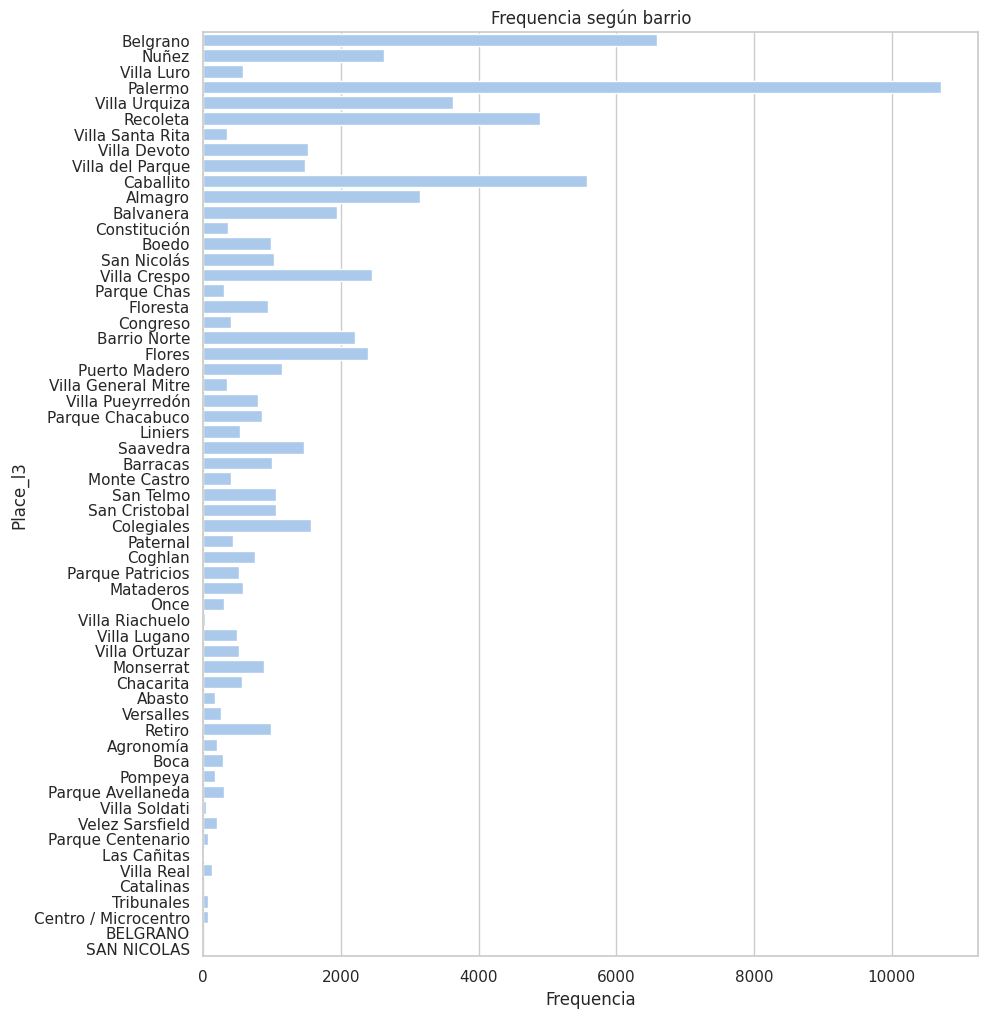

In [1273]:
# Hacemos un gráfico de frecuencias de los barrios
plt.figure(figsize=(10, 12))
sns.countplot(y=ds_train.place_l3)
plt.xlabel('Frequencia')
plt.ylabel('Place_l3')
plt.title('Frequencia según barrio')
plt.show()

Las Cañitas, Catalinas, San Nicolas tienen una representación nula/casi nula.
Villa Soldati, Microcentro, Parque Centenario, Villa Riachuelo, Tribunales tienen una representación tan pequeña que tenemos que tener en cuenta que los registros pueden ser casos aislados/no representativos de la realidad de las ventas de inmuebles en el barrio.

In [1274]:
# Hacemos una copia del dataset hasta el momento
ds_atipicos = ds_train.copy()

Funciones auxiliares para el análisis:



In [1275]:
#Función para cálculo de limite superior e inferior de outliers según cuartiles
def limite_rango_iq(df, variable):
  # Cuartiles
  Q1 = np.quantile(df[variable], 0.25)
  Q3 = np.quantile(df[variable], 0.75)

  # Rango intercuartil
  IQR = Q3 - Q1

  # Limite inferior Outliers
  out_inf = Q1 - 1.5 * IQR

  # Limite superior Outliers
  out_sup = Q1 + 1.5 * IQR

  return out_inf, out_sup

# Funcion para cálculo de Z Score normal
def calculo_z_score(serie):
  media = np.mean(serie)
  std = np.std(serie)
  return (serie - media) / std

#Función para calculo de Z Score modificado
def calculo_z_mod(serie):
  median = np.median(serie)
  MAD = np.median(np.absolute(serie - median))
  return (serie - median) * 0.6745 / MAD

# Grafico comparativo
def plot_comparativo(df_antes, df_despues, var):

  # Create subplots
  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  # Plot for df_antes
  sns.boxplot(y=df_antes[var], ax=axs[0])
  axs[0].set_title('Antes')

  # Plot for df_despues
  sns.boxplot(y=df_despues[var], ax=axs[1])
  axs[1].set_title('Después')

  # Show plots
  plt.tight_layout()
  plt.show()
  return

# Boxplot por barrio de la variable a evaluar
def plot_por_barrio(df, var):
  # Lista de barrios
  barrios = ['Coghlan','Colegiales','Abasto','Nuñez','Constitución',
             'Boedo', 'San Nicolás', 'Retiro', 'Liniers', 'Almagro',
             'Boca', 'Palermo', 'Balvanera','Barracas', 'Caballito',
             'Villa Ortuzar', 'Villa Luro', 'Puerto Madero', 'Pompeya', 'Saavedra',
             'Parque Chacabuco', 'Belgrano', 'Recoleta', 'Floresta', 'Monserrat',
             'Villa del Parque', 'San Telmo', 'Villa Crespo', 'Tribunales', 'Once',
             'Barrio Norte', 'Villa Lugano', 'Congreso', 'Villa Urquiza', 'Mataderos',
             'Villa Devoto', 'Recoleta', 'San Cristobal', 'Villa Pueyrredon', 'Congreso']

  # Subplots
  fig, axs = plt.subplots(8, 5, figsize=(16, 24))
  axs = axs.flatten()

  for i, barrio in enumerate(barrios):
      filtered_data = df[df['place_l3'] == barrio]

      sns.boxplot(y=filtered_data[var], ax=axs[i])

      axs[i].set_title(f'{var} en {barrio}')

  # Adjust layout
  plt.tight_layout()
  # Show the plot
  plt.show()
  return



### Análisis univariado

Vamos a intentar identificar los outliers univariados utilizando los IQR y el Z Score.

#### *Análisis según cantidad de habitaciones(property_bedrooms)*

<Axes: ylabel='property_bedrooms'>

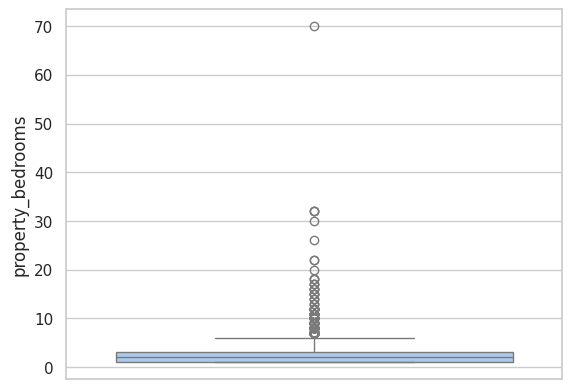

In [1276]:
sns.boxplot(y=ds_train.property_bedrooms)

In [1277]:
limite_rango_iq(ds_train, 'property_bedrooms')

(-2.0, 4.0)

Primero analizamos el outlier más notorio y verificamos si es un valor posible.

In [1278]:
# Observación anómala
outlier = ds_train[ds_train['property_bedrooms'] > 40]
outlier

id  start_date    end_date created_on    latitud  \
94998  4TbEkLoqy/0c3zakd66/FQ==  2021-09-24  2022-01-27 2021-09-24 -34.646632   

        longitud    place_l3 property_type  property_rooms  property_bedrooms  \
94998 -58.497902  Villa Luro  Departamento             3.0               70.0   

       property_surface_total  property_surface_covered  property_price  
94998                   791.0                      70.0        135000.0

Es un departamento de 3 ambientes con 70 habitaciones, lo cual no es posible. Tampoco podemos asumir que es un error de tipeo. A su vez, la superficie total es exagerada en comparación de la superficie cubierta y el precio de la propiedad.  Vamos a eliminar el outlier y visualizar nuevamente el código.  

<ipython-input-1279-a0f165733f40>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: ylabel='property_bedrooms'>

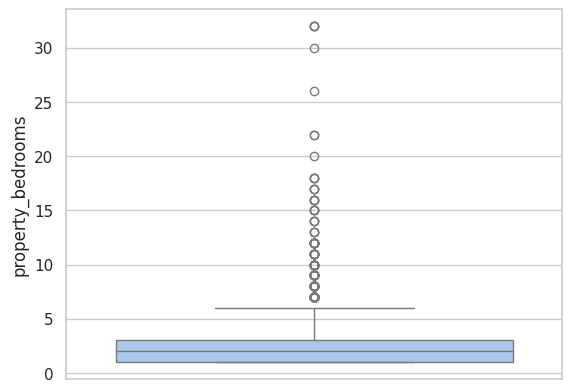

In [1279]:
# Eliminamos outlier por indice
id_outlier = ds_train[ds_train['property_bedrooms'] > 40].index
ds_train.drop(id_outlier,inplace=True)

# Visualizamos
sns.boxplot(y=ds_train.property_bedrooms)

Existen muchos valores atípicos por sobre el umbral marcado por los cuartiles, pero teniendo en cuenta que estamos trabajando con casas, PH y departamentos unicamente, revisaremos las anomalías mayores a 15, a partir de donde no hay muchas ocurrencias.



In [1280]:
# Observación anómala
outlier = ds_train[ds_train['property_bedrooms'] > 15]
outlier

id  start_date    end_date created_on  \
86014   pVG9sES9De/1eQ+tB90NjQ==  2021-03-26  2021-06-05 2021-03-26   
115403  VuF9cBcZ03aoEcEWAsWGjA==  2021-12-07  2022-01-27 2021-12-07   
362676  Gj3g5KCtRbYcwZIuh/wJGg==  2021-01-16  2021-08-06 2021-01-16   
285222  WHu8kgA8Vu692UM8Dz3gnA==  2021-02-24  2022-02-09 2021-02-24   
402448  9OrT+9jZlW4rMGyZYsmNPA==  2021-09-07  2022-02-09 2021-09-07   
208593  CtbHDgBLf3+kTc20y2iVhw==  2021-11-29  2022-01-14 2021-11-29   
307211  uqM9/WXFJkEJnXEQefcpRQ==  2021-09-19  2021-09-19 2021-09-19   
292167  CxZv3EmTnK+m6EJD2uQ5fw==  2021-02-23  2021-03-03 2021-02-23   
346602  yzI9zylc11wllHX16av6jA==  2021-09-30  2021-11-02 2021-09-30   
1932    eQ/SiyES/mXWsSyAzb3k3A==  2021-12-17  9999-12-31 2021-12-17   
48279   r3sXlEIiCgBG5TtUkN93mw==  2021-03-14  2021-06-05 2021-03-14   
140832  2aHER3AXQs3zb3EegLhmgg==  2021-12-08  2022-01-27 2021-12-08   
36421   VoyodCc8rftOZHr4TeYcpw==  2021-09-21  2022-02-03 2021-09-21   
150885  X3WGOe/PrGS1u+xozM5elA==  2021-03-24  2021-06-05 2021-03-24   
362696  KuzGWi8jCNPL9nvKAUqLKw==  2021-01-16  2021-08-06 2021-01-16   
32758   KA441xdi8PtuWBvjcAbGOQ==  2021-02-08  2021-03-01 2021-02-08   
90004   TEs1aRnhJPwR0jRMq/Vzdg==  2021-08-03  9999-12-31 2021-08-03   
49960   O/JMW/VVo7OmWF7SkXtBuA==  2021-10-16  2021-12-24 2021-10-16   

          latitud   longitud          place_l3 property_type  property_rooms  \
86014  -34.591110 -58.400685          Recoleta  Departamento             4.0   
115403 -34.598070 -58.444686      Villa Crespo            PH            17.0   
362676 -34.618485 -58.377993         San Telmo          Casa            16.0   
285222 -34.638432 -58.369712          Barracas            PH            20.0   
402448 -34.611413 -58.389221         Monserrat          Casa            17.0   
208593 -34.629796 -58.363928              Boca            PH            18.0   
307211 -34.611905 -58.382384         Monserrat            PH            15.0   
292167 -34.616487 -58.371596         San Telmo            PH            24.0   
346602 -34.632537 -58.360577              Boca  Departamento            19.0   
1932   -34.637026 -58.426283  Parque Chacabuco          Casa            24.0   
48279  -34.608645 -58.485619  Villa del Parque  Departamento             4.0   
140832 -34.588454 -58.385257          Recoleta  Departamento             5.0   
36421  -34.576061 -58.421289           Palermo  Departamento             3.0   
150885 -34.642037 -58.438995  Parque Chacabuco  Departamento            35.0   
362696 -34.618485 -58.377993         San Telmo  Departamento            16.0   
32758  -34.632698 -58.360514              Boca            PH            19.0   
90004  -34.633236 -58.480313          Floresta            PH            32.0   
49960  -34.630186 -58.389156  Parque Patricios  Departamento             1.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
86014                30.0                   148.0                     138.0   
115403               17.0                   689.0                     598.0   
362676               16.0                  1153.0                     943.0   
285222               17.0                   807.0                     470.0   
402448               16.0                   585.0                     458.0   
208593               17.0                   386.0                     323.0   
307211               16.0                   587.0                     276.0   
292167               22.0                   800.0                     650.0   
346602               18.0                   372.0                     318.0   
1932                 18.0                222836.0                  217000.0   
48279                32.0                    83.0                      75.0   
140832               22.0                   379.0                     144.0   
36421                20.0                   127.0                     117.0   
150885               26.0                    37.0    

Tenemos 230 anomalías. Los casos donde el número de ambientes es razonable, parece error de tipeo. Lo corregimos

In [1281]:
condition = (ds_train['property_bedrooms'] > 15) & (ds_train['property_rooms'] < 10)
ds_train.loc[condition, 'property_surface_covered'] /= 10

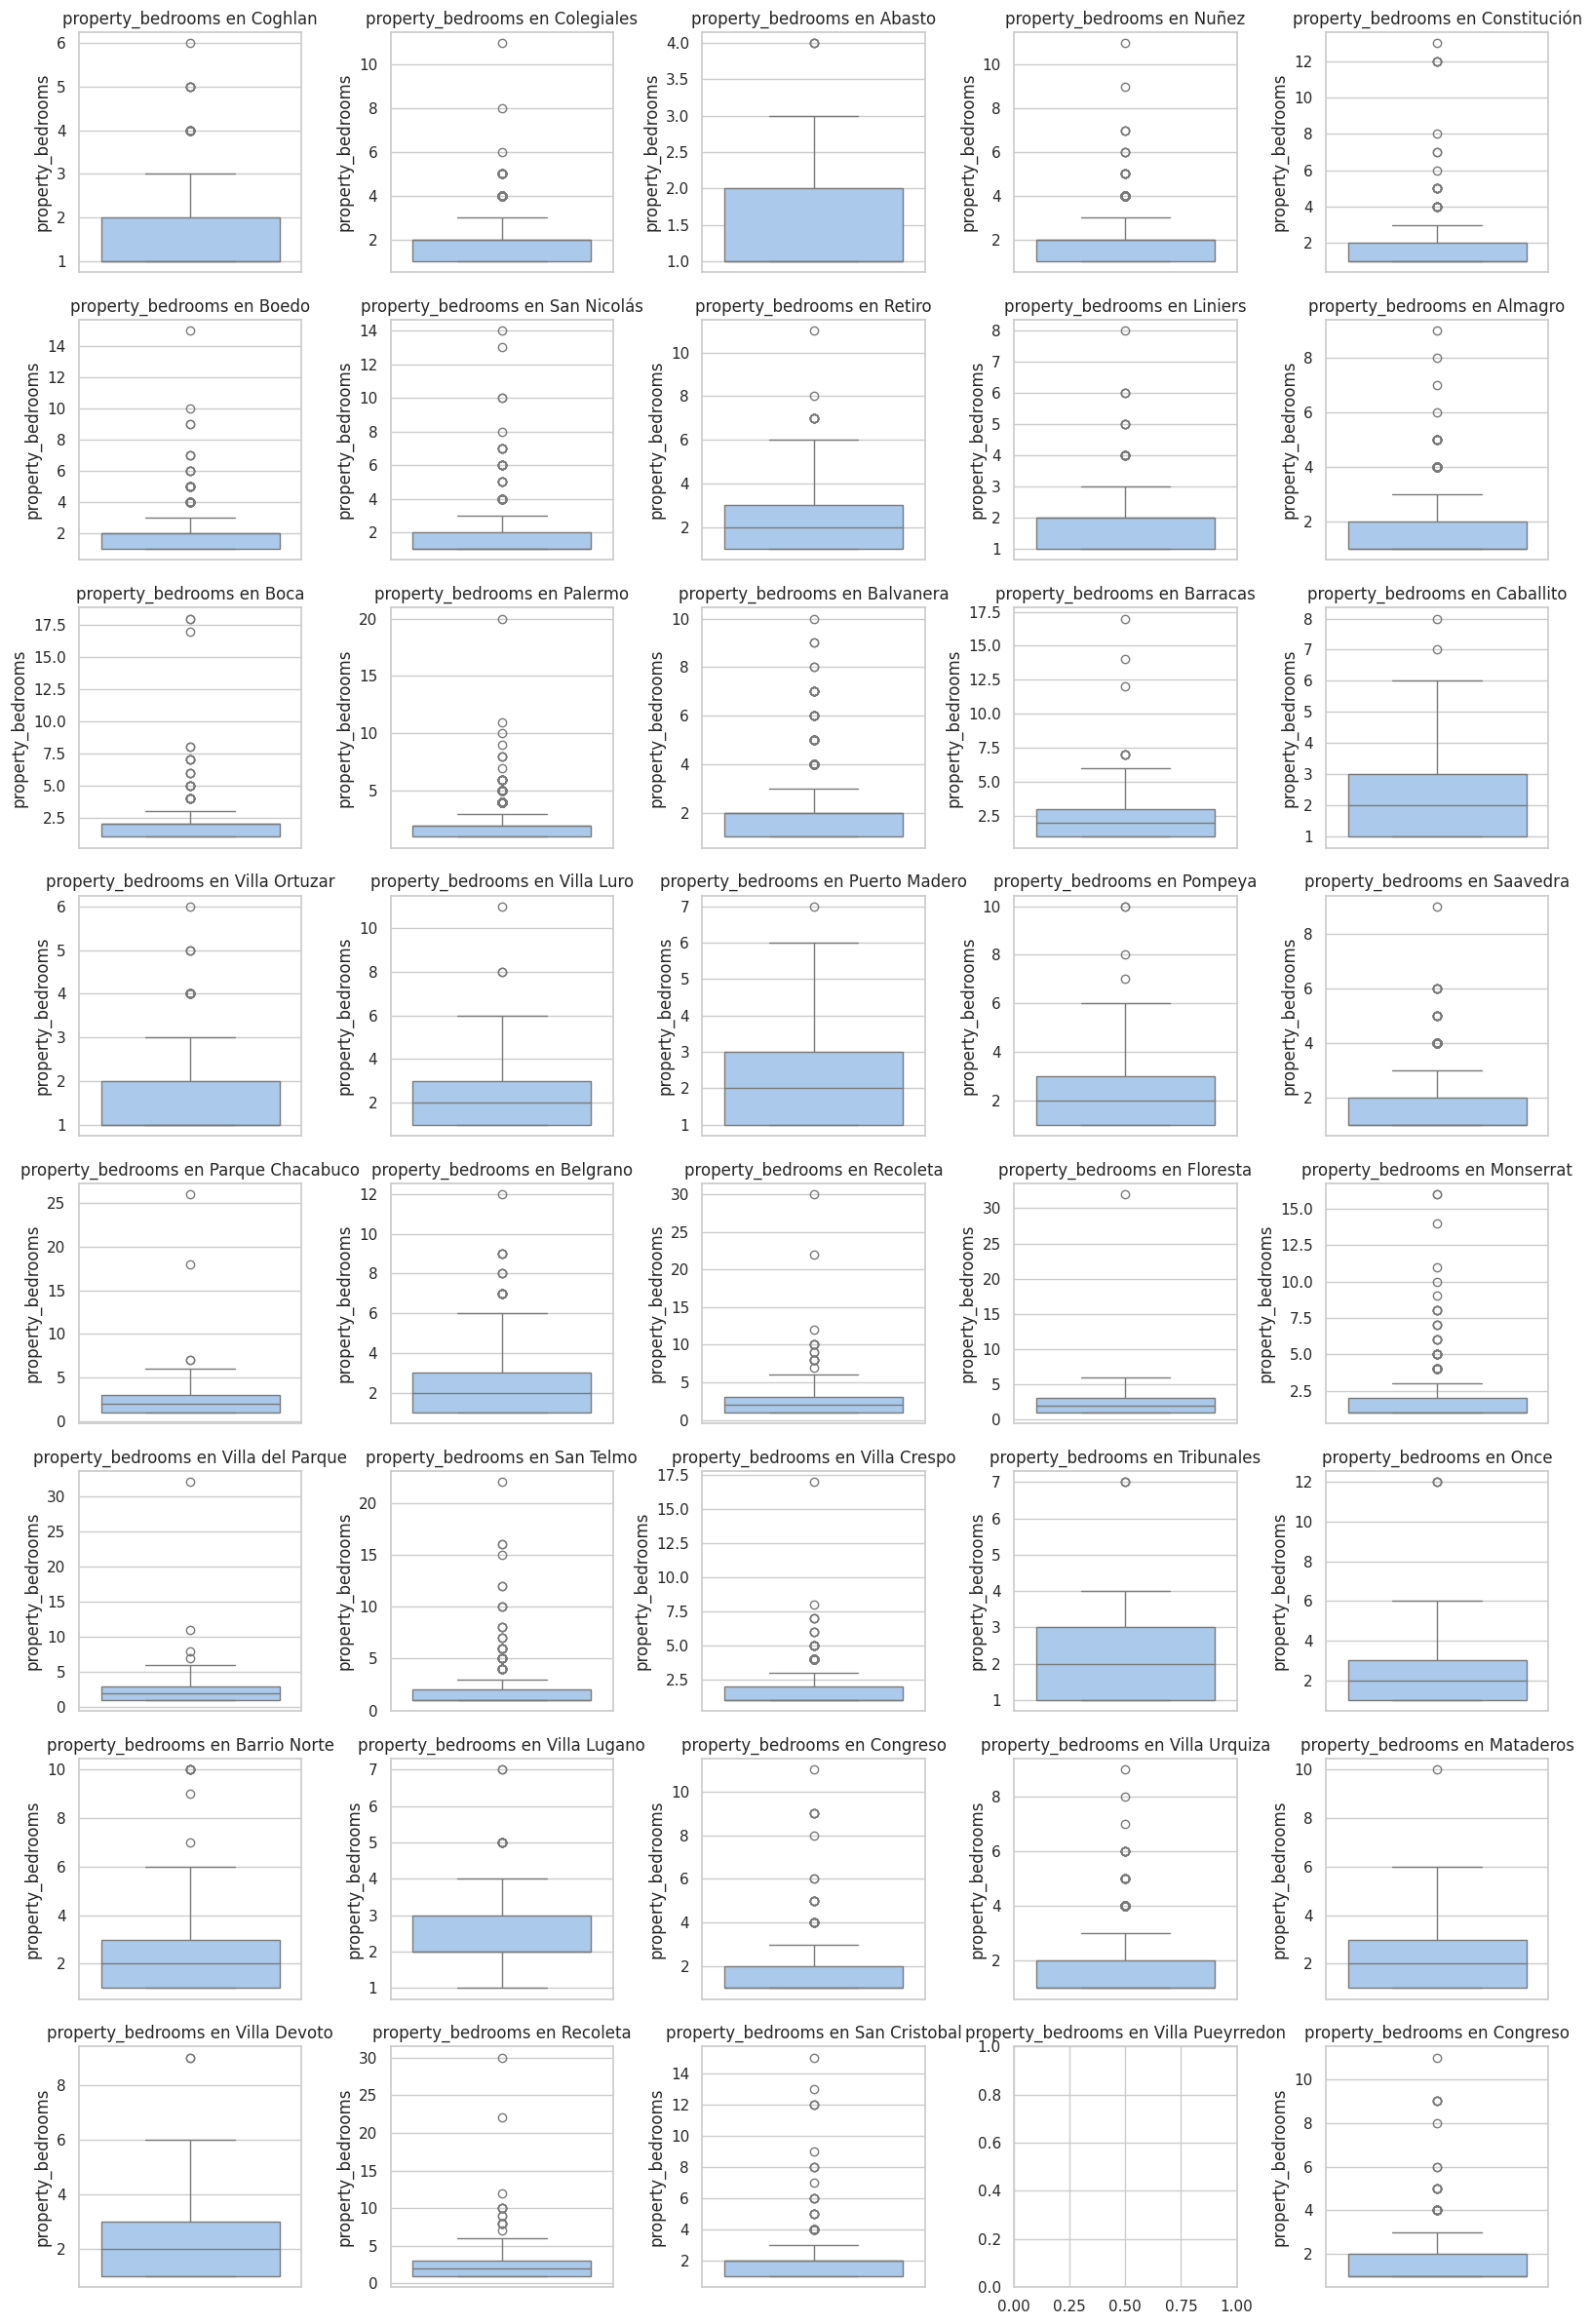

In [1282]:
plot_por_barrio(ds_train, 'property_bedrooms')

Analizando los boxplot de la cantidad de habitaciones pero dividido según el barrio en el que se encuentra la propiedad, podemos ver aún teniendo en cuenta las variaciones, que aquellos casos de casas con más de 8 habitaciones son outliers extremos y decidimos normalizarlas utilizando una transformación logaritmica.

Nota: el limite intercuartil en general para la zona de CABA era 4, pero como vemos en barrios como Caballito esto se encuentra totalmente dentro de la norma.

In [1283]:
ds_train.loc[ds_train['property_bedrooms'] > 7.0, 'property_bedrooms'] = np.log(ds_train['property_bedrooms'])

In [1284]:
ds_train[ds_train['property_bedrooms'] > 6]

id  start_date    end_date created_on  \
398724  t0mG+MlvoUEuQxyELQvmgg==  2021-02-13  2021-07-26 2021-02-13   
393372  7nxreTyKxab7bspnoAodSQ==  2021-02-13  2021-03-01 2021-02-13   
32619   TbCOFDdGTcs31yjaxega9Q==  2021-12-04  2022-01-27 2021-12-04   
420396  O8oyYGBUdY3jPaEa1NK6Xg==  2021-12-01  2021-12-30 2021-12-01   
449622  YxjhWpsXv+4ySaNcSmtSxw==  2021-12-16  2022-02-09 2021-12-16   
...                          ...         ...         ...        ...   
354636  jMJzyQRQyB7RMx45YwYLCw==  2021-03-31  2021-11-03 2021-03-31   
145014  HnDSgqWxaI2YuMfynbJH9g==  2021-07-29  2021-11-14 2021-07-29   
72640   RBSIx9grSfooVB473NbCfA==  2021-05-29  2021-07-22 2021-05-29   
111428  3XZ377CfRfsjXSsh5QFLKQ==  2021-10-19  9999-12-31 2021-10-19   
101719  PpCseiKpFgucEB+a1H+zdQ==  2021-05-28  2021-06-05 2021-05-28   

          latitud   longitud          place_l3 property_type  property_rooms  \
398724 -34.604668 -58.396573         Balvanera  Departamento             8.0   
393372 -34.612133 -58.406925         Balvanera            PH             6.0   
32619  -34.632730 -58.434728  Parque Chacabuco          Casa             8.0   
420396 -34.593316 -58.377201            Retiro  Departamento             9.0   
449622 -34.546268 -58.459154             Nuñez            PH             8.0   
...           ...        ...               ...           ...             ...   
354636 -34.641514 -58.367007              Boca            PH            10.0   
145014 -34.585590 -58.448516         Chacarita          Casa             8.0   
72640  -34.602843 -58.386216       San Nicolás  Departamento             8.0   
111428 -34.599525 -58.401587      Barrio Norte  Departamento             8.0   
101719 -34.651465 -58.424129           Pompeya          Casa             8.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
398724                7.0                   247.0                     232.0   
393372                7.0                    67.0                      58.0   
32619                 7.0                   306.0                     272.0   
420396                7.0                   380.0                     350.0   
449622                7.0                   246.0                     172.0   
...                   ...                     ...                       ...   
354636                7.0                   123.0                     118.0   
145014                7.0                   230.0                     230.0   
72640                 7.0                   195.0                     190.0   
111428                7.0                   282.0                     195.0   
101719                7.0                   320.0                     306.0   

        property_price  
398724        360000.0  
393372        128000.0  
32619         485000.0  
420396        650000.0  
449622        370000.0  
...                ...  
354636        150000.0  
145014        410000.0  
72640         198000.0  
111428        240000.0  
101719        241000.0  

[85 rows x 13 columns]

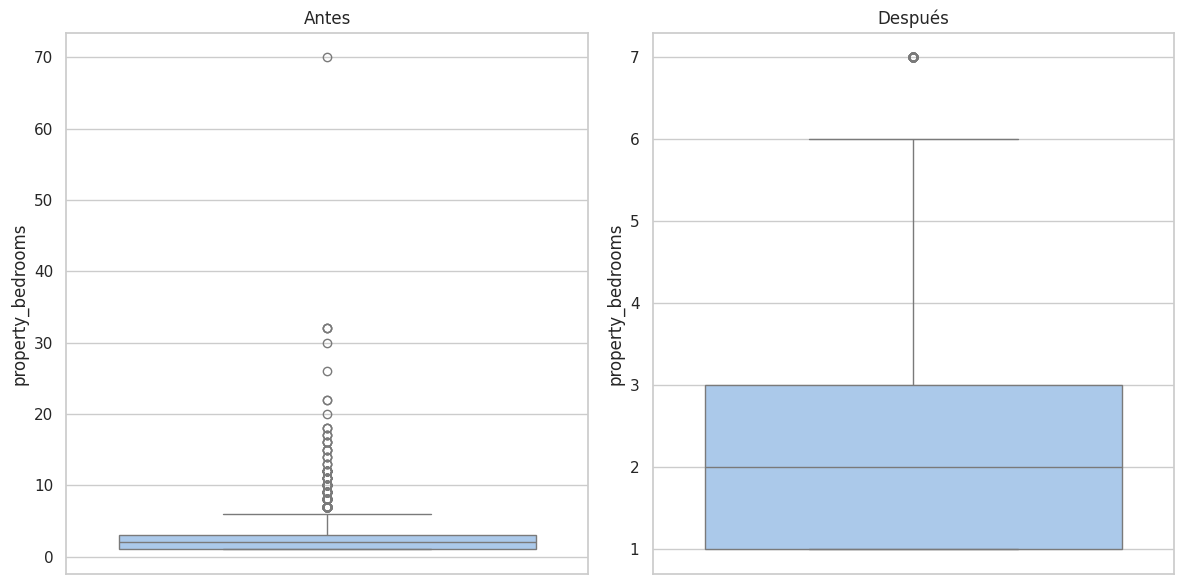

In [1285]:
plot_comparativo(ds_atipicos, ds_train, 'property_bedrooms')

Podemos ver que se han solucionado la mayoría de las anomalías. Dejaremos las restantes (84 registros) para el análisis multivariado.

#### *Análisis según cantidad de ambientes (property_rooms)*

<Axes: ylabel='property_rooms'>

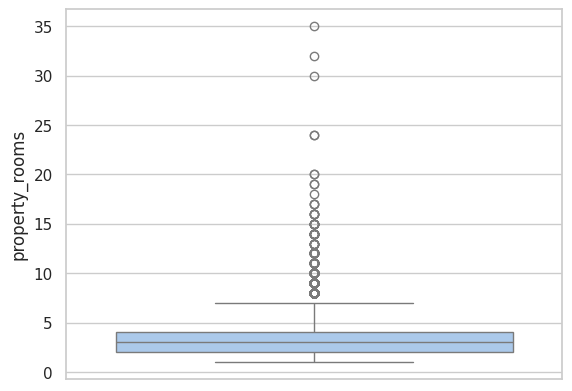

In [1286]:
sns.boxplot(y=ds_train.property_rooms)

In [1287]:
limite_rango_iq(ds_train, 'property_rooms')

(-1.0, 5.0)

El limite intercuartil superior es 5.0. Vemos que si bien hay muchos outliers por sobre el limite de 5 ambientes, esto se acentúa una vez que se superan los 20 ambientes.



In [1288]:
# Observación anómala
outlier = ds_train[ds_train['property_rooms'] > 20]
outlier

id  start_date    end_date created_on  \
292167  CxZv3EmTnK+m6EJD2uQ5fw==  2021-02-23  2021-03-03 2021-02-23   
1932    eQ/SiyES/mXWsSyAzb3k3A==  2021-12-17  9999-12-31 2021-12-17   
21009   bmop3OsDu5kJmbAVgJ5wzA==  2021-03-15  2021-06-05 2021-03-15   
150885  X3WGOe/PrGS1u+xozM5elA==  2021-03-24  2021-06-05 2021-03-24   
90004   TEs1aRnhJPwR0jRMq/Vzdg==  2021-08-03  9999-12-31 2021-08-03   

          latitud   longitud          place_l3 property_type  property_rooms  \
292167 -34.616487 -58.371596         San Telmo            PH            24.0   
1932   -34.637026 -58.426283  Parque Chacabuco          Casa            24.0   
21009  -34.616391 -58.456038         Caballito  Departamento            30.0   
150885 -34.642037 -58.438995  Parque Chacabuco  Departamento            35.0   
90004  -34.633236 -58.480313          Floresta            PH            32.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
292167           3.091042                   800.0                     650.0   
1932             2.890372                222836.0                  217000.0   
21009            2.000000                    79.0                      79.0   
150885           3.258097                    37.0                      33.0   
90004            3.465736                   535.0                     435.0   

        property_price  
292167        350000.0  
1932          250000.0  
21009         230000.0  
150885         67000.0  
90004         300000.0

Si bien los datos de habitaciones y ambientes no son posibles, por ahora no serán borrados ya que el resto (superficie cubierta, precio) parecen coherentes con el resto del dataset y pueden ser útiles.

Controlaremos según barrio.

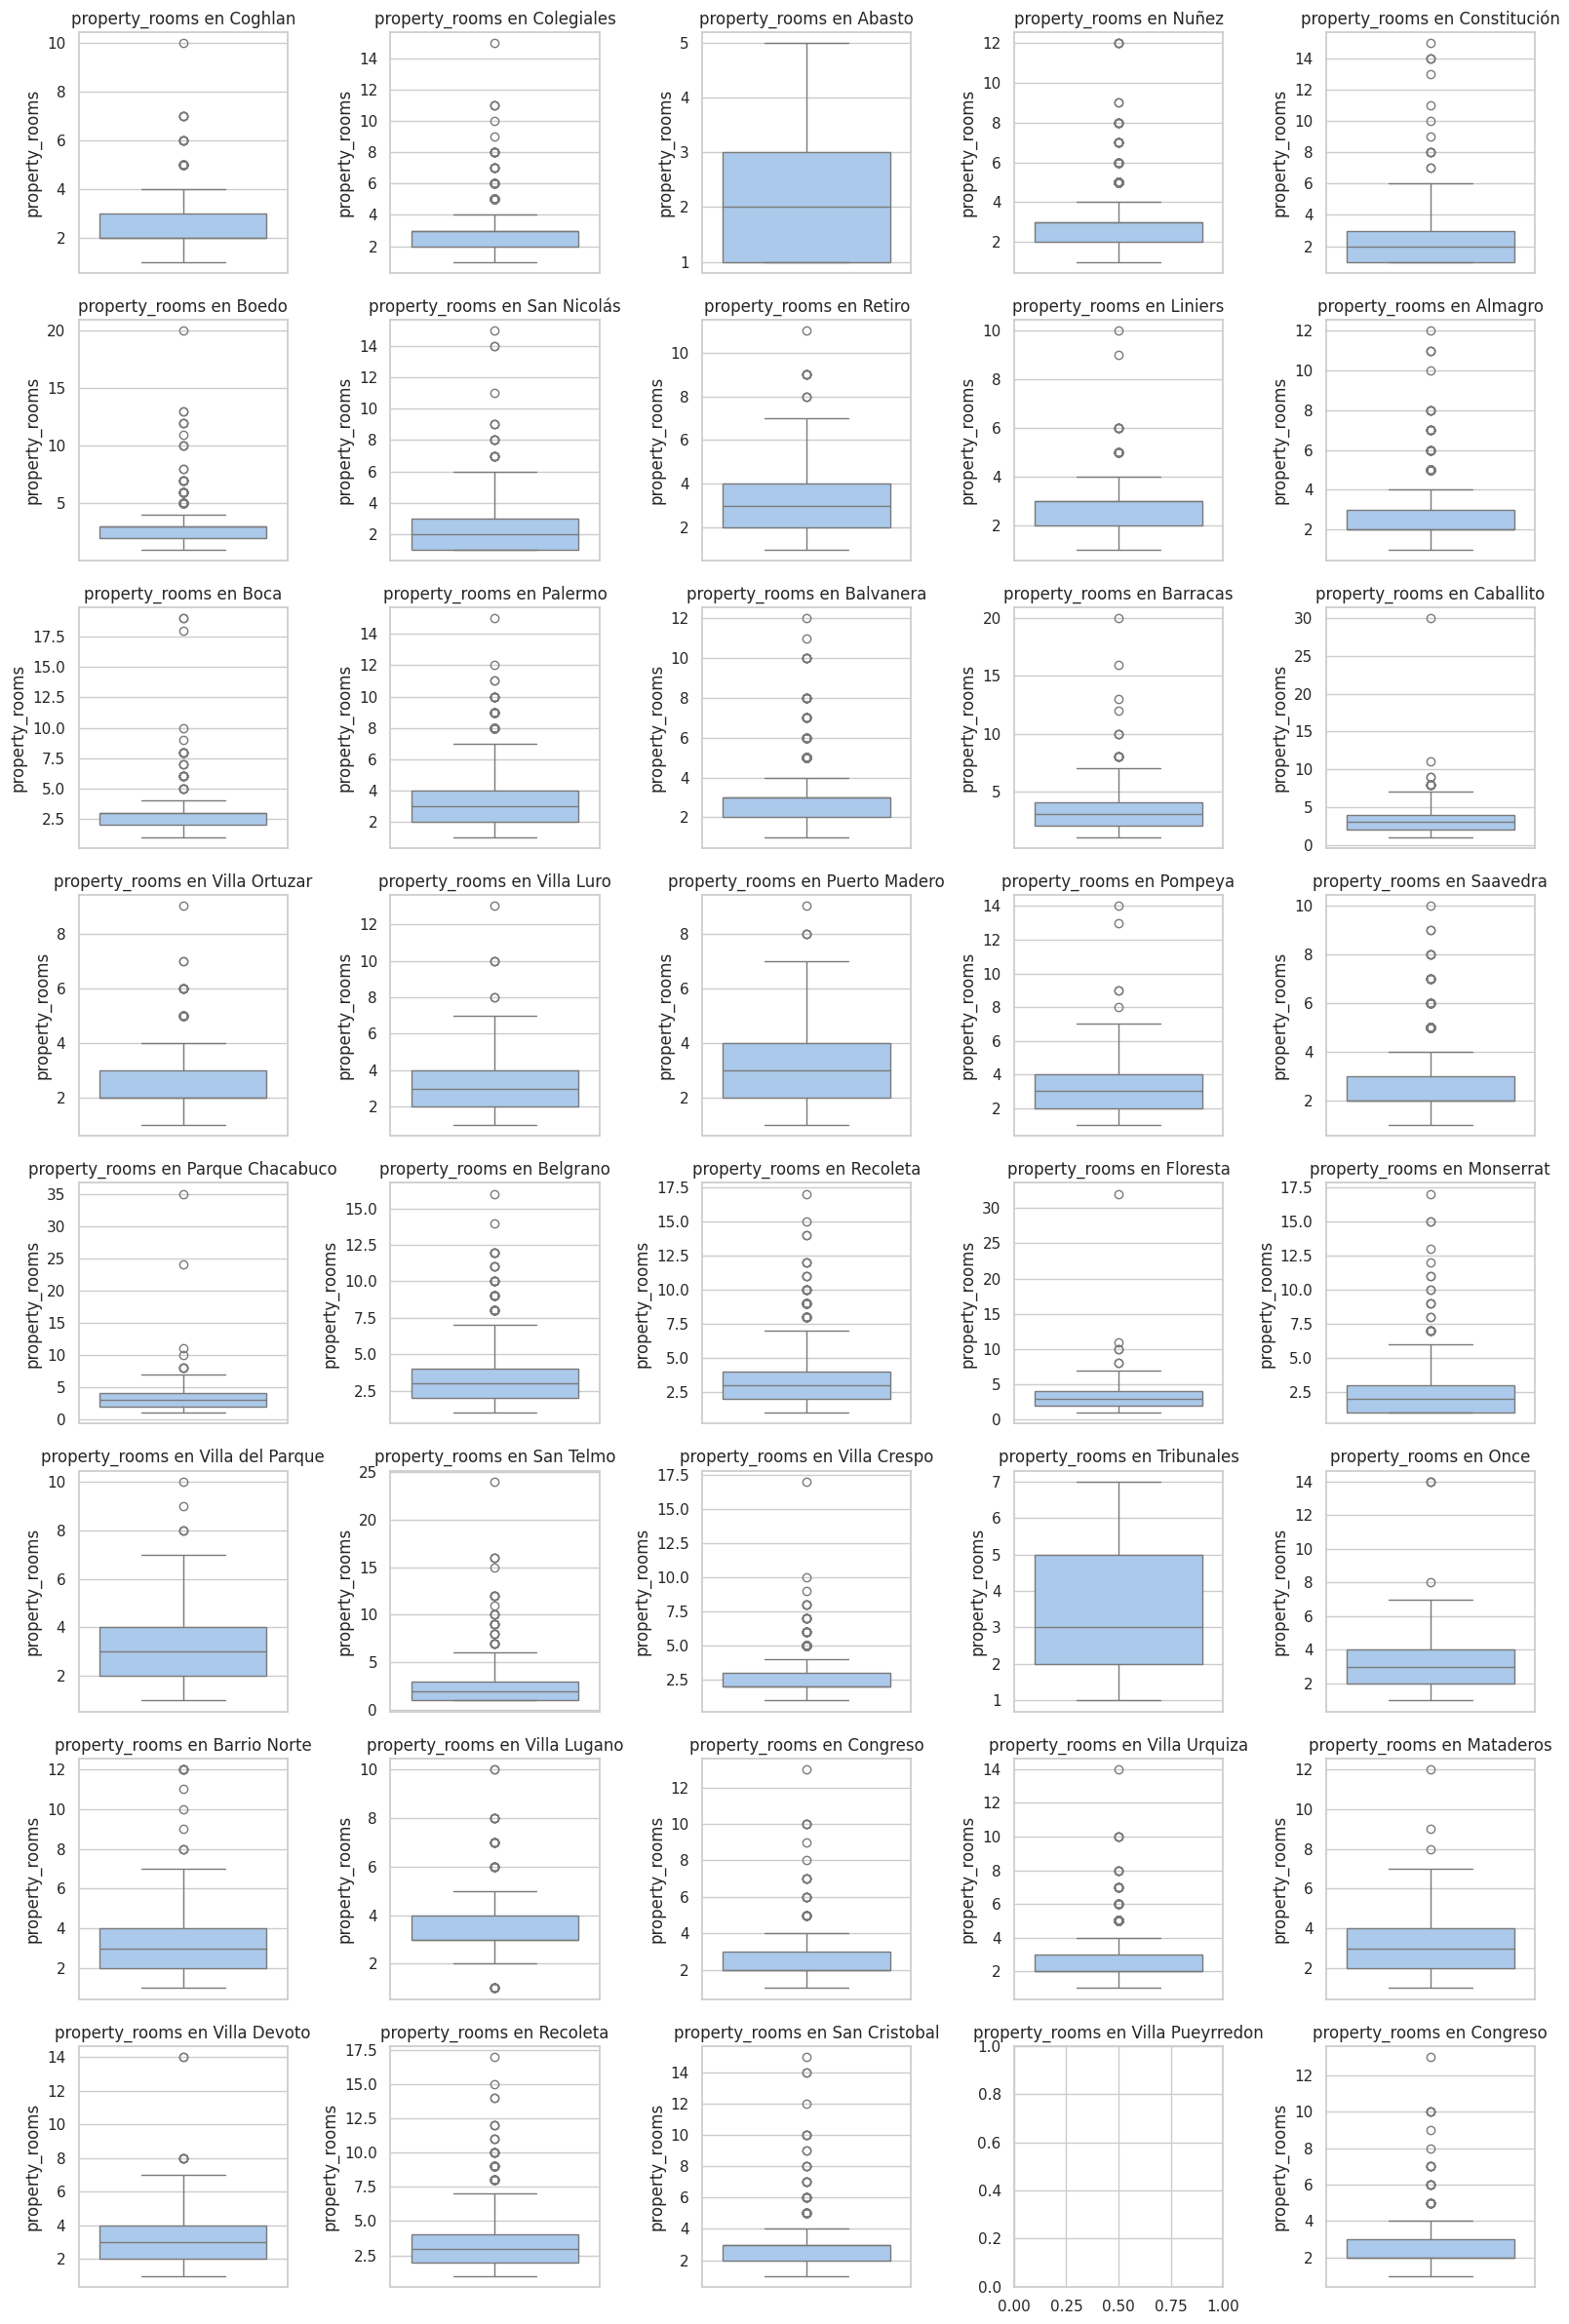

In [1289]:
plot_por_barrio(ds_train, 'property_rooms')

Si bien nuestro límite intercuartil era de 5.0 vemos una tendencia un poco superior al ver los boxplot por barrio, así que realizaremos una corrección en aquellos registros atípicos que superen los 10 ambientes.

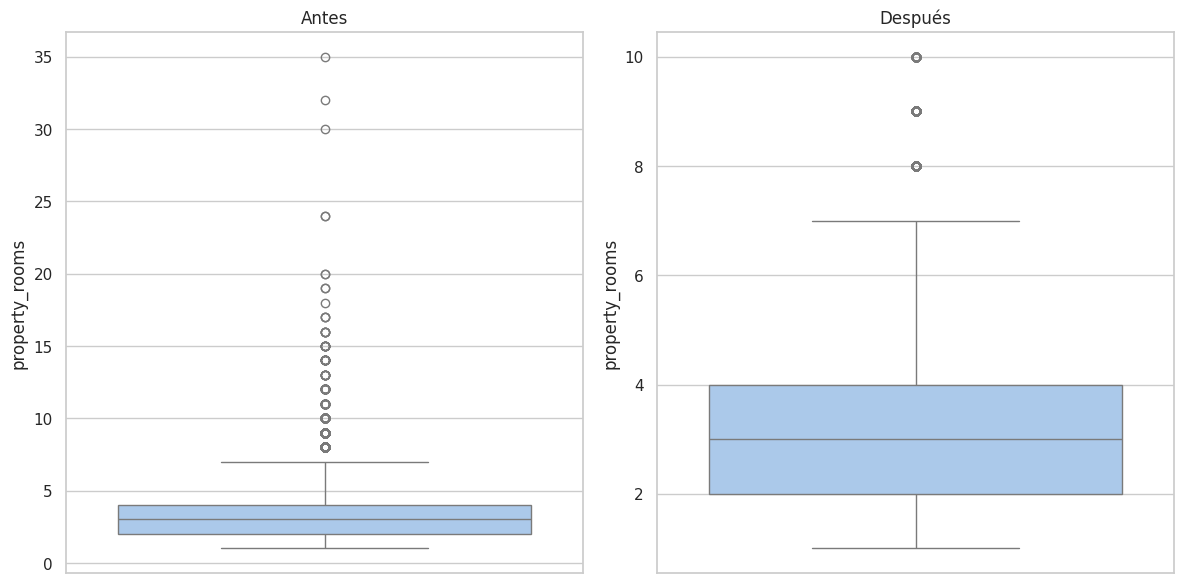

In [1290]:
#Normalizacion logaritmica
ds_train.loc[ds_train['property_rooms'] > 10.0, 'property_rooms'] = np.log(ds_train['property_rooms'])

#Comparación del antes y después del analisis de la variable
plot_comparativo(ds_atipicos, ds_train, 'property_rooms')

In [1291]:
ds_train[(ds_train['property_rooms'] > 7.0)]

id  start_date    end_date created_on  \
383046  ydzHfMR3lU7HOQXo83R00A==  2021-04-27  2021-05-12 2021-04-27   
162426  2G4vMuD58H7EG4eIjenJFw==  2021-10-07  2022-01-27 2021-10-07   
32771   G8uj/gV/VDUnV0hvsgbF7Q==  2021-02-08  2021-03-01 2021-02-08   
234435  5HTs7Ae7rXo9STs86QTqEg==  2021-06-02  2021-06-05 2021-06-02   
358714  nYi5e8OGk9yhdRzvQQHSbQ==  2021-06-29  2021-08-10 2021-06-29   
...                          ...         ...         ...        ...   
111428  3XZ377CfRfsjXSsh5QFLKQ==  2021-10-19  9999-12-31 2021-10-19   
331525  X9jsyknsuCuHNBef06vk7Q==  2021-01-01  2021-01-02 2021-01-01   
168492  EC9pkyXqo+n7OLZvimRS9A==  2021-04-30  2021-06-05 2021-04-30   
101719  PpCseiKpFgucEB+a1H+zdQ==  2021-05-28  2021-06-05 2021-05-28   
367628  o1Wp8rZ8AzLOpcUAeJIaIg==  2021-04-10  2021-04-28 2021-04-10   

          latitud   longitud      place_l3 property_type  property_rooms  \
383046 -34.574507 -58.445677    Colegiales          Casa             8.0   
162426 -34.620235 -58.383054     San Telmo  Departamento             9.0   
32771  -34.621163 -58.413933         Boedo          Casa            10.0   
234435 -34.618535 -58.426586       Almagro          Casa             8.0   
358714 -34.590923 -58.384214      Recoleta  Departamento             9.0   
...           ...        ...           ...           ...             ...   
111428 -34.599525 -58.401587  Barrio Norte  Departamento             8.0   
331525 -34.629600 -58.364400          Boca  Departamento             8.0   
168492 -34.623708 -58.384672  Constitución  Departamento             8.0   
101719 -34.651465 -58.424129       Pompeya          Casa             8.0   
367628 -34.624076 -58.514172  Villa Devoto          Casa             8.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
383046                4.0                   262.0                     242.0   
162426                5.0                   480.0                     445.0   
32771                 5.0                   660.0                     520.0   
234435                4.0                   297.0                     297.0   
358714                4.0                   668.0                     668.0   
...                   ...                     ...                       ...   
111428                7.0                   282.0                     195.0   
331525                6.0                   166.0                     144.0   
168492                5.0                   213.0                     213.0   
101719                7.0                   320.0                     306.0   
367628                4.0                   230.0                     230.0   

        property_price  
383046        690000.0  
162426        530000.0  
32771        1032000.0  
234435        420000.0  
358714       5000000.0  
...                ...  
111428        240000.0  
331525        190000.0  
168492        285000.0  
101719        241000.0  
367628        373000.0  

[486 rows x 13 columns]

Tenemos 502 valores por sobre el máximo marcado por el bigote en el boxplot actual y que pueden ser considerados outliers. Reveeremos estos valores en otros análisis.

#### *Análisis según precio de la propiedad (property_price)*

<Axes: ylabel='property_price'>

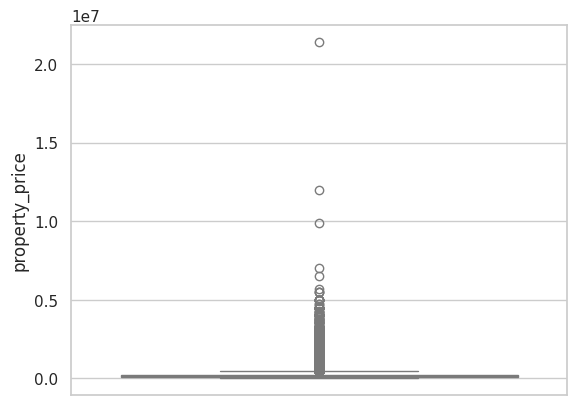

In [1292]:
sns.boxplot(y=ds_train.property_price)

In [1293]:
limite_rango_iq(ds_train, 'property_price')

(-115000.0, 305000.0)

Primero analizamos las anomalías más extremas, valores mayores o iguales a 8M.

In [1294]:
# Observación anómala
outlier = ds_train[ds_train['property_price'] >= 8000000]
outlier

id  start_date    end_date created_on    latitud  \
1140   ddV7Ll5c1H+Rmqqovc+uFg==  2021-09-09  2022-01-27 2021-09-09 -34.605781   
60073  uoM9HDKq3jZKQKgHXTIGkg==  2021-01-25  2022-05-13 2021-01-25 -34.616044   
85725  pKJUYwxjs9j+ub8gzLyc/g==  2021-03-26  2021-06-05 2021-03-26 -34.572494   

        longitud     place_l3 property_type  property_rooms  \
1140  -58.376705  San Nicolás  Departamento             4.0   
60073 -58.458621    Caballito  Departamento             3.0   
85725 -58.462433     Belgrano          Casa             5.0   

       property_bedrooms  property_surface_total  property_surface_covered  \
1140                 3.0                 10500.0                   10500.0   
60073                2.0                    68.0                      64.0   
85725                4.0                  3197.0                    3367.0   

       property_price  
1140        9900000.0  
60073      21400000.0  
85725      12000000.0

Buscando propiedades actualmente en venta en barrios y tamaños similares, parecería haber un error. Sin embargo, incluso haciendo un reducción de un decimo (valores más coherentes para esos varrios y tamaños de casas), estaríamos por sobre el límite intercuartil, asi que por ahora no haremos transformaciones.

Analicemos según barrio:

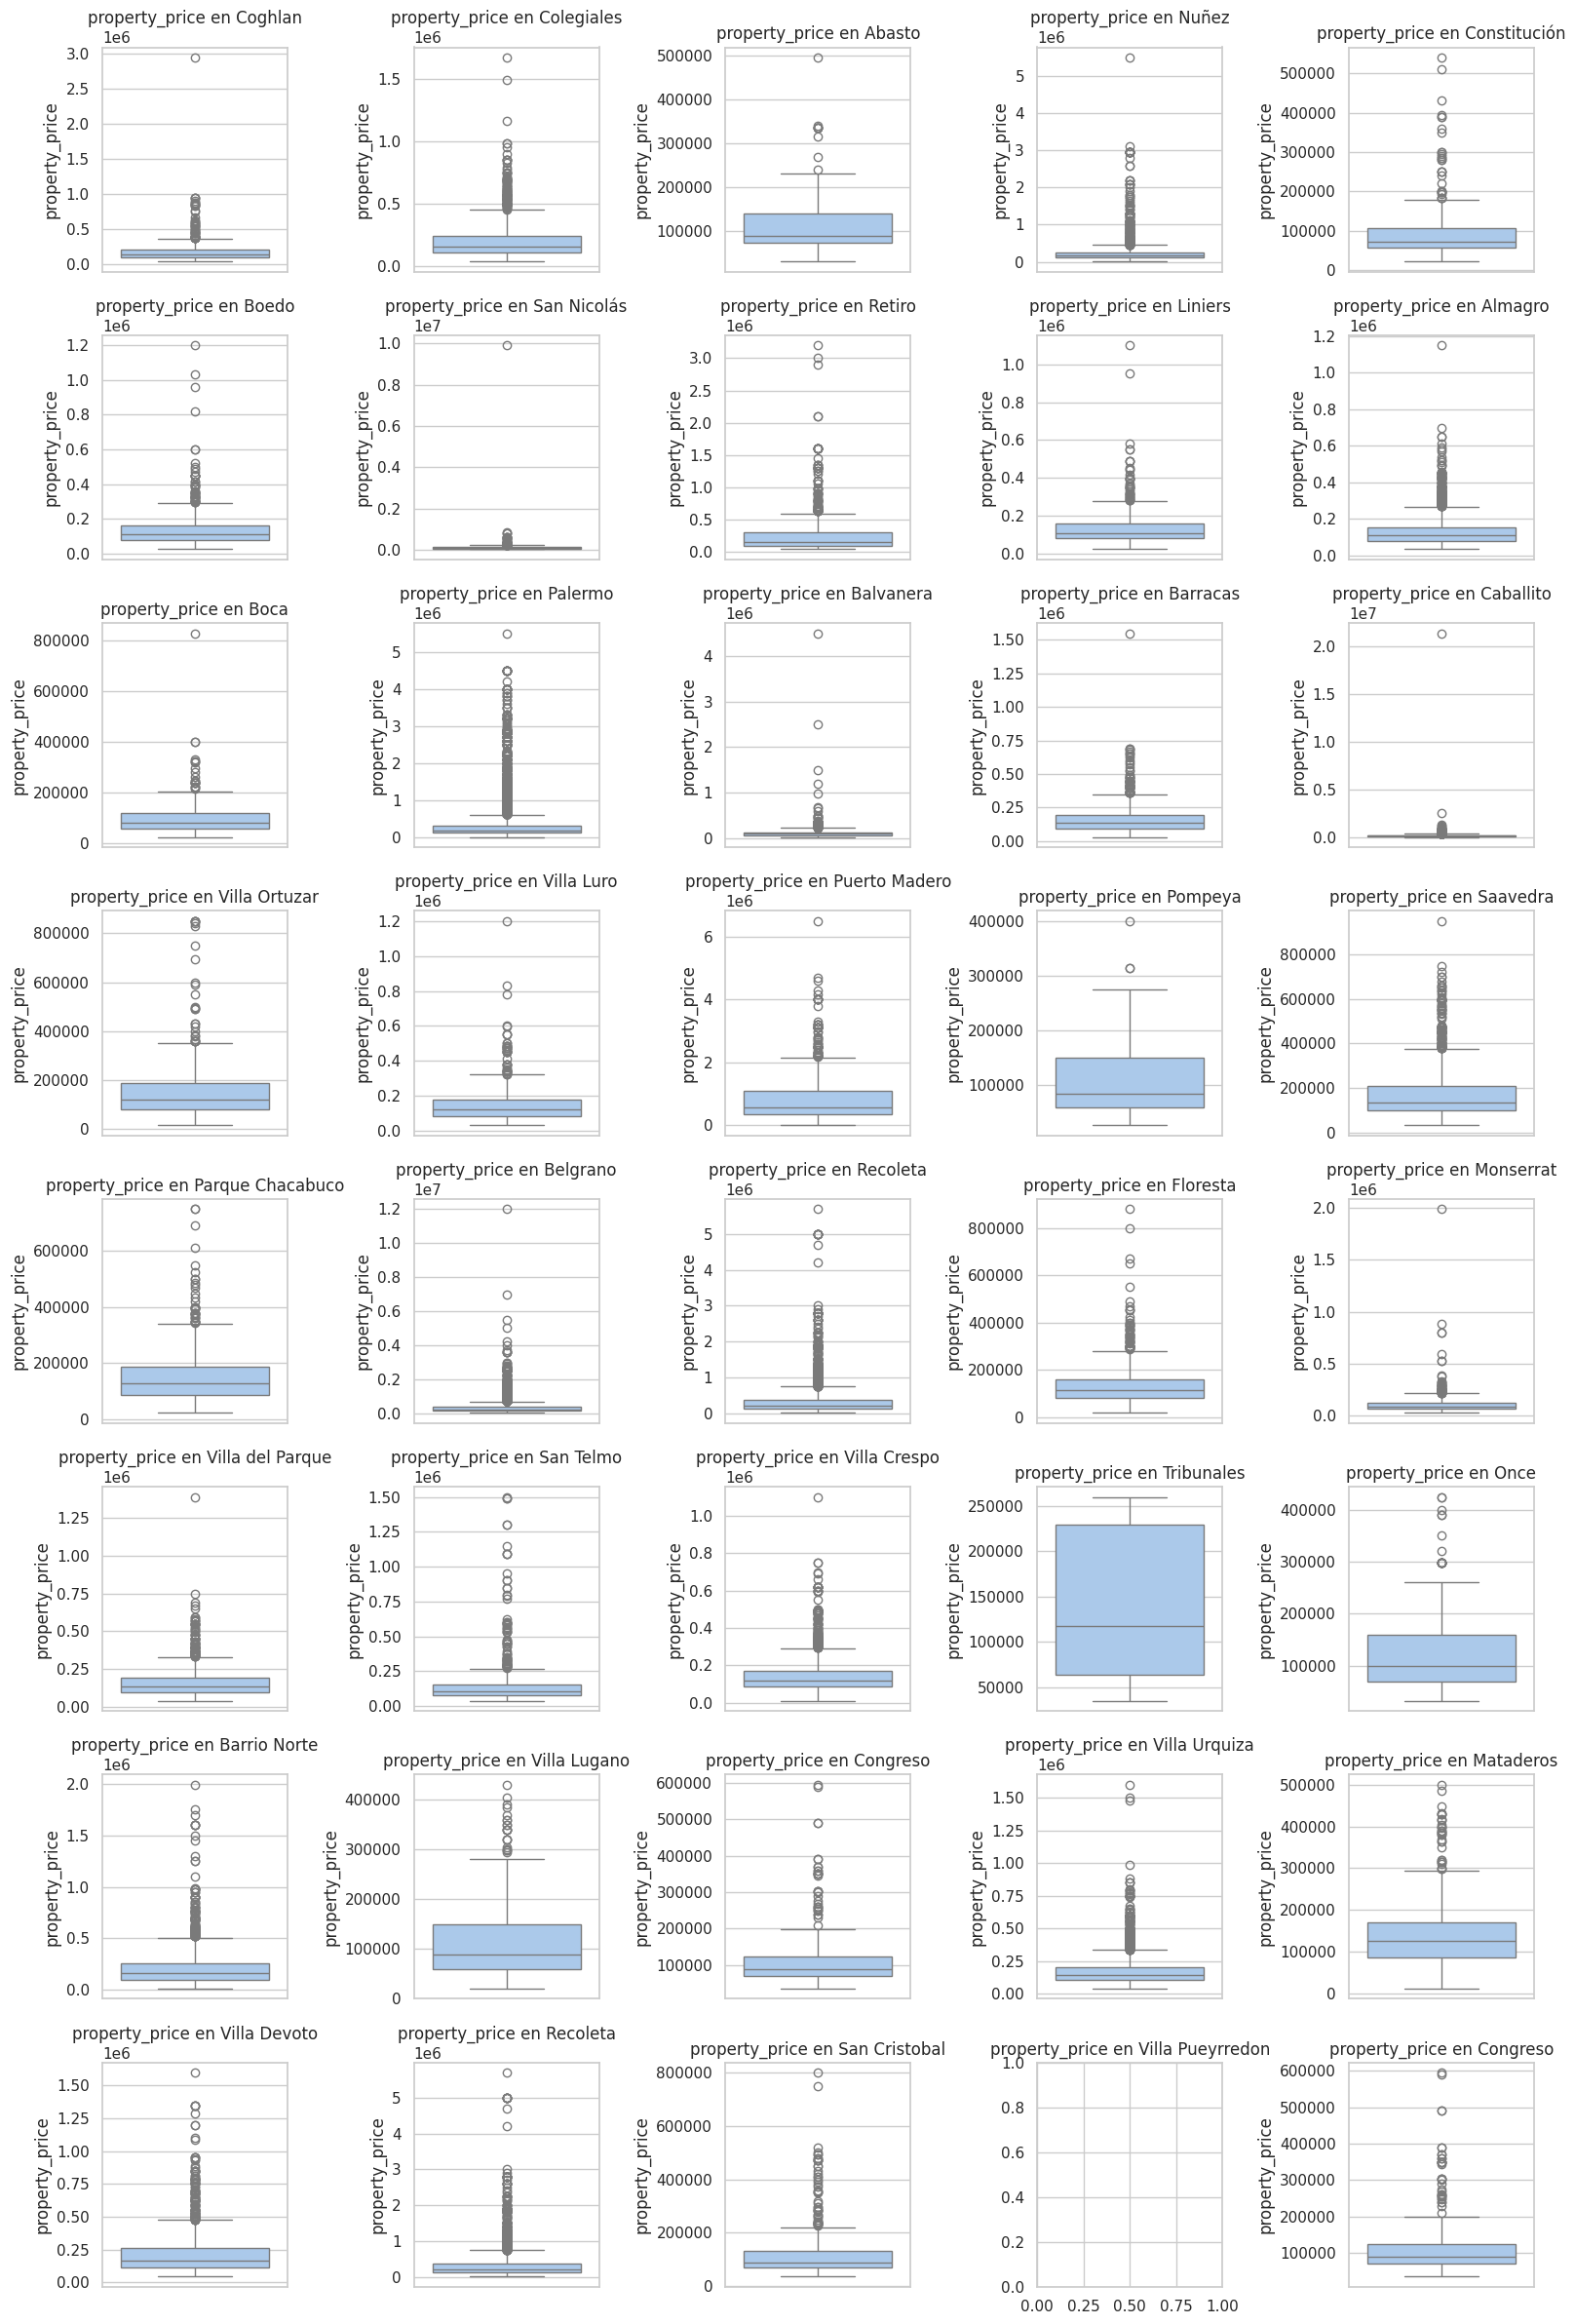

In [1295]:
plot_por_barrio(ds_train, 'property_price')

Hasta el momento, este el analisis según barrio menos homogéneo. Si tomamos el limite superior intercuartil general (305m), se distorcionarían totalmente los datos de barrios como Palermo y Puerto Madero. Teniendo en cuenta lo relevante que es éste dato a la hora de que se establezca el precio de una propiedad, solo trabajaremos con los outliers que sean extremos en el contexto de cada barrio (analisis multivariado).

*Análisis según superficie cubierta (property_surface_covered)*

<Axes: ylabel='property_surface_covered'>

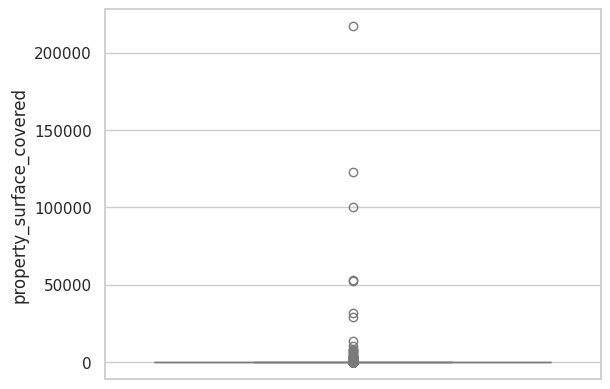

In [1296]:
sns.boxplot(y=ds_train.property_surface_covered)

In [1297]:
limite_rango_iq(ds_train, 'property_surface_covered')

(-32.0, 112.0)

In [1298]:
# Observación anómala
outlier = ds_train[ds_train['property_surface_covered'] <= 0]
outlier


Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [1299]:
# Comprobamos buscando indice con la propiedad con la mínima superficie.
min_surface_index = ds_train['property_surface_covered'].idxmin()
ds_train.loc[min_surface_index]

id                          PbmLqspc4lB1ngdoo8fgRw==
start_date                                2021-09-24
end_date                                  2021-12-10
created_on                       2021-09-24 00:00:00
latitud                                   -34.603593
longitud                                  -58.376756
place_l3                                 San Nicolás
property_type                           Departamento
property_rooms                                   1.0
property_bedrooms                                1.0
property_surface_total                          20.0
property_surface_covered                         1.0
property_price                               39000.0
Name: 95129, dtype: object

 No existen propiedades con superficie negativa.
 Aún así, podemos ver que hay propiedades con superficies que si bien no son negativas, son demasiado pequeñas para el tipo de edificación.

In [1300]:
ds_train[ds_train['property_surface_covered'] < 15]

id  start_date    end_date created_on  \
215543  bTnrKMAQdbzSpl41L4LLaQ==  2021-11-17  2021-12-02 2021-11-17   
298191  hMmndNe/Ju9aZNsjc7++pQ==  2021-06-12  2021-06-29 2021-06-12   
66495   GRPH2C7rTi8mLa/xn+SulA==  2021-11-24  2022-01-27 2021-11-24   
95129   PbmLqspc4lB1ngdoo8fgRw==  2021-09-24  2021-12-10 2021-09-24   
41540   Lf8BrIBw4gLrxysxz2D1oA==  2021-01-12  2021-06-05 2021-01-12   
...                          ...         ...         ...        ...   
36467   CHlKVkRxO4yj7SuG1Rz1Sw==  2021-09-21  2021-10-28 2021-09-21   
41866   766MJy1wZVXIvaCTKrsisA==  2021-01-12  2021-06-05 2021-01-12   
216556  ibuvhaeGqR/PdBmffubDuQ==  2021-12-22  2022-01-27 2021-12-22   
373849  4IKBmNUjfZSNnEk3Joeuhg==  2021-05-31  2021-06-05 2021-05-31   
170188  TN5lzrHaYRbTxnC6JqLf2g==  2021-07-28  2022-01-02 2021-07-28   

          latitud   longitud       place_l3 property_type  property_rooms  \
215543 -34.617285 -58.396332      Balvanera  Departamento             1.0   
298191 -34.615168 -58.408262  San Cristobal  Departamento             1.0   
66495  -34.581712 -58.433053        Palermo  Departamento             1.0   
95129  -34.603593 -58.376756    San Nicolás  Departamento             1.0   
41540  -34.573360 -58.441008       Belgrano  Departamento             3.0   
...           ...        ...            ...           ...             ...   
36467  -34.582148 -58.427791        Palermo  Departamento             2.0   
41866  -34.611753 -58.516570   Villa Devoto  Departamento             1.0   
216556 -34.586819 -58.439485        Palermo  Departamento             1.0   
373849 -34.576619 -58.437281        Palermo  Departamento             1.0   
170188 -34.560995 -58.465900       Belgrano  Departamento             1.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
215543                1.0                    43.0                       8.0   
298191                1.0                    35.0                       3.0   
66495                 1.0                    35.0                       3.0   
95129                 1.0                    20.0                       1.0   
41540                 2.0                    24.0                       1.0   
...                   ...                     ...                       ...   
36467                 1.0                    50.0                       5.0   
41866                 1.0                    11.0                       1.0   
216556                1.0                    40.0                       6.0   
373849                1.0                    40.0                       6.0   
170188                1.0                    38.0                       5.0   

        property_price  
215543         59800.0  
298191         53000.0  
66495          94999.0  
95129          39000.0  
41540         229000.0  
...                ...  
36467         155000.0  
41866         109900.0  
216556         99000.0  
373849        147000.0  
170188         95000.0  

[473 rows x 13 columns]

Tenemos 147 registros de propiedades que tienen menos de 15m^2 cubiertos, y si bien según código urbanistico de la Ciudad de Buenos Aires no permite departamentos tan pequeños, sabemos que eso puede infringirse. Bajo estos supuestos, y viendo los registros que aparecen, vamos a reemplazar aquellos con superficies demasiado pequeñas (menores a 10m^2) por la superficie total.

In [1301]:
# Reemplazamos el valor de superficie cubierta por el de superficie total cuando el valor sea menor a 10
ds_train.loc[ds_train['property_surface_covered'] < 10, 'property_surface_covered'] = ds_train.loc[ds_train['property_surface_covered'] < 10, 'property_surface_total']

In [1302]:
ds_train[ds_train['property_surface_covered'] < 15]

id  start_date    end_date created_on  \
406146  o1aioW4A6QUHMjIs/oQlAw==  2021-01-07  9999-12-31 2021-01-07   
19478   J0/gRyRPvFY0WmEU0nY1Fw==  2021-01-27  2021-08-17 2021-01-27   
227332  em6zu1jxzH6eFzsNOQhHBQ==  2021-02-12  2021-03-05 2021-02-12   
168082  nOmTA76B5Fc56I5HKId9Dg==  2021-04-30  2021-06-03 2021-04-30   
86014   pVG9sES9De/1eQ+tB90NjQ==  2021-03-26  2021-06-05 2021-03-26   
326305  s4UQHlmed73o08wupnf2pg==  2021-08-27  9999-12-31 2021-08-27   
139764  yySkeMjOWpZEHNGqZffFAg==  2021-07-15  2021-10-30 2021-07-15   
35773   Uj8qMdUrIbFYo0kgN6L5Jg==  2021-02-08  9999-12-31 2021-02-08   
366862  /A4fwg7GWRLFjIWxvUkCyQ==  2021-04-10  2021-06-05 2021-04-10   
38433   aZRjphLdiNfPd74mAGbrSg==  2021-07-05  2021-08-09 2021-07-05   
76920   wNXQe4mGeSb2TxJgWd65PA==  2021-07-17  2021-07-20 2021-07-17   
255902  ypBqh2DMTE8ec4Mp/Z4M6w==  2021-11-03  2021-11-09 2021-11-03   
401698  BIT3OESAkwXpejzzcVCMiA==  2021-06-17  2021-08-03 2021-06-17   
333830  FfMyx7es1we4sMCZL2XVTw==  2021-12-28  2022-02-09 2021-12-28   
95088   Q5u5v/WYM0C1/XVg1Db86Q==  2021-09-24  2022-03-09 2021-09-24   
266187  Os54gQ2Oobr3NRSuDQw+cA==  2021-09-02  9999-12-31 2021-09-02   
84365   6hGSd6aMeGVLtiIRd5d2bQ==  2021-02-05  2021-06-22 2021-02-05   
408338  OsE/mlsNuKXTyHkubQmHlA==  2021-03-05  2021-05-04 2021-03-05   
268998  5GWt7TvAR8P5gOI8t1bVnw==  2021-01-19  2021-06-05 2021-01-19   
373111  VJCpN714i7nm4c7lDg/PDw==  2021-08-24  2022-01-31 2021-08-24   
260339  gm26RJKnbjr6U727uup+tA==  2021-04-14  2021-04-15 2021-04-14   
133726  IV/Fck92gK/PGjln4sxcfQ==  2021-02-18  2021-06-22 2021-02-18   
272255  SYaRVm6FpvDHUvyQF7k11w==  2021-06-19  2021-08-27 2021-06-19   
42084   F7uheixgxhdUgbKjRBtE4Q==  2021-01-12  2021-06-05 2021-01-12   
299     fWyBppiSbXhNSIjAmVDULg==  2021-09-09  2021-09-26 2021-09-09   
295855  YLrVFJt3421Rss33A6OVAA==  2021-07-23  9999-12-31 2021-07-23   
293861  pwn772+kuInxUPlk5/pQPA==  2021-02-23  2021-08-24 2021-02-23   
41903   AEb8UstVhCKA3+hCfJU86A==  2021-01-12  2021-06-05 2021-01-12   
82416   W/bZCC5QBjneKd0c/yJvDw==  2021-03-12  2021-06-05 2021-03-12   
72233   txvsZ+X6aRbIQLPPQ3wZ3w==  2021-05-29  2021-06-18 2021-05-29   
225485  LU1IAN2L0mz4+8+qGftckg==  2021-05-30  2021-06-18 2021-05-30   
168108  aO8mzZYRhXeP+QU7ilBhLw==  2021-04-30  2021-06-03 2021-04-30   
380079  j0m6u3qO+aggo+C5vktywA==  2021-05-19  2021-06-05 2021-05-19   
140832  2aHER3AXQs3zb3EegLhmgg==  2021-12-08  2022-01-27 2021-12-08   
216786  YrQqgOmS9no9pw9tljj8Pw==  2021-12-22  2022-01-27 2021-12-22   
92654   zt51kd/217iX/xx8cRl3oQ==  2021-08-03  9999-12-31 2021-08-03   
17892   QsHoM/bm2HdBBEwnWY+RgA==  2021-08-28  2022-01-27 2021-08-28   
50425   rBJcf/OUoNMDP0JylFF2Vg==  2021-06-23  2022-02-09 2021-06-23   
26388   WZleU0Er8oHr9Blnk38/ZQ==  2021-06-24  2022-06-10 2021-06-24   
168064  au5LE/h6pCineDWdIhW/bA==  2021-04-30  2021-06-03 2021-04-30   
264261  o2Pf0aO+jXXSAYM9qcEmzA==  2021-02-26  9999-12-31 2021-02-26   
116331  AGiDmMpHKOxX0mMa5m6s6Q==  2021-11-12  9999-12-31 2021-11-12   
301212  /MNEruoihGzhMaUMEfP6TQ==  2021-08-10  2021-11-03 2021-08-10   
36421   VoyodCc8rftOZHr4TeYcpw==  2021-09-21  2022-02-03 2021-09-21   
7869    WxvbiPA4bItk7Y2f7NSYJQ==  2021-02-09  9999-12-31 2021-02-09   
322712  lC4AC+ibejPz5mSLe6WgMQ==  2021-06-15  2021-11-04 2021-06-15   
370010  D1BMkUjYW7Zl/LtfVBOZxA==  2021-11-08  2022-01-27 2021-11-08   
269213  rMBd4cGI2SmJDoD2/HNubA==  2021-01-19  2021-01-23 2021-01-19   
242589  wCgQzrJFpBMULYjaf7q1vg==  2021-04-01  2021-04-15 2021-04-01   
66841   G+GKcWUzDUZgWgNbR0qvvQ==  2021-11-24  2022-01-27 2021-11-24   
457757  D8b7/DGLk+8ZgrY8K0P/Dw==  2021-05-08  2021-06-05 2021-05-08   
414110  srQJ67wt1GYEyCoxWarDpQ==  2021-10-26  2022-01-27 2021-10-26   
26044   XI08qCOTks0Hqrnjx4YqxA==  2021-06-24  9999-12-31 2021-06-24   
129239  mrYs9YBzhLRsHBkNWDHBvQ==  2021-07-01  2021-11-25 2021-07-01   
41866   766MJy1wZVXIvaCTKrsisA==  2021-01-12  2021-06-05 2021-01-12   

          latitud   longitud          place_l3 proper

Ahora nos quedan 84 outliers.

In [1303]:
ds_train[ds_train['property_surface_covered'] > 15000]

id  start_date    end_date created_on  \
352883  aBZBrjan1XqHjgvjHK6K6Q==  2021-06-25  2021-07-08 2021-06-25   
72316   BPTyNzwU2D4btCduu8ls3A==  2021-05-29  2021-06-08 2021-05-29   
106598  +YPtNPAzbhoDCLgqF26Q8A==  2021-03-11  2021-04-20 2021-03-11   
1932    eQ/SiyES/mXWsSyAzb3k3A==  2021-12-17  9999-12-31 2021-12-17   
372779  XzTb7kTEpmAKiyhEGSWz4A==  2021-08-24  2021-09-03 2021-08-24   
405324  tHz32dZ72wYshPnoABftrg==  2021-01-07  2021-06-02 2021-01-07   
72521   csbBJk04jQXgGZLXTj5WAg==  2021-05-29  2021-06-13 2021-05-29   

          latitud   longitud          place_l3 property_type  property_rooms  \
352883 -34.550093 -58.483034          Saavedra  Departamento        1.000000   
72316  -34.578917 -58.429373           Palermo  Departamento        2.000000   
106598 -34.587320 -58.401556      Barrio Norte  Departamento        2.000000   
1932   -34.637026 -58.426283  Parque Chacabuco          Casa        3.178054   
372779 -34.555278 -58.459786          Belgrano  Departamento        4.000000   
405324 -34.569963 -58.481658     Villa Urquiza            PH        4.000000   
72521  -34.600113 -58.403649         Balvanera  Departamento        2.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
352883           1.000000                 29064.0                   29064.0   
72316            1.000000                 61130.0                   53030.0   
106598           1.000000                 56740.0                   52540.0   
1932             2.890372                222836.0                  217000.0   
372779           3.000000                100068.0                  100051.0   
405324           3.000000                123000.0                  123000.0   
72521            1.000000                 33800.0                   31670.0   

        property_price  
352883         87400.0  
72316         225000.0  
106598        175000.0  
1932          250000.0  
372779        420000.0  
405324        165000.0  
72521          66000.0

Los casos de propiedades con superficie cubierta mayor a 15000, parecen ser errores de escala que pueden solucionarse facilmente.

In [1304]:
condition = ds_train['property_surface_covered'] > 15000
ds_train.loc[condition, 'property_surface_covered'] /= 1000

# Vemos si se ha solucionado la anomalía para ésta condición
ds_train[ds_train['property_surface_covered'] > 15000]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [1305]:
ds_train[ds_train['property_surface_covered'] > 4000]

id  start_date    end_date created_on  \
459841  9aQHQRqWMburSn+z+Qt5aQ==  2021-01-05  2021-01-09 2021-01-05   
405272  f0j0vRkfBQUg9LkKhc/Nmw==  2021-01-07  2021-01-09 2021-01-07   
1140    ddV7Ll5c1H+Rmqqovc+uFg==  2021-09-09  2022-01-27 2021-09-09   
313745  fx1g9YinBKRFrlnCnN6p4Q==  2021-01-06  2021-01-09 2021-01-06   
233699  McdySYNyXo2s4UZ2wypUig==  2021-03-20  2022-03-25 2021-03-20   
264624  6uTpssfQ51+UbuvaOXfeRw==  2021-02-26  2021-03-01 2021-02-26   
314541  /lzClyxH96pdJl/JI2ofKg==  2021-01-06  2021-01-09 2021-01-06   
94789   jXPtdq0ibrnXyePLhTi27g==  2021-09-24  2021-09-26 2021-09-24   
459847  zMligt7YdiayCjrfqlmbfg==  2021-01-05  2021-01-09 2021-01-05   
459842  Y4PuRUaAW17tsLGwFTukhA==  2021-01-05  2021-01-09 2021-01-05   
459849  +9w0GBZbuObF0Nw6AAtu2Q==  2021-01-05  2021-01-09 2021-01-05   

          latitud   longitud       place_l3 property_type  property_rooms  \
459841 -34.627876 -58.437996      Caballito  Departamento             3.0   
405272 -34.634638 -58.473519       Floresta            PH             4.0   
1140   -34.605781 -58.376705    San Nicolás  Departamento             4.0   
313745 -34.649174 -58.413106        Pompeya            PH             6.0   
233699 -34.606260 -58.452737   Villa Crespo  Departamento             2.0   
264624 -34.576139 -58.468259  Villa Ortuzar  Departamento             5.0   
314541 -34.555086 -58.459669       Belgrano  Departamento             1.0   
94789  -34.614279 -58.361092      Caballito  Departamento             2.0   
459847 -34.628247 -58.437696      Caballito  Departamento             4.0   
459842 -34.628397 -58.437706      Caballito  Departamento             3.0   
459849 -34.628282 -58.437803      Caballito  Departamento             3.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
459841                2.0                  7153.0                    7153.0   
405272                3.0                  8306.0                    7755.0   
1140                  3.0                 10500.0                   10500.0   
313745                2.0                  8988.0                    7454.0   
233699                1.0                  4224.0                    4224.0   
264624                4.0                 14744.0                   13717.0   
314541                1.0                  5741.0                    4276.0   
94789                 1.0                  5312.0                    4809.0   
459847                3.0                 18096.0                    8568.0   
459842                2.0                  8136.0                    6472.0   
459849                2.0                  7720.0                    5970.0   

        property_price  
459841        177807.0  
405272        129000.0  
1140         9900000.0  
313745        125000.0  
233699        100000.0  
264624        330000.0  
314541         85144.0  
94789         145000.0  
459847        324558.0  
459842        203550.0  
459849        167894.0

Mismo que con las propiedades con superficie cubierta mayor a 5000, parece ser un problema de escala.

In [1306]:
condition = ds_train['property_surface_covered'] > 4000
ds_train.loc[condition, 'property_surface_covered'] /= 100

# Vemos si se ha solucionado la anomalía para ésta condición
ds_train[ds_train['property_surface_covered'] > 4000]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [1307]:
ds_train[ds_train['property_surface_covered'] > 1100]

id  start_date    end_date created_on  \
165965  NzYulXk9Ddrc+qQoqAAGRw==  2021-04-30  2021-06-05 2021-04-30   
311702  BrohyhZSUQXAX3HqkGGT+w==  2021-01-03  2021-01-08 2021-01-03   
293109  tB9+CF2yPvyRqYvdI5wVqg==  2021-02-23  2021-06-25 2021-02-23   
177140  KVFit7mVm+epRM497KAchw==  2021-03-23  2021-06-05 2021-03-23   
438160  mzH1lMHi7l9z9MTU0eMRVg==  2021-10-27  2022-01-04 2021-10-27   
264972  d99ugnqvWTu/psmVhGYVGw==  2021-11-19  2022-01-27 2021-11-19   
263173  YBglCjqyN6JqZ19HsNlLcQ==  2021-02-26  2021-03-27 2021-02-26   
51748   DGUIqrE5dSAcW7/SkUWaQA==  2021-06-23  2021-06-28 2021-06-23   
104177  rGOjA8tJXYsGapcTNwIKQA==  2021-05-28  2021-06-13 2021-05-28   
85725   pKJUYwxjs9j+ub8gzLyc/g==  2021-03-26  2021-06-05 2021-03-26   
374752  lVGHqc/czs40cpT7bW/dZg==  2021-10-13  2022-01-27 2021-10-13   
187888  Fm8kbPskFOK8xGRsNuCvWQ==  2021-06-05  2021-06-13 2021-06-05   
354376  oSruKb4+uOYztGpv3h5FKA==  2021-11-04  2022-01-27 2021-11-04   
409283  mpNfyaVZmVoa5okuzXnf+w==  2021-03-19  2021-06-05 2021-03-19   

          latitud   longitud          place_l3 property_type  property_rooms  \
165965 -34.557754 -58.471497           Coghlan          Casa        3.000000   
311702 -34.609829 -58.385083         Monserrat  Departamento        2.000000   
293109 -34.603310 -58.419520           Almagro  Departamento        3.000000   
177140 -34.627279 -58.373637          Barracas          Casa        2.772589   
438160 -34.630704 -58.400901  Parque Patricios  Departamento        1.000000   
264972 -34.613827 -58.373096         San Telmo          Casa        3.000000   
263173 -34.557749 -58.471384          Belgrano          Casa        8.000000   
51748  -34.608698 -58.391820         Balvanera  Departamento       10.000000   
104177 -34.603992 -58.500042  Villa del Parque  Departamento        1.000000   
85725  -34.572494 -58.462433          Belgrano          Casa        5.000000   
374752 -34.609391 -58.376433         Monserrat          Casa       10.000000   
187888 -34.606771 -58.502277  Villa del Parque  Departamento        2.000000   
354376 -34.579394 -58.453519        Colegiales  Departamento        3.000000   
409283 -34.599678 -58.436474           Palermo  Departamento        3.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
165965           2.000000                  2266.0                    2266.0   
311702           1.000000                  3939.0                    3939.0   
293109           2.000000                  5239.0                    3484.0   
177140           2.639057                  2500.0                    2500.0   
438160           1.000000                    31.0                    2700.0   
264972           2.000000                  1993.0                    1900.0   
263173           2.079442                  2204.0                    2204.0   
51748            5.000000                  1308.0                    1212.0   
104177           1.000000                  3623.0                    3615.0   
85725            4.000000                  3197.0                    3367.0   
374752           7.000000                  3048.0                    2145.0   
187888           1.000000                  3425.0                    3425.0   
354376           2.000000                    41.0                    3837.0   
409283           2.000000                  1542.0                    1481.0   

        property_price  
165965       2950000.0  
311702         64000.0  
293109        119000.0  
177140       1550000.0  
438160         71500.0  
264972       1150000.0  
263173       1400000.0  
51748        1500000.0  
104177        110000.0  
85725       12000000.0  
374752       1985000.0  
187888         75000.0  
354376         83000.0  
409283       2800000.0

Entre las anomalías que persisten parecería haber un caso de error de escala. A su vez, en los casos donde las habitaciones son regulares (<=5.0) haremos una corrección logaritmica.

In [1308]:
# Corección de error de tipeo/escala
ds_train.loc[ds_train['id'] == 'mzH1lMHi7l9z9MTU0eMRVg==', 'property_surface_covered'] /= 100
# Corrección logaritmica
ds_train.loc[(ds_train['property_bedrooms'] <= 5.0) & (ds_train['property_surface_covered'] > 1100), 'property_surface_covered'] = np.log(ds_train['property_surface_covered'])



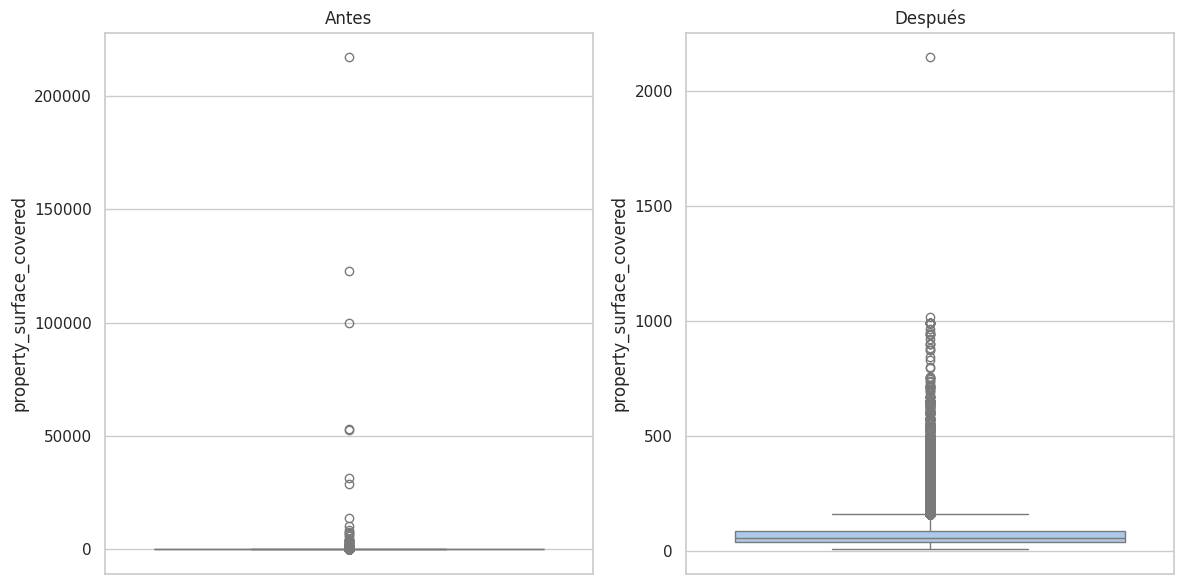

In [1309]:
#Comparación del antes y después del analisis de la variable
plot_comparativo(ds_atipicos, ds_train, 'property_surface_covered')

#### *Análisis según superficie total (property_surface_total)*



<Axes: ylabel='property_surface_total'>

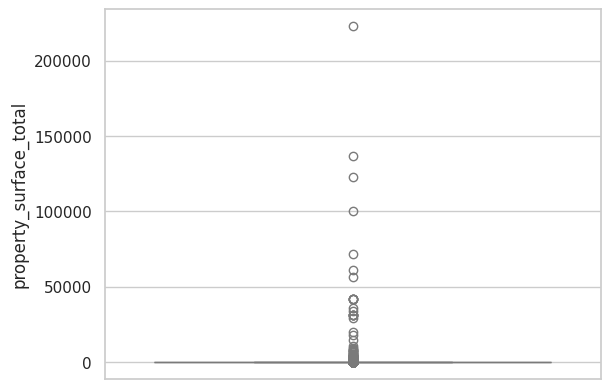

In [1310]:
sns.boxplot(y=ds_train.property_surface_total)

In [1311]:
limite_rango_iq(ds_train, 'property_surface_total')

(-45.0, 135.0)

In [1312]:
# Observación anómala
outlier = ds_train[ds_train['property_surface_total'] < 0]
outlier


Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [1313]:
# Comprobamos buscando indice con la propiedad con la mínima superficie.
min_surface_index = ds_train['property_surface_total'].idxmin()
ds_train.loc[min_surface_index]

id                          aZRjphLdiNfPd74mAGbrSg==
start_date                                2021-07-05
end_date                                  2021-08-09
created_on                       2021-07-05 00:00:00
latitud                                   -34.600832
longitud                                  -58.390383
place_l3                                  Tribunales
property_type                           Departamento
property_rooms                                   1.0
property_bedrooms                                1.0
property_surface_total                          10.0
property_surface_covered                        10.0
property_price                               35000.0
Name: 38433, dtype: object

 No existen propiedades con superficie negativa.
 Aún así, podemos ver que hay propiedades con superficies que si bien no son negativas, son demasiado pequeñas para el tipo de edificación.

In [1314]:
ds_train[ds_train['property_surface_total'] < 15]

id  start_date    end_date created_on  \
227332  em6zu1jxzH6eFzsNOQhHBQ==  2021-02-12  2021-03-05 2021-02-12   
168082  nOmTA76B5Fc56I5HKId9Dg==  2021-04-30  2021-06-03 2021-04-30   
326305  s4UQHlmed73o08wupnf2pg==  2021-08-27  9999-12-31 2021-08-27   
38433   aZRjphLdiNfPd74mAGbrSg==  2021-07-05  2021-08-09 2021-07-05   
180380  i16eZUm9vHNMrQMT82+9hQ==  2021-02-16  2021-12-09 2021-02-16   
76920   wNXQe4mGeSb2TxJgWd65PA==  2021-07-17  2021-07-20 2021-07-17   
333830  FfMyx7es1we4sMCZL2XVTw==  2021-12-28  2022-02-09 2021-12-28   
21153   us/N38vEYZarzdFzep5a9A==  2021-03-15  2021-03-25 2021-03-15   
408338  OsE/mlsNuKXTyHkubQmHlA==  2021-03-05  2021-05-04 2021-03-05   
268998  5GWt7TvAR8P5gOI8t1bVnw==  2021-01-19  2021-06-05 2021-01-19   
42084   F7uheixgxhdUgbKjRBtE4Q==  2021-01-12  2021-06-05 2021-01-12   
299     fWyBppiSbXhNSIjAmVDULg==  2021-09-09  2021-09-26 2021-09-09   
41903   AEb8UstVhCKA3+hCfJU86A==  2021-01-12  2021-06-05 2021-01-12   
72233   txvsZ+X6aRbIQLPPQ3wZ3w==  2021-05-29  2021-06-18 2021-05-29   
225485  LU1IAN2L0mz4+8+qGftckg==  2021-05-30  2021-06-18 2021-05-30   
168108  aO8mzZYRhXeP+QU7ilBhLw==  2021-04-30  2021-06-03 2021-04-30   
41088   ngtAPqtsUhn8Y9+r/FgteA==  2021-07-19  9999-12-31 2021-07-19   
216786  YrQqgOmS9no9pw9tljj8Pw==  2021-12-22  2022-01-27 2021-12-22   
50425   rBJcf/OUoNMDP0JylFF2Vg==  2021-06-23  2022-02-09 2021-06-23   
168064  au5LE/h6pCineDWdIhW/bA==  2021-04-30  2021-06-03 2021-04-30   
7869    WxvbiPA4bItk7Y2f7NSYJQ==  2021-02-09  9999-12-31 2021-02-09   
154950  /4B1aoAn2OzWObpjXevrmg==  2021-02-03  2022-09-01 2021-02-03   
32068   4jwFTdGy7N11fF14hLplcw==  2021-05-17  2021-06-05 2021-05-17   
41192   jLK6eCdVrULnEhLxS2kgUg==  2021-01-12  2021-02-05 2021-01-12   
41866   766MJy1wZVXIvaCTKrsisA==  2021-01-12  2021-06-05 2021-01-12   

          latitud   longitud          place_l3 property_type  property_rooms  \
227332 -34.633430 -58.480731          Floresta            PH             2.0   
168082 -34.606525 -58.430740         Caballito  Departamento             3.0   
326305 -34.606251 -58.384552       San Nicolás  Departamento             1.0   
38433  -34.600832 -58.390383        Tribunales  Departamento             1.0   
180380 -34.634265 -58.505317        Villa Luro  Departamento             3.0   
76920  -34.625870 -58.384003      Constitución  Departamento             1.0   
333830 -34.600456 -58.376960            Retiro  Departamento             1.0   
21153  -34.633819 -58.504568        Villa Luro  Departamento             3.0   
408338 -34.637323 -58.476409          Floresta  Departamento             1.0   
268998 -34.554519 -58.491599          Saavedra  Departamento             2.0   
42084  -34.583818 -58.495458  Villa Pueyrredón  Departamento             1.0   
299    -34.597934 -58.376981            Retiro  Departamento             1.0   
41903  -34.579301 -58.465854     Villa Ortuzar  Departamento             1.0   
72233  -34.597934 -58.376981            Retiro  Departamento             1.0   
225485 -34.597825 -58.376983            Retiro  Departamento             1.0   
168108 -34.606525 -58.430740         Caballito  Departamento             3.0   
41088  -34.614573 -58.480650  Villa del Parque  Departamento             2.0   
216786 -34.621967 -58.372598         San Telmo  Departamento             1.0   
50425  -34.644446 -58.418263           Pompeya  Departamento             1.0   
168064 -34.606525 -58.430740         Caballito  Departamento             3.0   
7869   -34.680073 -58.451069      Villa Lugano  Departamento             2.0   
154950 -34.637580 -58.500624        Villa Luro  Departamento             1.0   
32068  -34.571979 -58.446945          Belgrano  Departamento             3.0   
41192  -34.635506 -58.417926             Boedo            PH             4.0   
41866  -34.611753 -58.516570      Villa Devoto  Departamento             1.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
227332           1.0000

Por las razones ya expuestas y teniendo en cuenta que son todos departamentos, decidimos reemplazar los datos de superficie total por los de superficie cubierta.

In [1315]:
# Reemplazamos el valor de superficie cubierta por el de superficie total cuando el valor sea menor a 10
ds_train.loc[ds_train['property_surface_total'] < 15, 'property_surface_total'] = ds_train.loc[ds_train['property_surface_total'] < 15, 'property_surface_covered']

In [1316]:
# Revisamos y solo quedan aquellos casos donde la superficie cubierta también era menor a 15.
ds_train[ds_train['property_surface_total'] < 15]

id  start_date    end_date created_on  \
227332  em6zu1jxzH6eFzsNOQhHBQ==  2021-02-12  2021-03-05 2021-02-12   
168082  nOmTA76B5Fc56I5HKId9Dg==  2021-04-30  2021-06-03 2021-04-30   
326305  s4UQHlmed73o08wupnf2pg==  2021-08-27  9999-12-31 2021-08-27   
38433   aZRjphLdiNfPd74mAGbrSg==  2021-07-05  2021-08-09 2021-07-05   
76920   wNXQe4mGeSb2TxJgWd65PA==  2021-07-17  2021-07-20 2021-07-17   
333830  FfMyx7es1we4sMCZL2XVTw==  2021-12-28  2022-02-09 2021-12-28   
408338  OsE/mlsNuKXTyHkubQmHlA==  2021-03-05  2021-05-04 2021-03-05   
268998  5GWt7TvAR8P5gOI8t1bVnw==  2021-01-19  2021-06-05 2021-01-19   
42084   F7uheixgxhdUgbKjRBtE4Q==  2021-01-12  2021-06-05 2021-01-12   
299     fWyBppiSbXhNSIjAmVDULg==  2021-09-09  2021-09-26 2021-09-09   
41903   AEb8UstVhCKA3+hCfJU86A==  2021-01-12  2021-06-05 2021-01-12   
72233   txvsZ+X6aRbIQLPPQ3wZ3w==  2021-05-29  2021-06-18 2021-05-29   
225485  LU1IAN2L0mz4+8+qGftckg==  2021-05-30  2021-06-18 2021-05-30   
168108  aO8mzZYRhXeP+QU7ilBhLw==  2021-04-30  2021-06-03 2021-04-30   
216786  YrQqgOmS9no9pw9tljj8Pw==  2021-12-22  2022-01-27 2021-12-22   
50425   rBJcf/OUoNMDP0JylFF2Vg==  2021-06-23  2022-02-09 2021-06-23   
168064  au5LE/h6pCineDWdIhW/bA==  2021-04-30  2021-06-03 2021-04-30   
7869    WxvbiPA4bItk7Y2f7NSYJQ==  2021-02-09  9999-12-31 2021-02-09   
41866   766MJy1wZVXIvaCTKrsisA==  2021-01-12  2021-06-05 2021-01-12   

          latitud   longitud          place_l3 property_type  property_rooms  \
227332 -34.633430 -58.480731          Floresta            PH             2.0   
168082 -34.606525 -58.430740         Caballito  Departamento             3.0   
326305 -34.606251 -58.384552       San Nicolás  Departamento             1.0   
38433  -34.600832 -58.390383        Tribunales  Departamento             1.0   
76920  -34.625870 -58.384003      Constitución  Departamento             1.0   
333830 -34.600456 -58.376960            Retiro  Departamento             1.0   
408338 -34.637323 -58.476409          Floresta  Departamento             1.0   
268998 -34.554519 -58.491599          Saavedra  Departamento             2.0   
42084  -34.583818 -58.495458  Villa Pueyrredón  Departamento             1.0   
299    -34.597934 -58.376981            Retiro  Departamento             1.0   
41903  -34.579301 -58.465854     Villa Ortuzar  Departamento             1.0   
72233  -34.597934 -58.376981            Retiro  Departamento             1.0   
225485 -34.597825 -58.376983            Retiro  Departamento             1.0   
168108 -34.606525 -58.430740         Caballito  Departamento             3.0   
216786 -34.621967 -58.372598         San Telmo  Departamento             1.0   
50425  -34.644446 -58.418263           Pompeya  Departamento             1.0   
168064 -34.606525 -58.430740         Caballito  Departamento             3.0   
7869   -34.680073 -58.451069      Villa Lugano  Departamento             2.0   
41866  -34.611753 -58.516570      Villa Devoto  Departamento             1.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
227332                1.0                    13.0                      13.0   
168082                2.0                    12.0                      12.0   
326305                1.0                    11.0                      11.0   
38433                 1.0                    10.0                      10.0   
76920                 1.0                    14.0                      14.0   
333830                1.0                    14.0                      14.0   
408338                1.0                    14.0                      14.0   
268998                1.0                    14.0                      14.0   
42084                 1.0                    11.0                      11.0   
299                   1.0                    14.0                      14.0   
41903                 1.0                    11.0                      11.0   
72233                 1.0                    14.0           

In [1317]:
ds_train[ds_train['property_surface_total'] > 100000]

id  start_date    end_date created_on  \
1932    eQ/SiyES/mXWsSyAzb3k3A==  2021-12-17  9999-12-31 2021-12-17   
129214  tJ7TjXeyIl+4KPkaPqyAYA==  2021-07-01  9999-12-31 2021-07-01   
372779  XzTb7kTEpmAKiyhEGSWz4A==  2021-08-24  2021-09-03 2021-08-24   
405324  tHz32dZ72wYshPnoABftrg==  2021-01-07  2021-06-02 2021-01-07   

          latitud   longitud          place_l3 property_type  property_rooms  \
1932   -34.637026 -58.426283  Parque Chacabuco          Casa        3.178054   
129214 -34.599421 -58.386867      Barrio Norte  Departamento        5.000000   
372779 -34.555278 -58.459786          Belgrano  Departamento        4.000000   
405324 -34.569963 -58.481658     Villa Urquiza            PH        4.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
1932             2.890372                222836.0                   217.000   
129214           3.000000                137000.0                   135.000   
372779           3.000000                100068.0                   100.051   
405324           3.000000                123000.0                   123.000   

        property_price  
1932          250000.0  
129214        390000.0  
372779        420000.0  
405324        165000.0

En el caso de la propiedad de Parque Chacabuco, ninguno de los datos tiene coherencia al mirarlos en conjunto: una casa de 22.75 ambientes, y 17.23 habitaciones, con una superficie cubierta de 217.0 y total de 177198m^2. Tendriamos que imputar todos estos datos lo cual no tendría sentido, nos quedariamos con poco material real.

En los otros dos casos, parece ser más un error de escala asi que lo normalizamos.

In [1318]:
# Eliminamos outlier por indice
id_outlier = ds_train[ds_train['property_surface_total'] > 170000].index
ds_train.drop(id_outlier,inplace=True)

<ipython-input-1318-5a202d8d3887>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1319]:
# Modificamos los otros
condition = ds_train['property_surface_total'] > 100000
ds_train.loc[condition, 'property_surface_total'] /= 1000

ds_train[ds_train['property_surface_total'] > 100000]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [1320]:
ds_train[ds_train['property_surface_total'] > 7000]

id  start_date    end_date created_on  \
275253  5nXtCXuxHhkZ51syuRB7YQ==  2021-09-15  2021-10-07 2021-09-15   
84073   vMD1fCSS0kedOs8Bk/PCjA==  2021-02-05  2021-05-16 2021-02-05   
459841  9aQHQRqWMburSn+z+Qt5aQ==  2021-01-05  2021-01-09 2021-01-05   
219021  WQU6YIN+y4z30xaPRG4LHQ==  2021-03-07  2022-02-09 2021-03-07   
353009  f7xAHgUi1ruXPA9JxKGK6g==  2021-06-25  2021-08-10 2021-06-25   
405272  f0j0vRkfBQUg9LkKhc/Nmw==  2021-01-07  2021-01-09 2021-01-07   
362741  G7sKDYpvhrBrps0xzAQrmQ==  2021-01-16  2021-04-14 2021-01-16   
304492  Psg4w1RO9GxZAski6P2B8g==  2021-04-15  2021-06-05 2021-04-15   
1140    ddV7Ll5c1H+Rmqqovc+uFg==  2021-09-09  2022-01-27 2021-09-09   
324541  s0do8ciUehI3xXZNULgg+Q==  2021-03-03  2021-03-23 2021-03-03   
313745  fx1g9YinBKRFrlnCnN6p4Q==  2021-01-06  2021-01-09 2021-01-06   
352883  aBZBrjan1XqHjgvjHK6K6Q==  2021-06-25  2021-07-08 2021-06-25   
72316   BPTyNzwU2D4btCduu8ls3A==  2021-05-29  2021-06-08 2021-05-29   
370917  OC6HYSBo/pqio5ZTLgoPvg==  2021-04-24  2021-06-05 2021-04-24   
106598  +YPtNPAzbhoDCLgqF26Q8A==  2021-03-11  2021-04-20 2021-03-11   
370921  DhCI1Vz1PAu5fOy930TFXw==  2021-04-24  2021-06-05 2021-04-24   
264624  6uTpssfQ51+UbuvaOXfeRw==  2021-02-26  2021-03-01 2021-02-26   
263945  xTMT4WGUrto9Ee8CBjxUxw==  2021-02-26  2021-02-28 2021-02-26   
370922  MkaLWAz6PgutYgXwXxPEjQ==  2021-04-24  2021-06-05 2021-04-24   
370932  IQUQeru+sjv8TBWlLfs+SA==  2021-04-24  2021-06-05 2021-04-24   
459847  zMligt7YdiayCjrfqlmbfg==  2021-01-05  2021-01-09 2021-01-05   
459842  Y4PuRUaAW17tsLGwFTukhA==  2021-01-05  2021-01-09 2021-01-05   
370919  9p8XKpRRE9vzUT7Y/5FZ7Q==  2021-04-24  2021-06-05 2021-04-24   
72521   csbBJk04jQXgGZLXTj5WAg==  2021-05-29  2021-06-13 2021-05-29   
300394  E2FhGbtCzmdLHk9QEY47BA==  2021-08-10  2021-09-15 2021-08-10   
459849  +9w0GBZbuObF0Nw6AAtu2Q==  2021-01-05  2021-01-09 2021-01-05   

          latitud   longitud       place_l3 property_type  property_rooms  \
275253 -34.579163 -58.455725     Colegiales  Departamento             1.0   
84073  -34.588175 -58.396261       Recoleta  Departamento             1.0   
459841 -34.627876 -58.437996      Caballito  Departamento             3.0   
219021 -34.636532 -58.376406       Barracas  Departamento             4.0   
353009 -34.579163 -58.455725     Colegiales  Departamento             1.0   
405272 -34.634638 -58.473519       Floresta            PH             4.0   
362741 -34.579163 -58.455725     Colegiales  Departamento             1.0   
304492 -34.579163 -58.455725     Colegiales  Departamento             1.0   
1140   -34.605781 -58.376705    San Nicolás  Departamento             4.0   
324541 -34.628721 -58.421383          Boedo            PH             4.0   
313745 -34.649174 -58.413106        Pompeya            PH             6.0   
352883 -34.550093 -58.483034       Saavedra  Departamento             1.0   
72316  -34.578917 -58.429373        Palermo  Departamento             2.0   
370917 -34.571747 -58.422612        Palermo  Departamento             4.0   
106598 -34.587320 -58.401556   Barrio Norte  Departamento             2.0   
370921 -34.571747 -58.422612        Palermo  Departamento             5.0   
264624 -34.576139 -58.468259  Villa Ortuzar  Departamento             5.0   
263945 -34.576096 -58.441278        Palermo  Departamento             3.0   
370922 -34.571747 -58.422612        Palermo  Departamento             5.0   
370932 -34.571747 -58.422612        Palermo  Departamento             4.0   
459847 -34.628247 -58.437696      Caballito  Departamento             4.0   
459842 -34.628397 -58.437706      Caballito  Departamento             3.0   
370919 -34.571747 -58.422612        Palermo  Departamento             5.0   
72521  -34.600113 -58.403649      Balvanera  Departamento             2.0   
300394 -34.579163 -58.455725     Colegiales  Departamento             1.0   
459849 -34.628282 -58.437803      Caballito  Departamento             3.0   

        property_bedrooms  prope

Se ve una tendencia entre la superficie total y la superficie cubierta que indicaría un error de escala. Vamos a corregirlo.

In [1321]:
# Buscamos las filas donde property_surface_total / 100 == property_surface_covered y hacemos una máscara.
mask = ds_train['property_surface_total'] / 100 == ds_train['property_surface_covered']

# Reemplazamos property_surface_total con property_surface_covered en esos casos
ds_train.loc[mask, 'property_surface_total'] = ds_train.loc[mask, 'property_surface_covered']

In [1322]:
ds_train[ds_train['property_surface_total'] > 7000]

id  start_date    end_date created_on  \
275253  5nXtCXuxHhkZ51syuRB7YQ==  2021-09-15  2021-10-07 2021-09-15   
84073   vMD1fCSS0kedOs8Bk/PCjA==  2021-02-05  2021-05-16 2021-02-05   
219021  WQU6YIN+y4z30xaPRG4LHQ==  2021-03-07  2022-02-09 2021-03-07   
353009  f7xAHgUi1ruXPA9JxKGK6g==  2021-06-25  2021-08-10 2021-06-25   
405272  f0j0vRkfBQUg9LkKhc/Nmw==  2021-01-07  2021-01-09 2021-01-07   
362741  G7sKDYpvhrBrps0xzAQrmQ==  2021-01-16  2021-04-14 2021-01-16   
304492  Psg4w1RO9GxZAski6P2B8g==  2021-04-15  2021-06-05 2021-04-15   
324541  s0do8ciUehI3xXZNULgg+Q==  2021-03-03  2021-03-23 2021-03-03   
313745  fx1g9YinBKRFrlnCnN6p4Q==  2021-01-06  2021-01-09 2021-01-06   
352883  aBZBrjan1XqHjgvjHK6K6Q==  2021-06-25  2021-07-08 2021-06-25   
72316   BPTyNzwU2D4btCduu8ls3A==  2021-05-29  2021-06-08 2021-05-29   
370917  OC6HYSBo/pqio5ZTLgoPvg==  2021-04-24  2021-06-05 2021-04-24   
106598  +YPtNPAzbhoDCLgqF26Q8A==  2021-03-11  2021-04-20 2021-03-11   
370921  DhCI1Vz1PAu5fOy930TFXw==  2021-04-24  2021-06-05 2021-04-24   
264624  6uTpssfQ51+UbuvaOXfeRw==  2021-02-26  2021-03-01 2021-02-26   
263945  xTMT4WGUrto9Ee8CBjxUxw==  2021-02-26  2021-02-28 2021-02-26   
370922  MkaLWAz6PgutYgXwXxPEjQ==  2021-04-24  2021-06-05 2021-04-24   
370932  IQUQeru+sjv8TBWlLfs+SA==  2021-04-24  2021-06-05 2021-04-24   
459847  zMligt7YdiayCjrfqlmbfg==  2021-01-05  2021-01-09 2021-01-05   
459842  Y4PuRUaAW17tsLGwFTukhA==  2021-01-05  2021-01-09 2021-01-05   
370919  9p8XKpRRE9vzUT7Y/5FZ7Q==  2021-04-24  2021-06-05 2021-04-24   
72521   csbBJk04jQXgGZLXTj5WAg==  2021-05-29  2021-06-13 2021-05-29   
300394  E2FhGbtCzmdLHk9QEY47BA==  2021-08-10  2021-09-15 2021-08-10   
459849  +9w0GBZbuObF0Nw6AAtu2Q==  2021-01-05  2021-01-09 2021-01-05   

          latitud   longitud       place_l3 property_type  property_rooms  \
275253 -34.579163 -58.455725     Colegiales  Departamento             1.0   
84073  -34.588175 -58.396261       Recoleta  Departamento             1.0   
219021 -34.636532 -58.376406       Barracas  Departamento             4.0   
353009 -34.579163 -58.455725     Colegiales  Departamento             1.0   
405272 -34.634638 -58.473519       Floresta            PH             4.0   
362741 -34.579163 -58.455725     Colegiales  Departamento             1.0   
304492 -34.579163 -58.455725     Colegiales  Departamento             1.0   
324541 -34.628721 -58.421383          Boedo            PH             4.0   
313745 -34.649174 -58.413106        Pompeya            PH             6.0   
352883 -34.550093 -58.483034       Saavedra  Departamento             1.0   
72316  -34.578917 -58.429373        Palermo  Departamento             2.0   
370917 -34.571747 -58.422612        Palermo  Departamento             4.0   
106598 -34.587320 -58.401556   Barrio Norte  Departamento             2.0   
370921 -34.571747 -58.422612        Palermo  Departamento             5.0   
264624 -34.576139 -58.468259  Villa Ortuzar  Departamento             5.0   
263945 -34.576096 -58.441278        Palermo  Departamento             3.0   
370922 -34.571747 -58.422612        Palermo  Departamento             5.0   
370932 -34.571747 -58.422612        Palermo  Departamento             4.0   
459847 -34.628247 -58.437696      Caballito  Departamento             4.0   
459842 -34.628397 -58.437706      Caballito  Departamento             3.0   
370919 -34.571747 -58.422612        Palermo  Departamento             5.0   
72521  -34.600113 -58.403649      Balvanera  Departamento             2.0   
300394 -34.579163 -58.455725     Colegiales  Departamento             1.0   
459849 -34.628282 -58.437803      Caballito  Departamento             3.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
275253                1.0                 31000.0                    26.000   
84073                 1.0                 36000.0                    30.000   
219021                3.0                 72060.0                    90.000   
353009      

Algunos registros específicos parecen ser errores de tipeo/escala. Los corregimos manualmente y el resto serán corregidos logaritmicamente.

In [1323]:
# Corección de error de tipeo/escala
condition = (ds_train['property_surface_total'] == 31000) & (ds_train['property_surface_covered'] == 26)
condition2 = (ds_train['property_surface_total'] == 42110.0) & (ds_train['property_surface_covered'] == 307)
ds_train.loc[condition, 'property_surface_total'] /= 1000
ds_train.loc[condition2, 'property_surface_total'] /= 100


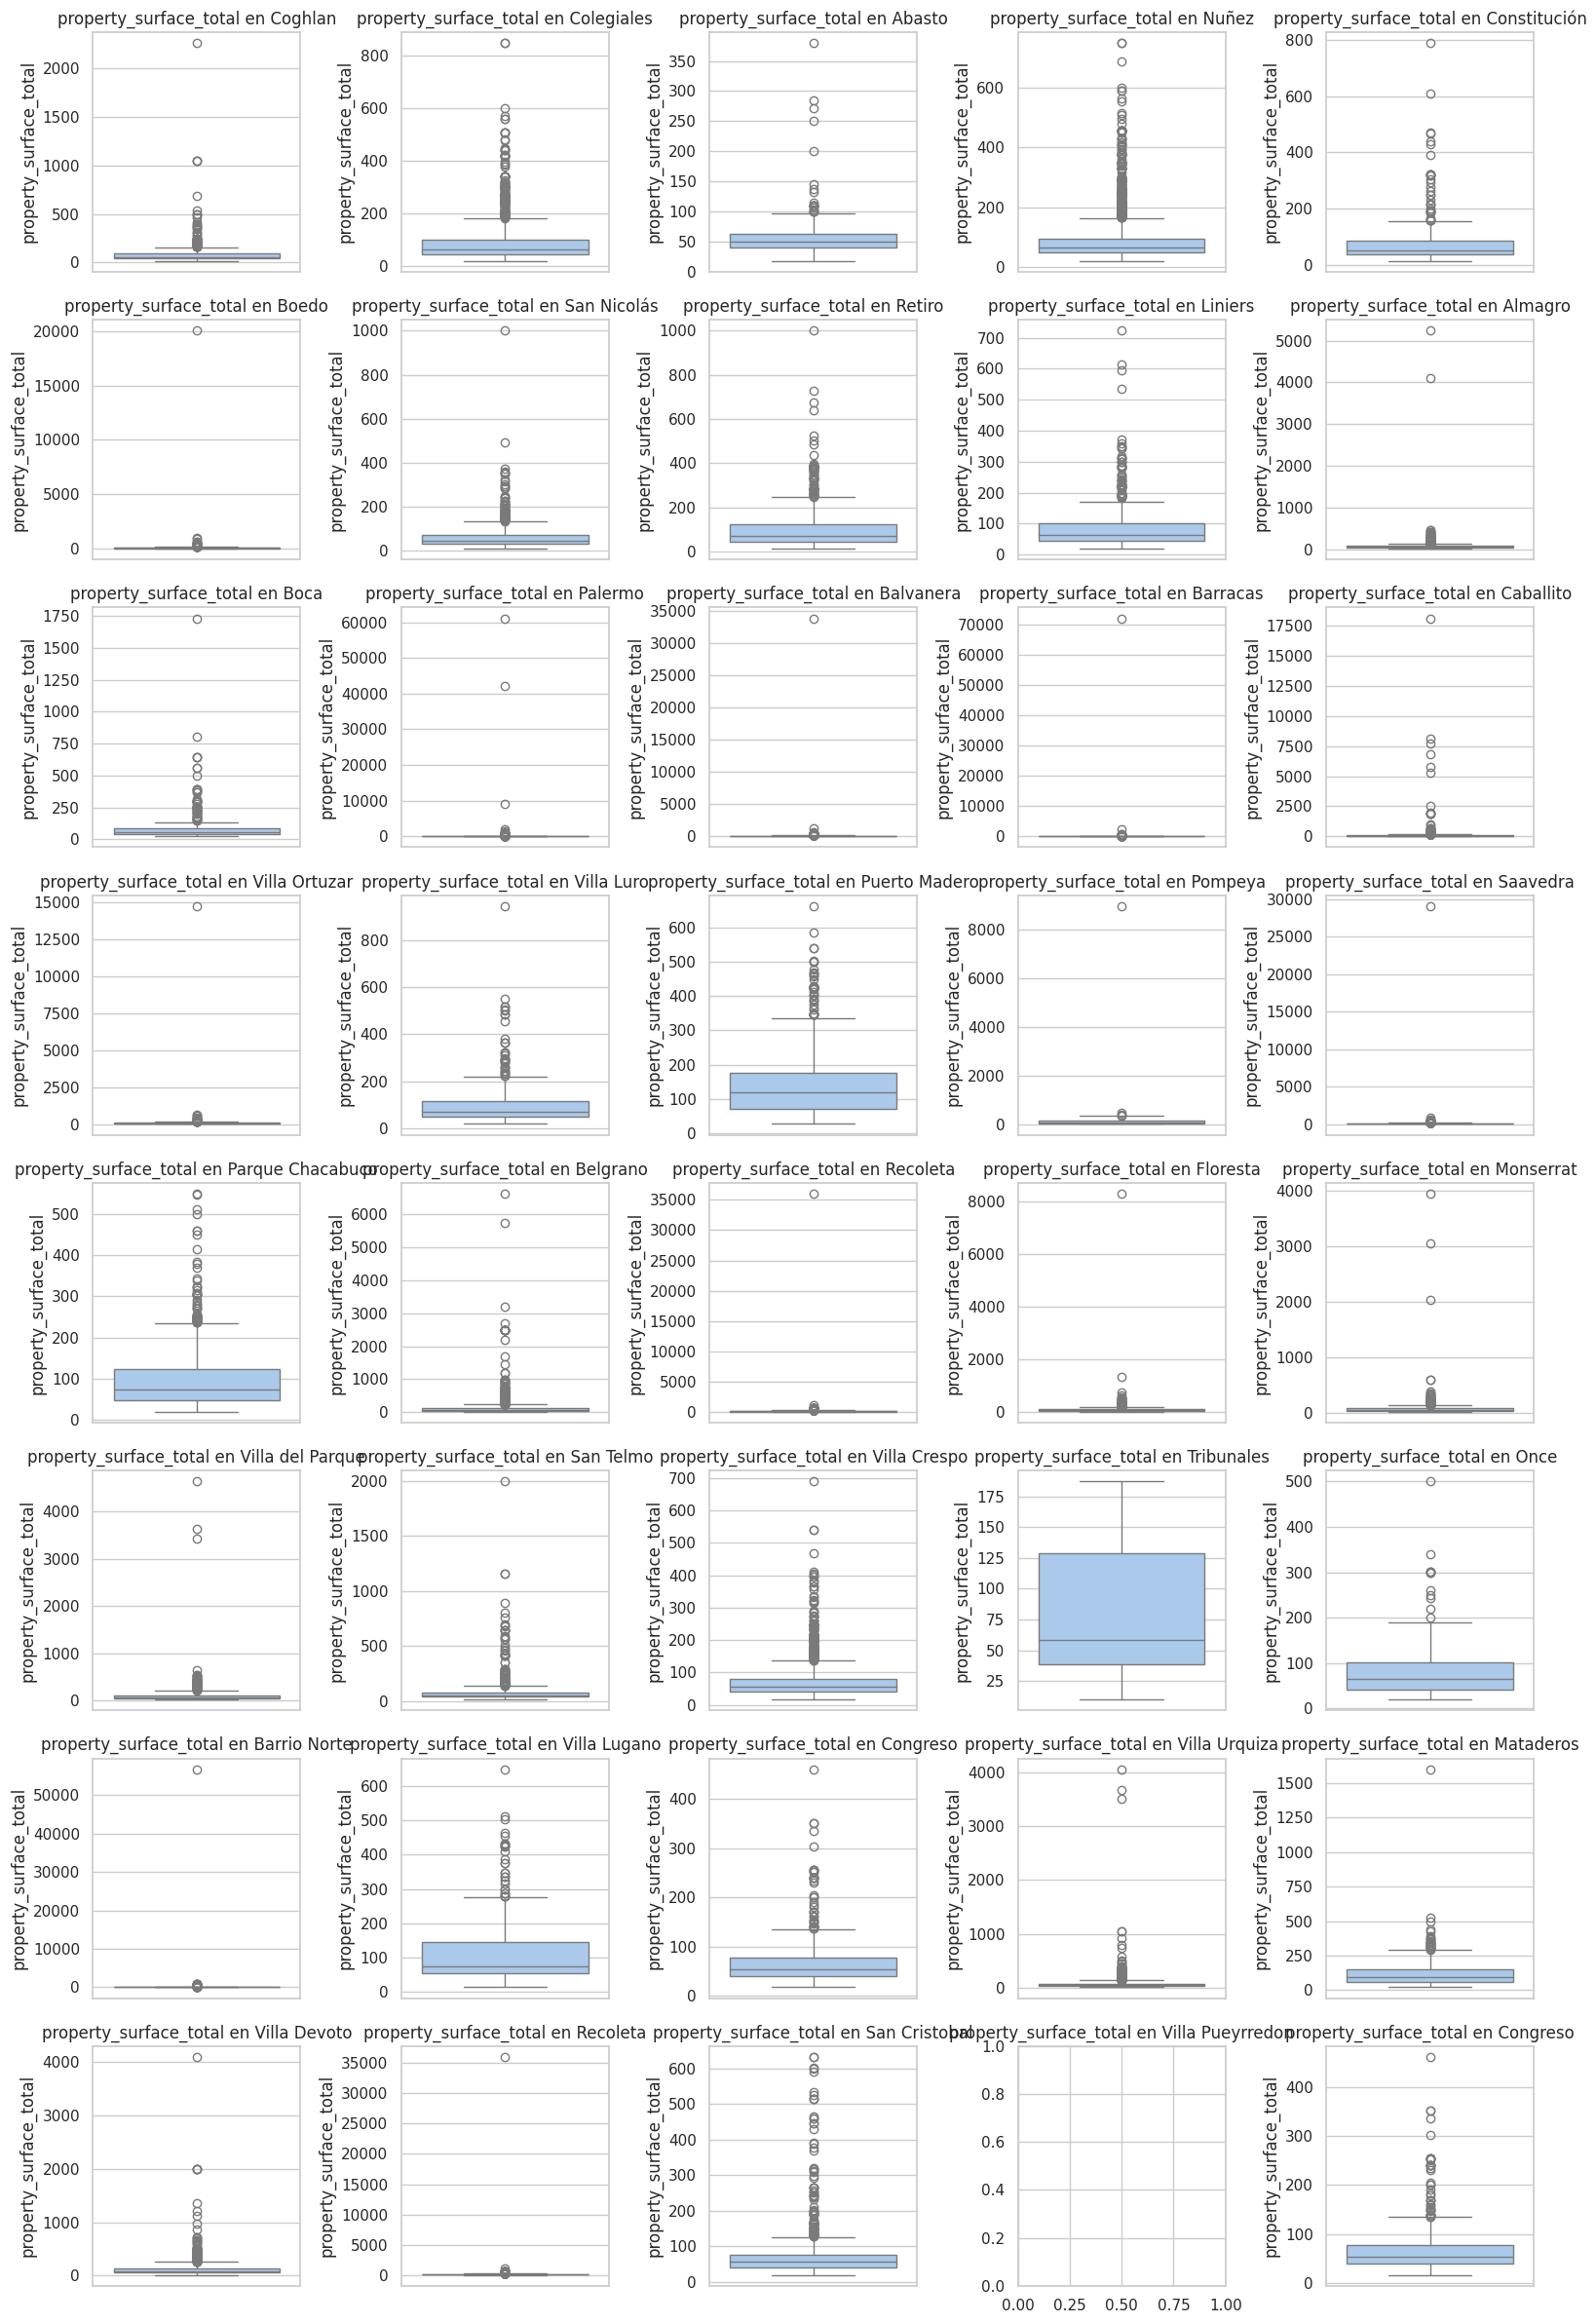

In [1324]:
plot_por_barrio(ds_train, 'property_surface_total')

Podemos ver en las comparaciones de los barrios que incluso en aquellos que tienen más variaciones de tamaño de superficie total, los valores por encima de 3000 son outliers extremos, asi que normalizaremos esos valores.

In [1325]:
# Corrección logaritmica
ds_train.loc[(ds_train['property_surface_total'] > 3000.0), 'property_surface_total'] = np.log(ds_train['property_surface_total'])

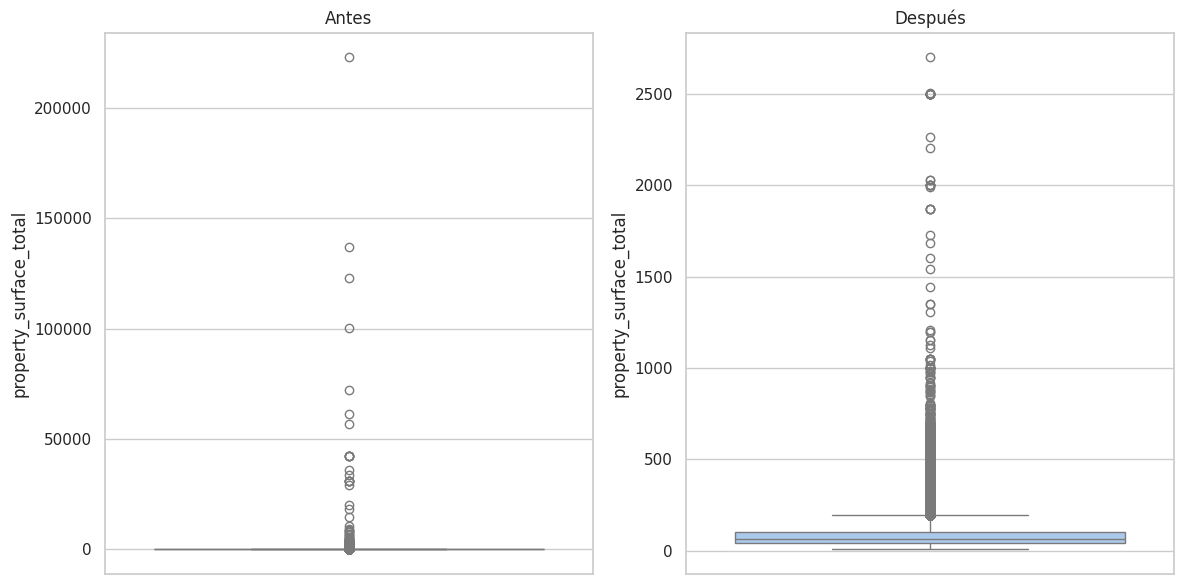

In [1326]:
#Comparación del antes y después del analisis de la variable
plot_comparativo(ds_atipicos, ds_train, 'property_surface_total')

#### **Z-Score, normal y modificado**

In [1327]:
def plot_z(df, variable):
  plt.hist(df[variable])
  plt.title("Histograma Z-Score "+ variable)
  plt.xlabel("Z-Score "+variable)
  plt.tight_layout()
  plt.show()
  return

<ipython-input-1328-1ce1084e760a>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-1328-1ce1084e760a>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



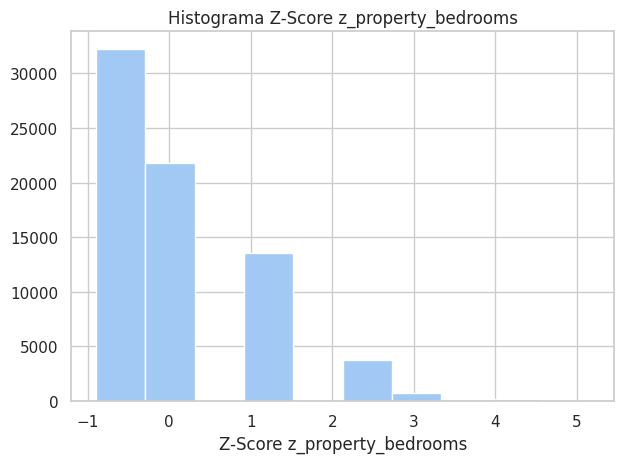

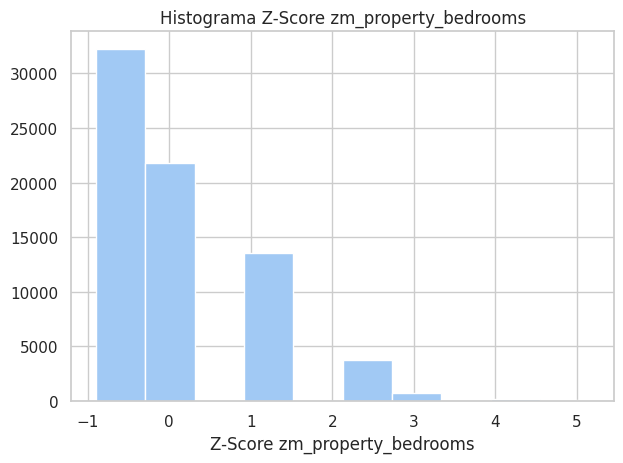

In [1328]:
# Z Score property_bedrooms
ds_train['z_property_bedrooms'] = calculo_z_score(ds_train.property_bedrooms)
ds_train['zm_property_bedrooms'] = calculo_z_score(ds_train.property_bedrooms)

plot_z(ds_train, 'z_property_bedrooms')
plot_z(ds_train, 'zm_property_bedrooms')


In [1329]:
ds_train[(ds_train['z_property_bedrooms'] > 3.5)]

id  start_date    end_date created_on  \
98636   fbkHJSzstPUbAVU5a4yrUw==  2021-02-19  2021-04-15 2021-02-19   
325001  l31HOpjyKP0mmTRsTKOdIg==  2021-03-03  2021-03-10 2021-03-03   
378857  KHoP20DEngLCSx16dgF4Vw==  2021-05-19  2021-05-26 2021-05-19   
114642  Wp7uojpeBF6gsygB4sE+Vw==  2021-12-07  2022-01-27 2021-12-07   
432687  XuYO4J/ot4zoK3UC16M2fQ==  2021-05-04  2021-05-19 2021-05-04   
...                          ...         ...         ...        ...   
111428  3XZ377CfRfsjXSsh5QFLKQ==  2021-10-19  9999-12-31 2021-10-19   
331525  X9jsyknsuCuHNBef06vk7Q==  2021-01-01  2021-01-02 2021-01-01   
127869  SrqzeeTw4A/Cmp0FKfnwCg==  2021-07-01  2021-07-03 2021-07-01   
434923  DEwGJtFu1BfuBFbDTOTbrg==  2021-08-25  2021-11-03 2021-08-25   
101719  PpCseiKpFgucEB+a1H+zdQ==  2021-05-28  2021-06-05 2021-05-28   

          latitud   longitud          place_l3 property_type  property_rooms  \
98636  -34.637484 -58.460145  Parque Chacabuco          Casa             7.0   
325001 -34.621184 -58.394458     San Cristobal            PH             8.0   
378857 -34.620836 -58.376823         San Telmo          Casa             9.0   
114642 -34.536092 -58.467201             Nuñez          Casa             7.0   
432687 -34.617556 -58.439421         Caballito            PH             6.0   
...           ...        ...               ...           ...             ...   
111428 -34.599525 -58.401587      Barrio Norte  Departamento             8.0   
331525 -34.629600 -58.364400              Boca  Departamento             8.0   
127869 -34.613363 -58.445880         Caballito            PH             7.0   
434923 -34.576059 -58.479835     Villa Urquiza            PH             7.0   
101719 -34.651465 -58.424129           Pompeya          Casa             8.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
98636                 6.0                   257.0                     226.0   
325001                6.0                   525.0                     425.0   
378857                6.0                   414.0                     414.0   
114642                6.0                   240.0                     215.0   
432687                6.0                   155.0                     120.0   
...                   ...                     ...                       ...   
111428                7.0                   282.0                     195.0   
331525                6.0                   166.0                     144.0   
127869                6.0                   199.0                     180.0   
434923                6.0                   321.0                     296.0   
101719                7.0                   320.0                     306.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
98636         205000.0             4.143716              4.143716  
325001        800000.0             4.143716              4.143716  
378857        450000.0             4.143716              4.143716  
114642        449000.0             4.143716              4.143716  
432687        250000.0             4.143716              4.143716  
...                ...                  ...                   ...  
111428        240000.0             5.151731              5.151731  
331525        190000.0             4.143716              4.143716  
127869        235000.0             4.143716              4.143716  
434923        465000.0             4.143716              4.143716  
101719        241000.0             5.151731              5.151731  

[274 rows x 15 columns]

In [1330]:
ds_train[(ds_train['zm_property_bedrooms'] > 3.5)]

id  start_date    end_date created_on  \
98636   fbkHJSzstPUbAVU5a4yrUw==  2021-02-19  2021-04-15 2021-02-19   
325001  l31HOpjyKP0mmTRsTKOdIg==  2021-03-03  2021-03-10 2021-03-03   
378857  KHoP20DEngLCSx16dgF4Vw==  2021-05-19  2021-05-26 2021-05-19   
114642  Wp7uojpeBF6gsygB4sE+Vw==  2021-12-07  2022-01-27 2021-12-07   
432687  XuYO4J/ot4zoK3UC16M2fQ==  2021-05-04  2021-05-19 2021-05-04   
...                          ...         ...         ...        ...   
111428  3XZ377CfRfsjXSsh5QFLKQ==  2021-10-19  9999-12-31 2021-10-19   
331525  X9jsyknsuCuHNBef06vk7Q==  2021-01-01  2021-01-02 2021-01-01   
127869  SrqzeeTw4A/Cmp0FKfnwCg==  2021-07-01  2021-07-03 2021-07-01   
434923  DEwGJtFu1BfuBFbDTOTbrg==  2021-08-25  2021-11-03 2021-08-25   
101719  PpCseiKpFgucEB+a1H+zdQ==  2021-05-28  2021-06-05 2021-05-28   

          latitud   longitud          place_l3 property_type  property_rooms  \
98636  -34.637484 -58.460145  Parque Chacabuco          Casa             7.0   
325001 -34.621184 -58.394458     San Cristobal            PH             8.0   
378857 -34.620836 -58.376823         San Telmo          Casa             9.0   
114642 -34.536092 -58.467201             Nuñez          Casa             7.0   
432687 -34.617556 -58.439421         Caballito            PH             6.0   
...           ...        ...               ...           ...             ...   
111428 -34.599525 -58.401587      Barrio Norte  Departamento             8.0   
331525 -34.629600 -58.364400              Boca  Departamento             8.0   
127869 -34.613363 -58.445880         Caballito            PH             7.0   
434923 -34.576059 -58.479835     Villa Urquiza            PH             7.0   
101719 -34.651465 -58.424129           Pompeya          Casa             8.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
98636                 6.0                   257.0                     226.0   
325001                6.0                   525.0                     425.0   
378857                6.0                   414.0                     414.0   
114642                6.0                   240.0                     215.0   
432687                6.0                   155.0                     120.0   
...                   ...                     ...                       ...   
111428                7.0                   282.0                     195.0   
331525                6.0                   166.0                     144.0   
127869                6.0                   199.0                     180.0   
434923                6.0                   321.0                     296.0   
101719                7.0                   320.0                     306.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
98636         205000.0             4.143716              4.143716  
325001        800000.0             4.143716              4.143716  
378857        450000.0             4.143716              4.143716  
114642        449000.0             4.143716              4.143716  
432687        250000.0             4.143716              4.143716  
...                ...                  ...                   ...  
111428        240000.0             5.151731              5.151731  
331525        190000.0             4.143716              4.143716  
127869        235000.0             4.143716              4.143716  
434923        465000.0             4.143716              4.143716  
101719        241000.0             5.151731              5.151731  

[274 rows x 15 columns]

In [1331]:
ds_train[(ds_train['z_property_bedrooms'] < -1)]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_property_bedrooms, zm_property_bedrooms]
Index: []

In [1332]:
ds_train[(ds_train['zm_property_bedrooms'] < -1)]

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_property_bedrooms, zm_property_bedrooms]
Index: []

Siguiendo el Z score, podemos ver que no existen outliers negativos, incluso usando un valor mínimo de -1. Usando la regla de oro de 3.5, podemos ver que si lo existen positivos y en una cantidad bastante significativa (275 registros). Vamos a ampliar ligeramente este factor.

In [1333]:
ds_train[(ds_train['z_property_bedrooms'] > 5)]

id  start_date    end_date created_on  \
398724  t0mG+MlvoUEuQxyELQvmgg==  2021-02-13  2021-07-26 2021-02-13   
393372  7nxreTyKxab7bspnoAodSQ==  2021-02-13  2021-03-01 2021-02-13   
32619   TbCOFDdGTcs31yjaxega9Q==  2021-12-04  2022-01-27 2021-12-04   
420396  O8oyYGBUdY3jPaEa1NK6Xg==  2021-12-01  2021-12-30 2021-12-01   
449622  YxjhWpsXv+4ySaNcSmtSxw==  2021-12-16  2022-02-09 2021-12-16   
...                          ...         ...         ...        ...   
354636  jMJzyQRQyB7RMx45YwYLCw==  2021-03-31  2021-11-03 2021-03-31   
145014  HnDSgqWxaI2YuMfynbJH9g==  2021-07-29  2021-11-14 2021-07-29   
72640   RBSIx9grSfooVB473NbCfA==  2021-05-29  2021-07-22 2021-05-29   
111428  3XZ377CfRfsjXSsh5QFLKQ==  2021-10-19  9999-12-31 2021-10-19   
101719  PpCseiKpFgucEB+a1H+zdQ==  2021-05-28  2021-06-05 2021-05-28   

          latitud   longitud          place_l3 property_type  property_rooms  \
398724 -34.604668 -58.396573         Balvanera  Departamento             8.0   
393372 -34.612133 -58.406925         Balvanera            PH             6.0   
32619  -34.632730 -58.434728  Parque Chacabuco          Casa             8.0   
420396 -34.593316 -58.377201            Retiro  Departamento             9.0   
449622 -34.546268 -58.459154             Nuñez            PH             8.0   
...           ...        ...               ...           ...             ...   
354636 -34.641514 -58.367007              Boca            PH            10.0   
145014 -34.585590 -58.448516         Chacarita          Casa             8.0   
72640  -34.602843 -58.386216       San Nicolás  Departamento             8.0   
111428 -34.599525 -58.401587      Barrio Norte  Departamento             8.0   
101719 -34.651465 -58.424129           Pompeya          Casa             8.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
398724                7.0                   247.0                     232.0   
393372                7.0                    67.0                      58.0   
32619                 7.0                   306.0                     272.0   
420396                7.0                   380.0                     350.0   
449622                7.0                   246.0                     172.0   
...                   ...                     ...                       ...   
354636                7.0                   123.0                     118.0   
145014                7.0                   230.0                     230.0   
72640                 7.0                   195.0                     190.0   
111428                7.0                   282.0                     195.0   
101719                7.0                   320.0                     306.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
398724        360000.0             5.151731              5.151731  
393372        128000.0             5.151731              5.151731  
32619         485000.0             5.151731              5.151731  
420396        650000.0             5.151731              5.151731  
449622        370000.0             5.151731              5.151731  
...                ...                  ...                   ...  
354636        150000.0             5.151731              5.151731  
145014        410000.0             5.151731              5.151731  
72640         198000.0             5.151731              5.151731  
111428        240000.0             5.151731              5.151731  
101719        241000.0             5.151731              5.151731  

[85 rows x 15 columns]

No podemos sacar ninguna conclusión de los registros, así que esperaremos al análisis multivariado para tomar decisiones al respecto de estos outliers.

### Análisis multivariado

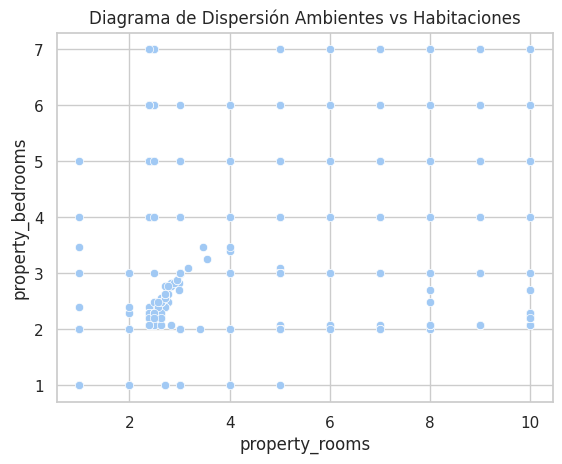

In [1334]:
sns.scatterplot(y=ds_train["property_bedrooms"], x=ds_train["property_rooms"])
plt.title("Diagrama de Dispersión Ambientes vs Habitaciones")
plt.show()

En el analisis univariado solucionamos los outliers imposibles.  

In [1335]:
ds_train[(ds_train['property_rooms'] < ds_train['property_bedrooms'])]

id  start_date    end_date created_on  \
115490  4SB68b9pUEe+GxRTEbEbDw==  2021-12-07  2022-01-27 2021-12-07   
393372  7nxreTyKxab7bspnoAodSQ==  2021-02-13  2021-03-01 2021-02-13   
404398  2h+d0j/474llaBCMxsopeA==  2021-08-13  2022-02-09 2021-08-13   
115481  WQtd+fpYGscEqzse5BCckA==  2021-12-07  2022-01-27 2021-12-07   
115502  tNDmYqYiETKsquAIP857XA==  2021-12-07  2022-01-27 2021-12-07   
...                          ...         ...         ...        ...   
337805  U+eSSM88Ljzr3NMDIv1Pfg==  2021-04-13  2021-08-26 2021-04-13   
327198  esxiqYvv1iIBD/rNWm4Z1g==  2021-12-14  2022-01-27 2021-12-14   
276086  26ynaivxGjWUJwbcP5zKfg==  2021-12-23  2022-01-27 2021-12-23   
272619  6Jlr02++Y531Z+TAC4+K6w==  2021-02-21  2021-08-04 2021-02-21   
115487  Bgj611hVzVOnofZ0eY0unA==  2021-12-07  2022-01-27 2021-12-07   

          latitud   longitud          place_l3 property_type  property_rooms  \
115490 -34.613037 -58.360984     Puerto Madero  Departamento        3.000000   
393372 -34.612133 -58.406925         Balvanera            PH        6.000000   
404398 -34.632353 -58.470828            Flores  Departamento        3.000000   
115481 -34.613037 -58.360984     Puerto Madero  Departamento        3.000000   
115502 -34.613261 -58.361513     Puerto Madero  Departamento        3.000000   
...           ...        ...               ...           ...             ...   
337805 -34.608162 -58.453786         Caballito          Casa        5.000000   
327198 -34.555071 -58.464449             Nuñez          Casa        2.484907   
276086 -34.639591 -58.442952  Parque Chacabuco            PH        3.000000   
272619 -34.553019 -58.448407          Belgrano          Casa        2.397895   
115487 -34.613037 -58.360984     Puerto Madero  Departamento        3.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
115490                4.0                   170.0                     166.0   
393372                7.0                    67.0                      58.0   
404398                4.0                    80.0                      70.0   
115481                4.0                   170.0                     166.0   
115502                4.0                   170.0                     166.0   
...                   ...                     ...                       ...   
337805                6.0                   366.0                     140.0   
327198                4.0                   350.0                     350.0   
276086                5.0                   117.0                      98.0   
272619                6.0                   527.0                     440.0   
115487                4.0                   170.0                     166.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
115490       1050000.0             2.127685              2.127685  
393372        128000.0             5.151731              5.151731  
404398        119900.0             2.127685              2.127685  
115481       1050000.0             2.127685              2.127685  
115502       1300000.0             2.127685              2.127685  
...                ...                  ...                   ...  
337805        320000.0             4.143716              4.143716  
327198       1200000.0             2.127685              2.127685  
276086        119000.0             3.135701              3.135701  
272619        895000.0             4.143716              4.143716  
115487       1050000.0             2.127685              2.127685  

[129 rows x 15 columns]

Tenemos 130 registros en los que el número de habitaciones es mayor que el de ambientes.

In [1336]:
# Caso: más habitaciones que ambientes
condition= (ds_train['property_rooms'] < ds_train['property_bedrooms'])
ds_train[condition]

id  start_date    end_date created_on  \
115490  4SB68b9pUEe+GxRTEbEbDw==  2021-12-07  2022-01-27 2021-12-07   
393372  7nxreTyKxab7bspnoAodSQ==  2021-02-13  2021-03-01 2021-02-13   
404398  2h+d0j/474llaBCMxsopeA==  2021-08-13  2022-02-09 2021-08-13   
115481  WQtd+fpYGscEqzse5BCckA==  2021-12-07  2022-01-27 2021-12-07   
115502  tNDmYqYiETKsquAIP857XA==  2021-12-07  2022-01-27 2021-12-07   
...                          ...         ...         ...        ...   
337805  U+eSSM88Ljzr3NMDIv1Pfg==  2021-04-13  2021-08-26 2021-04-13   
327198  esxiqYvv1iIBD/rNWm4Z1g==  2021-12-14  2022-01-27 2021-12-14   
276086  26ynaivxGjWUJwbcP5zKfg==  2021-12-23  2022-01-27 2021-12-23   
272619  6Jlr02++Y531Z+TAC4+K6w==  2021-02-21  2021-08-04 2021-02-21   
115487  Bgj611hVzVOnofZ0eY0unA==  2021-12-07  2022-01-27 2021-12-07   

          latitud   longitud          place_l3 property_type  property_rooms  \
115490 -34.613037 -58.360984     Puerto Madero  Departamento        3.000000   
393372 -34.612133 -58.406925         Balvanera            PH        6.000000   
404398 -34.632353 -58.470828            Flores  Departamento        3.000000   
115481 -34.613037 -58.360984     Puerto Madero  Departamento        3.000000   
115502 -34.613261 -58.361513     Puerto Madero  Departamento        3.000000   
...           ...        ...               ...           ...             ...   
337805 -34.608162 -58.453786         Caballito          Casa        5.000000   
327198 -34.555071 -58.464449             Nuñez          Casa        2.484907   
276086 -34.639591 -58.442952  Parque Chacabuco            PH        3.000000   
272619 -34.553019 -58.448407          Belgrano          Casa        2.397895   
115487 -34.613037 -58.360984     Puerto Madero  Departamento        3.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
115490                4.0                   170.0                     166.0   
393372                7.0                    67.0                      58.0   
404398                4.0                    80.0                      70.0   
115481                4.0                   170.0                     166.0   
115502                4.0                   170.0                     166.0   
...                   ...                     ...                       ...   
337805                6.0                   366.0                     140.0   
327198                4.0                   350.0                     350.0   
276086                5.0                   117.0                      98.0   
272619                6.0                   527.0                     440.0   
115487                4.0                   170.0                     166.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
115490       1050000.0             2.127685              2.127685  
393372        128000.0             5.151731              5.151731  
404398        119900.0             2.127685              2.127685  
115481       1050000.0             2.127685              2.127685  
115502       1300000.0             2.127685              2.127685  
...                ...                  ...                   ...  
337805        320000.0             4.143716              4.143716  
327198       1200000.0             2.127685              2.127685  
276086        119000.0             3.135701              3.135701  
272619        895000.0             4.143716              4.143716  
115487       1050000.0             2.127685              2.127685  

[129 rows x 15 columns]

Varios de estos registros tienen valores irracionales para una habitación (2.397... en vez de números enteros) y podrían haber sido resultados de imputaciones y transformaciones anteriores.
Una solución podría ser copiar los valores de habitaciones a ambientes, pero previniendo que algunos puedan ser valores verdaderos y para que no se pierdan, probaremos invirtiendo las columnas de estos casos en específico ya que muchos tienen sentido de esa manera (casas con 6 ambientes y 4 habitaciones, departamentos de 2 ambientes y una habitación, por dar unos ejemplos). Es un cambio riesgoso pero se tendrá en cuenta por si llegara a haber discrepancias en resultados futuros.

In [1337]:
# Creamos una máscara booleana para nuestra condición
mask = ds_train['property_rooms'] < ds_train['property_bedrooms']

# Invertimos los valores usando la máscara
ds_train.loc[mask, ['property_rooms', 'property_bedrooms']] = ds_train.loc[mask, ['property_bedrooms', 'property_rooms']].values


In [1338]:
ds_train[(ds_train['z_property_bedrooms'] > 3.5)]

id  start_date    end_date created_on  \
98636   fbkHJSzstPUbAVU5a4yrUw==  2021-02-19  2021-04-15 2021-02-19   
325001  l31HOpjyKP0mmTRsTKOdIg==  2021-03-03  2021-03-10 2021-03-03   
378857  KHoP20DEngLCSx16dgF4Vw==  2021-05-19  2021-05-26 2021-05-19   
114642  Wp7uojpeBF6gsygB4sE+Vw==  2021-12-07  2022-01-27 2021-12-07   
432687  XuYO4J/ot4zoK3UC16M2fQ==  2021-05-04  2021-05-19 2021-05-04   
...                          ...         ...         ...        ...   
111428  3XZ377CfRfsjXSsh5QFLKQ==  2021-10-19  9999-12-31 2021-10-19   
331525  X9jsyknsuCuHNBef06vk7Q==  2021-01-01  2021-01-02 2021-01-01   
127869  SrqzeeTw4A/Cmp0FKfnwCg==  2021-07-01  2021-07-03 2021-07-01   
434923  DEwGJtFu1BfuBFbDTOTbrg==  2021-08-25  2021-11-03 2021-08-25   
101719  PpCseiKpFgucEB+a1H+zdQ==  2021-05-28  2021-06-05 2021-05-28   

          latitud   longitud          place_l3 property_type  property_rooms  \
98636  -34.637484 -58.460145  Parque Chacabuco          Casa             7.0   
325001 -34.621184 -58.394458     San Cristobal            PH             8.0   
378857 -34.620836 -58.376823         San Telmo          Casa             9.0   
114642 -34.536092 -58.467201             Nuñez          Casa             7.0   
432687 -34.617556 -58.439421         Caballito            PH             6.0   
...           ...        ...               ...           ...             ...   
111428 -34.599525 -58.401587      Barrio Norte  Departamento             8.0   
331525 -34.629600 -58.364400              Boca  Departamento             8.0   
127869 -34.613363 -58.445880         Caballito            PH             7.0   
434923 -34.576059 -58.479835     Villa Urquiza            PH             7.0   
101719 -34.651465 -58.424129           Pompeya          Casa             8.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
98636                 6.0                   257.0                     226.0   
325001                6.0                   525.0                     425.0   
378857                6.0                   414.0                     414.0   
114642                6.0                   240.0                     215.0   
432687                6.0                   155.0                     120.0   
...                   ...                     ...                       ...   
111428                7.0                   282.0                     195.0   
331525                6.0                   166.0                     144.0   
127869                6.0                   199.0                     180.0   
434923                6.0                   321.0                     296.0   
101719                7.0                   320.0                     306.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
98636         205000.0             4.143716              4.143716  
325001        800000.0             4.143716              4.143716  
378857        450000.0             4.143716              4.143716  
114642        449000.0             4.143716              4.143716  
432687        250000.0             4.143716              4.143716  
...                ...                  ...                   ...  
111428        240000.0             5.151731              5.151731  
331525        190000.0             4.143716              4.143716  
127869        235000.0             4.143716              4.143716  
434923        465000.0             4.143716              4.143716  
101719        241000.0             5.151731              5.151731  

[274 rows x 15 columns]

267 registros permanecen como outliers.

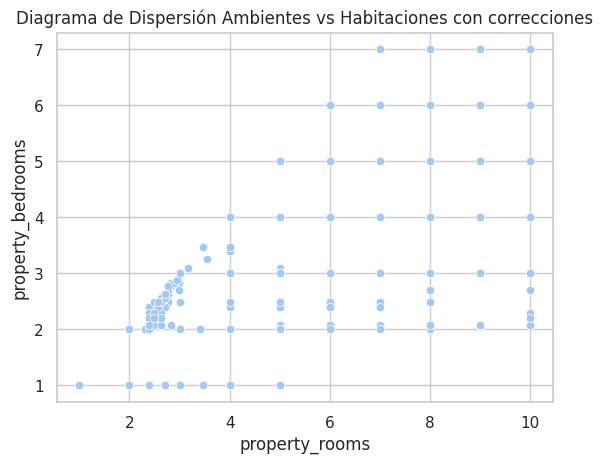

In [1339]:
# Visualización después de correcciones
sns.scatterplot(y=ds_train["property_bedrooms"], x=ds_train["property_rooms"])
plt.title("Diagrama de Dispersión Ambientes vs Habitaciones con correcciones")
plt.show()


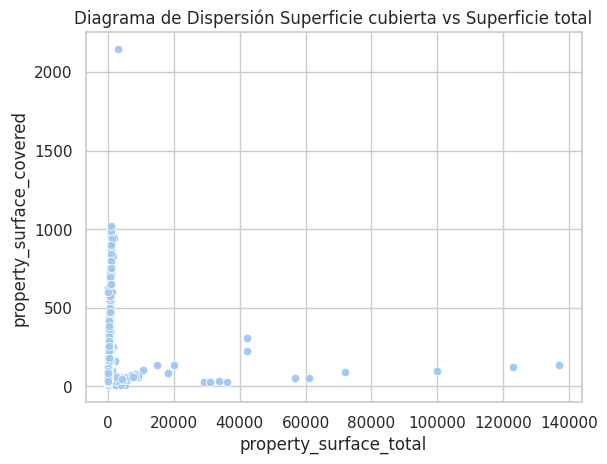

In [1340]:
sns.scatterplot(y=ds_train["property_surface_covered"], x=df["property_surface_total"])
plt.title("Diagrama de Dispersión Superficie cubierta vs Superficie total")
plt.show()

En primer lugar, vamos a distinguir los casos triviales donde la superficie cubierta es mayor a la superficie total.

In [1341]:
# Casos donde la superficie cubierta es mayor a la total
ds_train[(ds_train['property_surface_total'] < ds_train['property_surface_covered'])]

id  start_date    end_date created_on  \
174864  dzeFyIOqpO0z/2NVd8m0NA==  2021-08-31  2022-01-19 2021-08-31   
150612  PU6x+NOV2BO+ojBvT7/J2w==  2021-03-24  2021-06-05 2021-03-24   
107162  I0BITcair7//MBqoZZ2GIw==  2021-03-11  2021-03-25 2021-03-11   
74432   jkQ+10kNWl5yZ68OXQe+uQ==  2021-07-03  2021-09-20 2021-07-03   
228417  ArftiulmAMd+p1Vcc3/FcQ==  2021-03-08  2021-06-05 2021-03-08   
...                          ...         ...         ...        ...   
73552   VXIOxTyNxEDOWwW9zPpNEQ==  2021-12-06  2022-01-27 2021-12-06   
459849  +9w0GBZbuObF0Nw6AAtu2Q==  2021-01-05  2021-01-09 2021-01-05   
395321  nWAxjknG7ROIFciTxBTarQ==  2021-02-13  2021-03-01 2021-02-13   
447774  d5dJ+KakzyKsBc1pIilj5w==  2021-05-22  2021-06-05 2021-05-22   
201173  IOi3jOcqmJABFNJSso/n8g==  2021-11-15  2022-04-23 2021-11-15   

          latitud   longitud          place_l3 property_type  property_rooms  \
174864 -34.627287 -58.432343         Caballito            PH             3.0   
150612 -34.571210 -58.446694          Belgrano  Departamento             4.0   
107162 -34.633805 -58.458383            Flores            PH             4.0   
74432  -34.566899 -58.459191          Belgrano  Departamento             4.0   
228417 -34.665468 -58.469297      Villa Lugano            PH             4.0   
...           ...        ...               ...           ...             ...   
73552  -34.568975 -58.457851          Belgrano  Departamento             2.0   
459849 -34.628282 -58.437803         Caballito  Departamento             3.0   
395321 -34.599997 -58.489187  Villa del Parque          Casa             6.0   
447774 -34.633372 -58.459943            Flores  Departamento             4.0   
201173 -34.649750 -58.387353          Barracas            PH             3.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
174864                2.0                45.00000                      46.0   
150612                3.0                80.00000                      83.0   
107162                3.0               100.00000                     110.0   
74432                 3.0                80.00000                      83.0   
228417                2.0                30.00000                      60.0   
...                   ...                     ...                       ...   
73552                 1.0                65.00000                     623.0   
459849                2.0                 8.95157                      59.7   
395321                4.0               465.00000                     650.0   
447774                3.0                77.00000                      81.0   
201173                2.0                40.00000                      43.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
174864         94000.0             0.111655              0.111655  
150612        345000.0             1.119670              1.119670  
107162        275000.0             1.119670              1.119670  
74432         200000.0             1.119670              1.119670  
228417        130000.0             0.111655              0.111655  
...                ...                  ...                   ...  
73552         160000.0            -0.896360             -0.896360  
459849        167894.0             0.111655              0.111655  
395321       1390000.0             2.127685              2.127685  
447774        135000.0             1.119670              1.119670  
201173        115000.0             0.111655              0.111655  

[319 rows x 15 columns]

#### **Isolation forest**

In [1342]:
# Cargo los datos
X =ds_train.copy()
X.head()

id  start_date    end_date created_on  \
366154  Ab/aN6T8Mna0dAIe9hPIpA==  2021-04-10  2021-06-05 2021-04-10   
408027  MzDpszQ1Zx3SGERGycYoSw==  2021-03-05  2021-03-09 2021-03-05   
142290  Axqbmsbzc9JHXG5S0xW0fg==  2021-03-10  2021-05-06 2021-03-10   
31141   ds5G1c/HVhlxBxwWAGvn3Q==  2021-03-29  2021-04-15 2021-03-29   
219179  DuRHdE5YZY2gPv3gNbtB3Q==  2021-10-23  2021-11-03 2021-10-23   

          latitud   longitud       place_l3 property_type  property_rooms  \
366154 -34.558977 -58.458816       Belgrano  Departamento             3.0   
408027 -34.551437 -58.454158          Nuñez  Departamento             2.0   
142290 -34.638146 -58.509707     Villa Luro  Departamento             3.0   
31141  -34.585703 -58.418339        Palermo  Departamento             4.0   
219179 -34.568861 -58.505879  Villa Urquiza            PH             5.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
366154                2.0                    78.0                      71.0   
408027                1.0                    38.0                      38.0   
142290                2.0                    54.0                      54.0   
31141                 3.0                   138.0                     100.0   
219179                4.0                   273.0                     137.0   

        property_price  z_property_bedrooms  zm_property_bedrooms  
366154        152000.0             0.111655              0.111655  
408027        116000.0            -0.896360             -0.896360  
142290         82000.0             0.111655              0.111655  
31141         260000.0             1.119670              1.119670  
219179        235000.0             2.127685              2.127685

In [1343]:
# Limpio el dataset
X.drop(columns=['latitud', 'longitud', 'created_on', 'end_date', 'start_date', 'z_property_bedrooms', 'zm_property_bedrooms'], inplace=True)
X.head()

id       place_l3 property_type  property_rooms  \
366154  Ab/aN6T8Mna0dAIe9hPIpA==       Belgrano  Departamento             3.0   
408027  MzDpszQ1Zx3SGERGycYoSw==          Nuñez  Departamento             2.0   
142290  Axqbmsbzc9JHXG5S0xW0fg==     Villa Luro  Departamento             3.0   
31141   ds5G1c/HVhlxBxwWAGvn3Q==        Palermo  Departamento             4.0   
219179  DuRHdE5YZY2gPv3gNbtB3Q==  Villa Urquiza            PH             5.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
366154                2.0                    78.0                      71.0   
408027                1.0                    38.0                      38.0   
142290                2.0                    54.0                      54.0   
31141                 3.0                   138.0                     100.0   
219179                4.0                   273.0                     137.0   

        property_price  
366154        152000.0  
408027        116000.0  
142290         82000.0  
31141         260000.0  
219179        235000.0

In [1344]:
# Label encoding de los nombres de las ciudades y el tipo de propiedad

label_encoder = LabelEncoder()
X['place_encoded'] = label_encoder.fit_transform(X['place_l3'])
ds_train['place_encoded'] = label_encoder.fit_transform(X['place_l3'])
X['type_encoded'] = label_encoder.fit_transform(X['property_type'])
ds_train['type_encoded'] = label_encoder.fit_transform(X['place_l3'])

X

<ipython-input-1344-64ff5b082a66>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-1344-64ff5b082a66>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



id         place_l3 property_type  \
366154  Ab/aN6T8Mna0dAIe9hPIpA==         Belgrano  Departamento   
408027  MzDpszQ1Zx3SGERGycYoSw==            Nuñez  Departamento   
142290  Axqbmsbzc9JHXG5S0xW0fg==       Villa Luro  Departamento   
31141   ds5G1c/HVhlxBxwWAGvn3Q==          Palermo  Departamento   
219179  DuRHdE5YZY2gPv3gNbtB3Q==    Villa Urquiza            PH   
...                          ...              ...           ...   
407216  8EdQ/1Fu6c66sjsCYAchRQ==  Velez Sarsfield            PH   
113807  LjLMrBBkeI1gFW7EjID7BA==         Belgrano  Departamento   
157079  tlk/pLCTnq3f3nthoVqtJA==          Almagro  Departamento   
133655  DsEdZwWIJUwlbt6NNW1JEg==        Balvanera  Departamento   
170188  TN5lzrHaYRbTxnC6JqLf2g==         Belgrano  Departamento   

        property_rooms  property_bedrooms  property_surface_total  \
366154             3.0                2.0                    78.0   
408027             2.0                1.0                    38.0   
142290             3.0                2.0                    54.0   
31141              4.0                3.0                   138.0   
219179             5.0                4.0                   273.0   
...                ...                ...                     ...   
407216             3.0                2.0                   170.0   
113807             1.0                1.0                    85.0   
157079             3.0                2.0                    70.0   
133655             1.0                1.0                    25.0   
170188             1.0                1.0                    38.0   

        property_surface_covered  property_price  place_encoded  type_encoded  
366154                      71.0        152000.0              7             1  
408027                      38.0        116000.0             25             1  
142290                      54.0         82000.0             50             1  
31141                      100.0        260000.0             27             1  
219179                     137.0        235000.0             57             2  
...                          ...             ...            ...           ...  
407216                      93.0        135000.0             44             2  
113807                      74.0        290000.0              7             1  
157079                      64.0        155000.0              2             1  
133655                      25.0         55000.0              4             1  
170188                      38.0         95000.0              7             1  

[72261 rows x 10 columns]

In [1345]:
X.drop(columns=['place_l3', 'property_type', 'id'], inplace=True)

In [1346]:
# Creo el modelo
iforest = IsolationForest(
    n_estimators=100,
    max_samples="auto",
    contamination=0.05,
    max_features=5,
    bootstrap=False,
    n_jobs=-1,
    random_state=1,
)

# Entreno y genero la predicción
pred = iforest.fit_predict(X)

# Almaceno scores y etiquetas
X["scores"] = iforest.decision_function(X)
X["outlier_label"] = pred

# Observaciones anómalas
X[X.outlier_label == -1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



property_rooms  property_bedrooms  property_surface_total  \
219179             5.0                4.0                   273.0   
196810             6.0                5.0                   180.0   
197677             5.0                2.0                   237.0   
383046             8.0                4.0                   262.0   
86156              4.0                3.0                   352.0   
...                ...                ...                     ...   
429140             6.0                4.0                   507.0   
367628             8.0                4.0                   230.0   
209924             6.0                5.0                   280.0   
107540             6.0                5.0                   267.0   
79653              6.0                4.0                   269.0   

        property_surface_covered  property_price  place_encoded  type_encoded  \
219179                     137.0        235000.0             57             2   
196810                     130.0        240000.0              9             2   
197677                     237.0        430000.0             39             0   
383046                     242.0        690000.0             15             0   
86156                      278.0        385000.0             22             0   
...                          ...             ...            ...           ...   
429140                     372.0        695000.0             15             0   
367628                     230.0        373000.0             47             0   
209924                     230.0        256000.0             21             0   
107540                     135.0        185000.0             28             0   
79653                      166.0        280000.0              9             2   

          scores  outlier_label  
219179 -0.019211             -1  
196810 -0.022879             -1  
197677 -0.013034             -1  
383046 -0.077101             -1  
86156  -0.030370             -1  
...          ...            ...  
429140 -0.085764             -1  
367628 -0.062671             -1  
209924 -0.034598             -1  
107540 -0.023647             -1  
79653  -0.025028             -1  

[3613 rows x 9 columns]

In [1347]:
# Cantidad de obs. anómalas
X.outlier_label.value_counts()

outlier_label
 1    68648
-1     3613
Name: count, dtype: int64

Obtuvimos 3611 anomalías. Visualizamos.

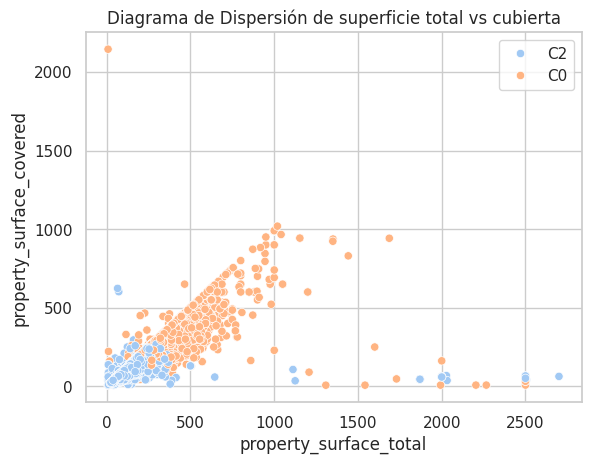

In [1348]:
# Grafico dispersograma
color = [f"C{n+1}" for n in (X["outlier_label"].values)]

sns.scatterplot(x=X["property_surface_total"], y=X["property_surface_covered"], hue=color)
plt.title("Diagrama de Dispersión de superficie total vs cubierta")
plt.show()

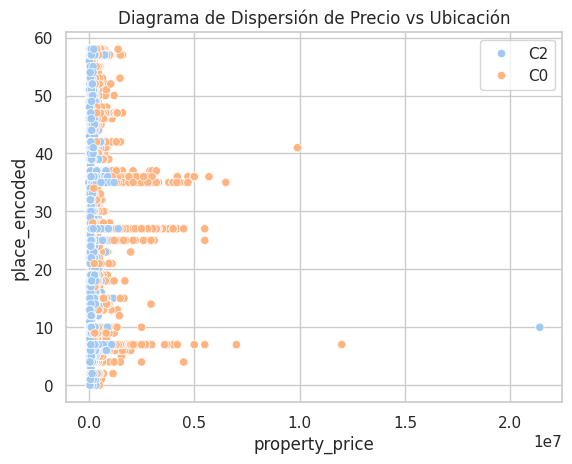

In [1349]:
sns.scatterplot(x=X["property_price"], y=X["place_encoded"], hue=color)
plt.title("Diagrama de Dispersión de Precio vs Ubicación")
plt.show()

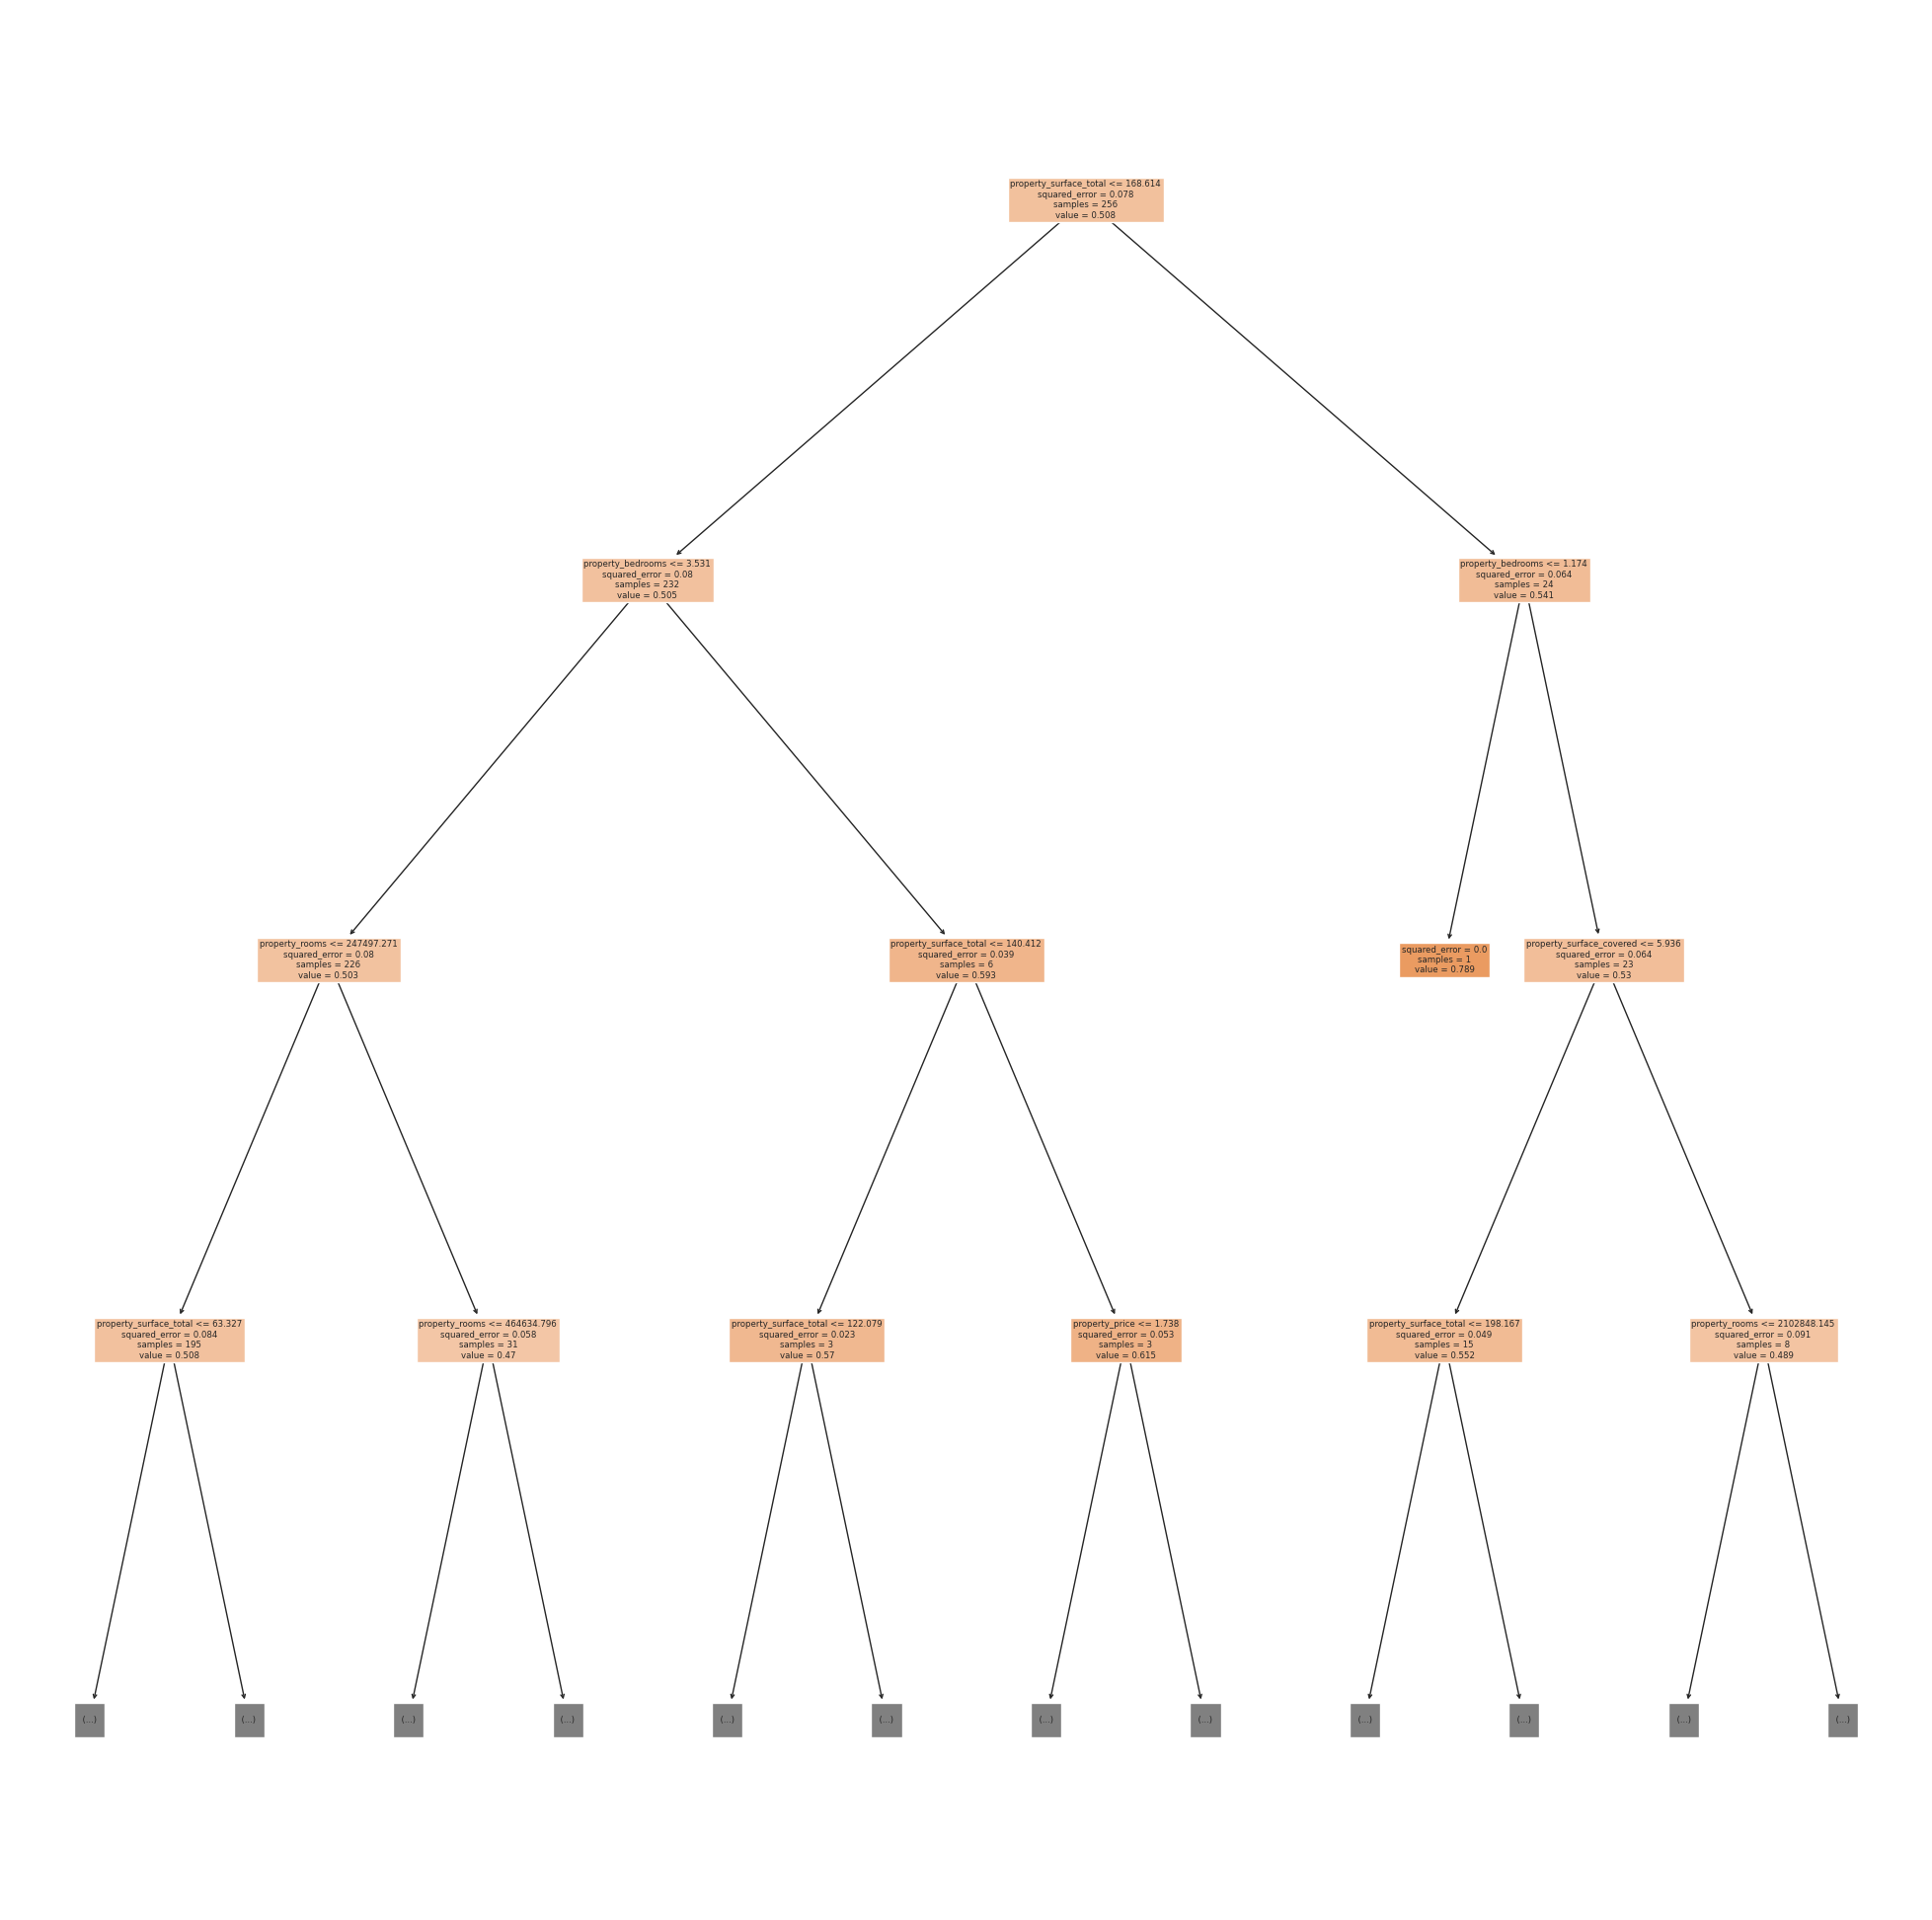

In [1350]:
# Selecciono el árbol
estimator = iforest.estimators_[5]

# Grafico
plt.figure(figsize=(25, 25))
sk.tree.plot_tree(estimator, feature_names=X.columns, filled=True, max_depth=3)
plt.show()

#### **LOF**

Vamos a intentar detectar outliers multivariados usando LOF.

In [1351]:
def lof(df, var1, var2, name):
  radius = calculo_lof(df, var1, var2, name)
  grafico_lof(df, var1, var2, name, radius)
  return


def calculo_lof(df, var1, var2, name):
  # CÁLCULO
  # Conjunto de entrenamiento
  X = df[[var1, var2]].values

  # Creo el clasificador
  clf = LocalOutlierFactor(n_neighbors=20)

  # Genero prediccion
  y_pred = clf.fit_predict(X)

  # Guardo los scores
  df[name] = clf.negative_outlier_factor_

  #VISUALIZACION
  # Calculo radio para plotear score
  radius = (df[name].max() - df[name]) / (df[name].max() - df[name].min())
  return radius


def grafico_lof(df, var1, var2, name, radius):
  # Grafico LOF
  plt.figure(figsize=(10, 10))
  plt.title("Local Outlier Factor (LOF)" + name)
  plt.scatter(
      df[var1].values,
      df[var2].values,
      edgecolor="grey",
      s=30,
      label="datos",
      facecolors="none",
  )
  plt.scatter(
      df[var1].values,
      df[var2].values,
      s=1300 * radius,
      edgecolors="red",
      facecolors="none",
      label="Outlier scores",
  )
  legend = plt.legend(loc="upper left")
  legend.legendHandles[0]._sizes = [10]
  legend.legendHandles[1]._sizes = [20]
  plt.show()
  return

In [1352]:
def lof_segun_tipo(df, var1, var2, name):
  # Lista de tipos de vivienda
  tipos = ['Casa', 'PH', 'Departamento']

  # Subplots
  fig, axs = plt.subplots(8, 5, figsize=(16, 24))
  axs = axs.flatten()

  for i, tipo in enumerate(tipos):
      filtered_data = ds_train[ds_train['property_type'] == tipo]

      # CÁLCULO
      # Conjunto de entrenamiento
      X = filtered_data[var1,var2].values
      # Creo el clasificador
      clf = LocalOutlierFactor(n_neighbors=20)
      # Genero prediccion
      y_pred = clf.fit_predict(X)
      # Guardo los scores
      filtered_data[name] = clf.negative_outlier_factor_

      #VISUALIZACION
      # Calculo radio para plotear score
      radius = (filtered_data[name].max() - filtered_data[name]) / (filtered_data[name].max() - filtered_data[name].min())

      # Grafico LOF
      plt.figure(figsize=(10, 10))
      plt.scatter(
          filtered_data[var1].values,
          filtered_data[var2].values,
          edgecolor="grey",
          s=30,
          label="datos",
          facecolors="none",
      )
      plt.scatter(
          filtered_data[var1].values,
          filtered_data[var2].values,
          s=1300 * radius,
          edgecolors="red",
          facecolors="none",
          label="Outlier scores",
      )
      legend = plt.legend(loc="upper left")
      legend.legendHandles[0]._sizes = [10]
      legend.legendHandles[1]._sizes = [20]


      axs[i].set_title(f'{var1}, {var2} en {barrio}')

  # Adjust layout
  plt.tight_layout()
  # Show the plot
  plt.show()
  return

##### Superficie cubierta vs superficie total

<ipython-input-1351-f3f243b19d6b>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-1351-f3f243b19d6b>:48: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.

<ipython-input-1351-f3f243b19d6b>:49: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



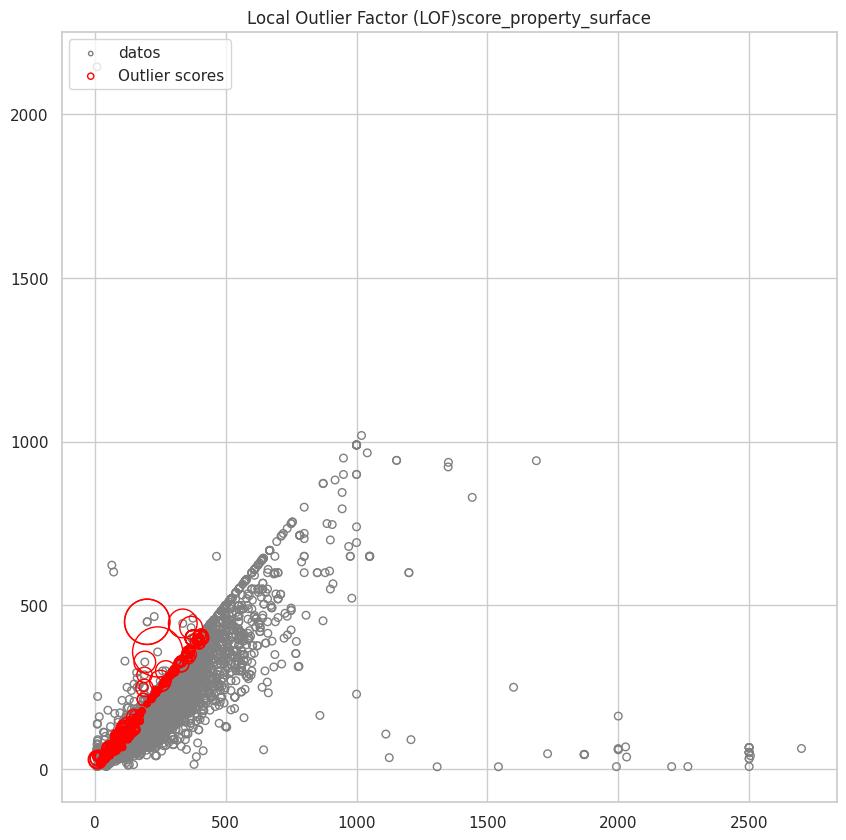

In [1353]:
lof(ds_train, 'property_surface_total', 'property_surface_covered', 'score_property_surface')

##### Precio vs Superficie total

<ipython-input-1351-f3f243b19d6b>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-1351-f3f243b19d6b>:48: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.

<ipython-input-1351-f3f243b19d6b>:49: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



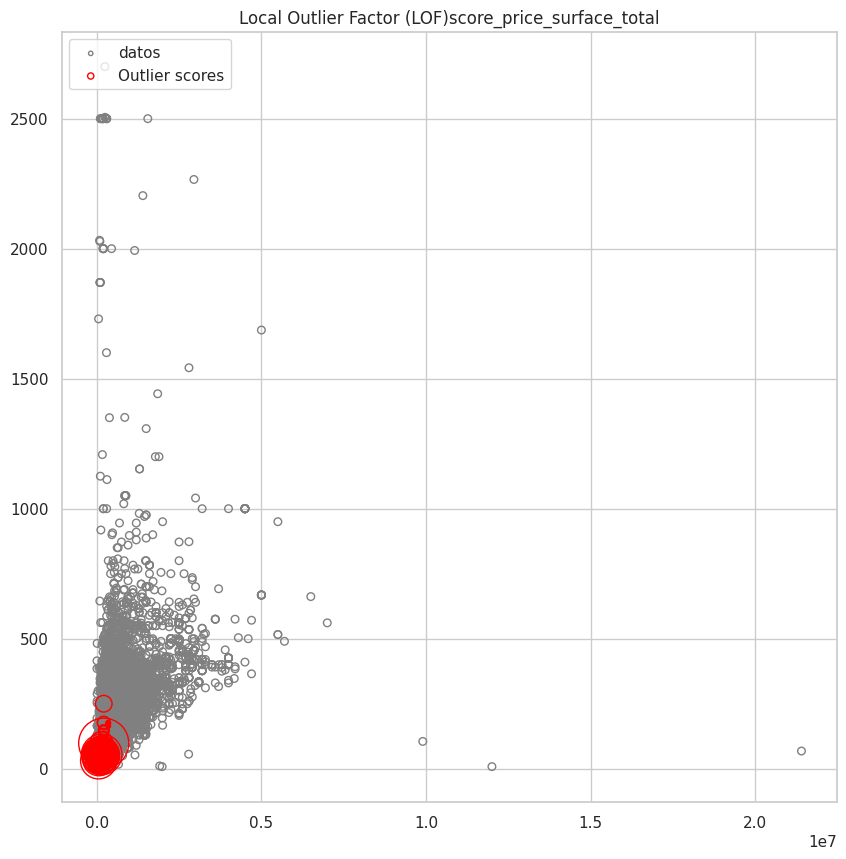

In [1354]:
lof(ds_train, 'property_price', 'property_surface_total', 'score_price_surface_total')

###### Ubicación vs Precio

<ipython-input-1351-f3f243b19d6b>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-1351-f3f243b19d6b>:48: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.

<ipython-input-1351-f3f243b19d6b>:49: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



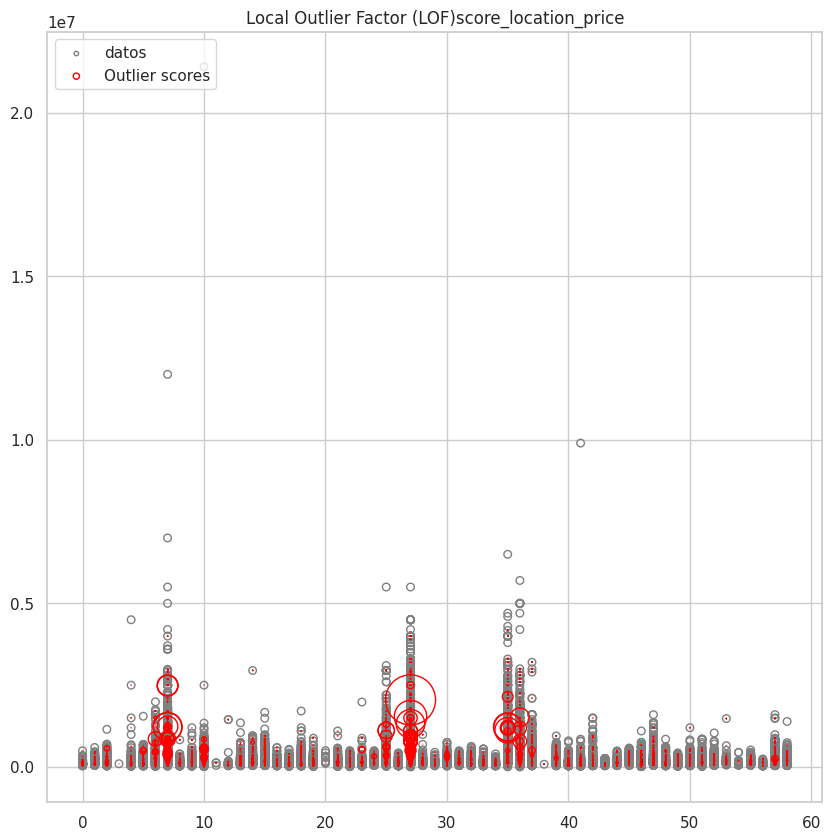

In [1355]:
lof(ds_train, 'place_encoded', 'property_price', 'score_location_price')

##### Ubicación vs superficie cubierta

<ipython-input-1351-f3f243b19d6b>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-1351-f3f243b19d6b>:48: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.

<ipython-input-1351-f3f243b19d6b>:49: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



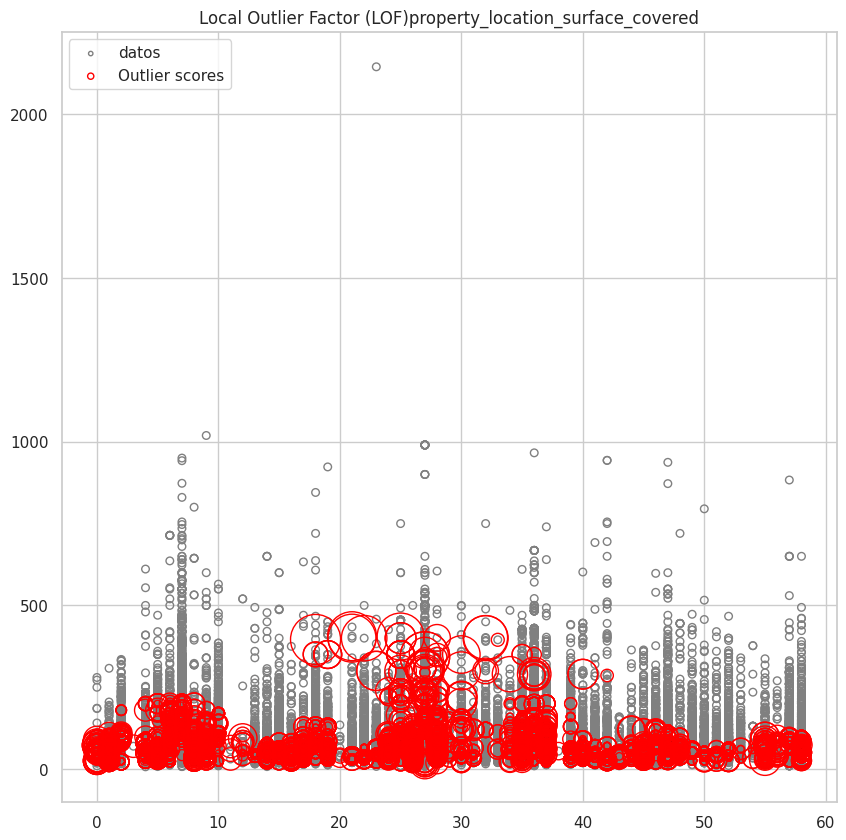

In [1356]:
lof(ds_train, 'place_encoded', 'property_surface_covered', 'property_location_surface_covered')

### Relación precio de venta-metros de superficie



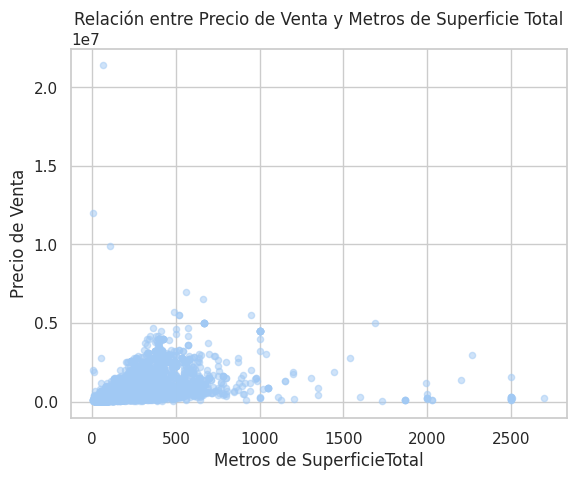

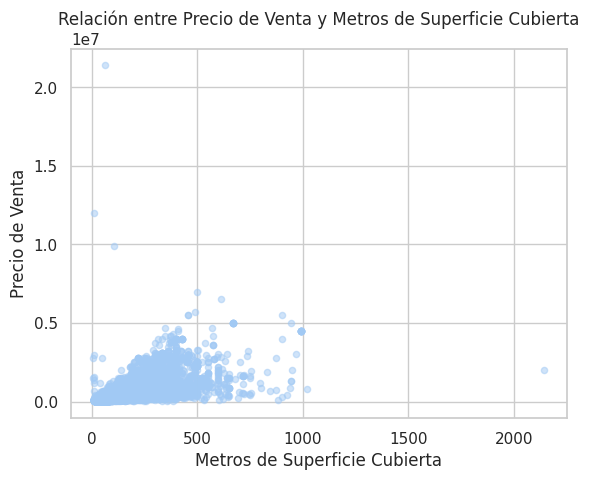

In [1357]:
ds_train.plot.scatter(x='property_surface_total', y='property_price', alpha=0.5)
plt.title('Relación entre Precio de Venta y Metros de Superficie Total')
plt.xlabel('Metros de SuperficieTotal')
plt.ylabel('Precio de Venta')
plt.grid(True)
plt.show()


ds_train.plot.scatter(x='property_surface_covered', y='property_price', alpha=0.5)
plt.title('Relación entre Precio de Venta y Metros de Superficie Cubierta')
plt.xlabel('Metros de Superficie Cubierta')
plt.ylabel('Precio de Venta')
plt.grid(True)
plt.show()

Podemos ver algunos datos atípicos donde a pesar de muchos precios de superficie, el precio es demasiado bajo, y su opuesto, precio muy alto para supercie muy limitada.

PENDIENTE

# Guardado de train y test Datasets

In [1358]:
if using_drive:
  ds_train.to_csv(drive_path + "/Dataset/ds_train.csv", index=False)
  ds_test.to_csv(drive_path + "/Dataset/ds_test.csv", index=False)
else:
  ds_train.to_csv("./dataset/ds_train.csv", index=False)
  ds_test.to_csv("./dataset/ds_test.csv", index=False)